In [1]:
#!/usr/bin/env python
# -*- encoding: utf-8

from datetime import datetime as dt, timedelta as td
import numpy as np
from numpy import loadtxt
from matplotlib import pyplot as plt
import yaml
import time
import random
from scipy import stats
from Cluster_functions import read_file, get_indices_sparse, unnest
from scipy.sparse import load_npz

with open("Options.yaml") as f:
    Options = yaml.safe_load(f)
    
reschar = Options["str_result"] + Options["whichClusters"]
    

In [2]:
#########################
# Load storm tracks 
#########################

#Storm tracks file
st_file = Options["st_file"]
nrskip = Options["nrskip"]

str_id, str_nr, str_dt, str_lat, str_lon = read_file(st_file)
str_pres   = loadtxt(st_file, comments="#", unpack=False,skiprows=nrskip,usecols=[5],dtype=float)
str_lapl   = loadtxt(st_file, comments="#", unpack=False,skiprows=nrskip,usecols=[9],dtype=float)
str_radi = loadtxt(st_file, comments="#", unpack=False,skiprows=nrskip,usecols=[7],dtype=float)
str_delp = loadtxt(st_file, comments="#", unpack=False,skiprows=nrskip,usecols=[8],dtype=float)

#Convert to an array
str_dt          = np.array(str_dt)
str_month = np.array([x.month for x in str_dt])
str_year = np.array([x.year for x in str_dt])
#str_id = str_id - np.nanmin(str_id) + 1

nrstorms = len(np.unique(str_id))
#nrstorms = np.nanmax(str_id)

#########################
# Get indices of storms 
# so that ids_storms[id] gives the ids in the arrays
# str_id, str_lon,.. belonging to that specific storm
#########################
uniq_ids = np.unique(str_id)
ids_storms = get_indices_sparse(str_id)
nrstorms = len(uniq_ids)

#########################
# Load clustering data
#########################
formatter =  "{:1.1f}"
outfile = Options["outdir"] +  Options["str_result"] + formatter.format( Options["distthresh"]) + "_tim_" + formatter.format( Options["timthresh"]) + "_length_" + formatter.format( Options["lngthresh"]) + ".npz"
outfile = "Clusters_output/Global_Results_EI_1.0_tim_36.0_length_1.5_timlength_48.0_AlongTracksDirect.npz"
print(outfile)
Results = np.load(outfile,allow_pickle=True)
try:
    #Complete cluster
    sorted_clusters = Results["sorted_clusters"]

    #Length
    sorted_subclusters_length = Results["sorted_subclusters_length"]
    sorted_clusters_length =  sorted(unnest(sorted_subclusters_length))

    #No length cluster
    sorted_subclusters_nolength = Results["sorted_subclusters_nolength"]
    sorted_clusters_nolength =  sorted(unnest(sorted_subclusters_nolength))
    
    outfile_begin = Options["outdir"] +  Options["str_result"] + formatter.format(Options["distthresh"]) + "_tim_" + formatter.format(Options["timthresh"]) + "_length_" + formatter.format(Options["lngthresh"]) + "_timlength_"  + formatter.format(Options["timlngthresh"]*6.0) + "_AlongTracksDirect_" 

    
    #Other 
    dtTracks = load_npz(outfile_begin + "dtTracks.npz")
    drTracks = load_npz(outfile_begin + "drTracks.npz")

except ValueError:
        print("Invalid option for whichClusters")
str_connected = Results['str_connected']

#########################
# Preprocess storm tracks
#########################

#Check which year, month, hemisphere belongs storms to
start = time.time()

yrstorms = np.zeros(nrstorms)
mnstorms = np.zeros(nrstorms)
hemstorms = np.full(nrstorms,"Undefined")
minpres = np.zeros(nrstorms)
mindpdt = np.zeros(nrstorms)
maxlapl = np.zeros(nrstorms)
maxdldt = np.zeros(nrstorms)

firstdt = []
lastdt = []

for strid in range(nrstorms):    
    dt_temp = str_dt[ids_storms[uniq_ids[strid]]]
    lat_temp = str_lat[ids_storms[uniq_ids[strid]]]
    pres_temp = str_pres[ids_storms[uniq_ids[strid]]]
    lapl_temp = str_lapl[ids_storms[uniq_ids[strid]]]

    #Check which winter it belongs to
    tmpyear = dt_temp[0].year
    tmpmonth = dt_temp[0].month
    yrstorms[strid] = tmpyear
    mnstorms[strid] = tmpmonth

    #Save the first and last dt
    firstdt.append(dt_temp[0])
    lastdt.append(dt_temp[-1])

    #Check if the storm is in the NH or SH
    if(np.nanmean(lat_temp) > 0):
        hemstorms[strid] = "NH"
    elif(np.nanmean(lat_temp) < 0):
        hemstorms[strid] = "SH"
        
    #Min pres and dpdt, max lapl and dldt
    minpres[strid] = np.nanmin(pres_temp)
    delta = (dt_temp[1] - dt_temp[0]).total_seconds()/3600
    mindpdt[strid] = np.nanmin(pres_temp[1:] - pres_temp[:-1])/delta
    maxlapl[strid] = np.nanmax(lapl_temp)
    maxdldt[strid] = np.nanmax(lapl_temp[1:] - lapl_temp[:-1])/delta

end = time.time()
firstdt = np.array(firstdt)
lastdt = np.array(lastdt)
print(str(end - start) + " seconds")

#Months of storm, relative to beginning of 1979
mnstorms_rel = (yrstorms - 1979)*12.0 + mnstorms
refdt = dt(1979,1,1,0,0)
diffs = [(x - refdt).total_seconds()/3600 for x in str_dt]   



Clusters_output/Global_Results_EI_1.0_tim_36.0_length_1.5_timlength_48.0_AlongTracksDirect.npz
9.46679949760437 seconds


In [3]:
dtTracks = dtTracks.tocsr()
drTracks = drTracks.tocsr()

In [4]:
dtStorms = np.zeros(nrstorms)
drStorms = np.zeros(nrstorms)
for st in range(nrstorms):
    dtStorms[st] = dtTracks[st,:].max()
    drStorms[st] = drTracks[st,:].max()
    

In [5]:

######################################################
# Statistics 
######################################################
'''
#PDF with length of clusters
lengthclust = np.zeros(maxlength)
lengths     = []

#Clusters per winter 
winters = np.arange(1979,2016)
nrclst_wint = np.zeros(len(winters))
nrclst_wintNH = np.zeros(len(winters))
nrstrm_wint = np.zeros(len(winters))
nrstrmclst_wint = np.zeros(len(winters))
nrstrm_wintNH = np.zeros(len(winters))
nrstrmclst_wintNH = np.zeros(len(winters))
nrdays_wint = np.zeros(len(winters))

test = 0

for clustidx in range(len(sorted_clusters)):
    clusttemp = sorted_clusters[clustidx]

    lengths.append(len(clusttemp))
    lengthclust[len(clusttemp)-1] += 1

    #Check which winter it belongs to
    tmpyear = str_dt[str_id == clusttemp[0]][0].year
    tmpmonth = str_dt[str_id == clusttemp[0]][0].month
    if(tmpmonth < 11):
        tmpyear = tmpyear - 1

    nrstrm_wint[winters == tmpyear] += len(clusttemp)
    if(len(clusttemp) > 1):
        nrclst_wint[winters == tmpyear] += 1
        nrstrmclst_wint[winters == tmpyear] += len(clusttemp)
        if(np.nanmean(str_lat[str_id == clusttemp[0]]) > 0):
            nrclst_wintNH[winters == tmpyear] += 1
            nrstrmclst_wintNH[winters == tmpyear] += len(clusttemp)
'''            
            
######################################################
# Check which basin storms and clusters belong to
######################################################
ext_winter = np.array([(x.month <= 3) | (x.month >= 10) for x in str_dt])
ext_swinter = np.array([(x.month >= 4) & (x.month <= 9) for x in str_dt])

checkBasin = True
if(checkBasin):
    str_basin = np.full(np.nanmax(str_id),"Undefined")
    str_hemis = np.full(np.nanmax(str_id),"Undefined")
    str_first = np.full(np.nanmax(str_id),dt(9999,12,1,0))
    
    #Check for basin for each storm
    for strm in uniq_ids:
        print("Strm " + str(strm))
        #selidxs = (str_id == strm) #& (str_connected == True)
        lon_temp = str_lon[ids_storms[strm]] 
        lat_temp = str_lat[ids_storms[strm]] 
        dt_temp = str_dt[ids_storms[strm]] 
        wint_temp = ext_winter[ids_storms[strm]]
        swint_temp = ext_swinter[ids_storms[strm]]
        #conn_temp = str_connected[ids_storms[strm]]
        
        
        
        #if(np.any(conn_temp !=0)):
        #    str_first[strm -1] = np.nanmin(dt_temp[conn_temp >0])
         
        nr_EuroAsia = np.nansum((lon_temp >= 45) & (lon_temp <= 120) & (lat_temp >= 20) & (lat_temp <= 75) & (wint_temp == True) )
        nr_America = np.nansum((lon_temp >= 240) & (lon_temp <= 275) & (lat_temp >= 20) & (lat_temp <= 75) & (wint_temp == True) )
        #Changed from 20-70 to 30-75
        nr_Atlantic = np.nansum(((lon_temp >= 275) | (lon_temp <= 45)) & (lat_temp >= 30) & (lat_temp <= 75) & (wint_temp == True) )
        nr_Pacific = np.nansum((lon_temp >= 120) & (lon_temp <= 240) & (lat_temp >= 30) & (lat_temp <= 75) & (wint_temp == True) )
        nr_nhemis    = np.nansum((lat_temp <= 75) & (lat_temp >= 20) & (wint_temp == True)) 

        nr_sAtlantic = np.nansum(((lon_temp >= 305) | (lon_temp <= 25)) & (lat_temp >= -75) & (lat_temp <= -30) & (swint_temp == True) )
        nr_sPacific = np.nansum((lon_temp >= 180) & (lon_temp <= 300) & (lat_temp >= -75) & (lat_temp <= -30) & (swint_temp == True) )
        #Was until 115
        nr_sIndian  = np.nansum((lon_temp >= 25) & (lon_temp <= 180) & (lat_temp >= -75) & (lat_temp <= -30) & (swint_temp == True))

        nr_shemis    = np.nansum((lat_temp >= -75) & (lat_temp <= -20) & (swint_temp == True)) 

        if( nr_EuroAsia/len(lon_temp) >= 0.5):
            str_basin[strm -1] = "EuroAsia"
            
        if( nr_America/len(lon_temp) >= 0.5):
            str_basin[strm -1] = "America"
            
        if( nr_Atlantic/len(lon_temp) >= 0.5):
            str_basin[strm -1] = "Atlantic"

        if( nr_Pacific/len(lon_temp) >= 0.5):
            str_basin[strm -1] = "Pacific"

        if( nr_sAtlantic/len(lon_temp) >= 0.5):
            str_basin[strm -1] = "sAtlantic"

        if( nr_sPacific/len(lon_temp) >= 0.5):
            str_basin[strm -1] = "sPacific"

        if( nr_sIndian/len(lon_temp) >= 0.5):
            str_basin[strm -1] = "sIndian"

        if( nr_nhemis/len(lon_temp) >= 0.5):
            str_hemis[strm -1] = "nhemis"

        if( nr_shemis/len(lon_temp) >= 0.5):
            str_hemis[strm -1] = "shemis"

checkBasinClusters = True
if(checkBasinClusters):
    #Clusters All
    sorted_clusters_Atlantic = []
    sorted_clusters_Pacific = []
    sorted_clusters_sAtlantic = []
    sorted_clusters_sPacific = []
    sorted_clusters_sIndian = []
    sorted_clusters_shemisphere = []

    lenclust = np.zeros(len(sorted_clusters))
    for clidx in range(len(sorted_clusters)):
        storms_temp = sorted_clusters[clidx]
        lenclust[clidx] = len(storms_temp)
        if(len(storms_temp) > 0): #3
        #sorted_clusters_Atlantic.append(storms_temp)
            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "Atlantic")/len(storms_temp) >= 0.5):
                sorted_clusters_Atlantic.append(storms_temp)

            #sorted_clusters_Atlantic.append(storms_temp)
            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "Pacific")/len(storms_temp) >= 0.5):
                sorted_clusters_Pacific.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sAtlantic")/len(storms_temp) >= 0.5):
                sorted_clusters_sAtlantic.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sPacific")/len(storms_temp) >= 0.5):
                sorted_clusters_sPacific.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sIndian")/len(storms_temp) >= 0.5):
                sorted_clusters_sIndian.append(storms_temp)

            if(np.nansum(str_hemis[np.array(storms_temp) - 1] == "shemis")/len(storms_temp) >= 0.5):
                sorted_clusters_shemisphere.append(storms_temp)

    #Clusters Length
    sorted_clusters_length_Atlantic = []
    sorted_clusters_length_Pacific = []
    sorted_clusters_length_sAtlantic = []
    sorted_clusters_length_sPacific = []
    sorted_clusters_length_sIndian = []
    sorted_clusters_length_shemisphere = []            
    lenclustLength = np.zeros(len(sorted_clusters_length))
    for clidx in range(len(sorted_clusters)):
        storms_temp = sorted_clusters_length[clidx]
        lenclustLength[clidx] = len(storms_temp)
        if(len(storms_temp) > 0): #3
        #sorted_clusters_Atlantic.append(storms_temp)
            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "Atlantic")/len(storms_temp) >= 0.5):
                sorted_clusters_length_Atlantic.append(storms_temp)

            #sorted_clusters_Atlantic.append(storms_temp)
            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "Pacific")/len(storms_temp) >= 0.5):
                sorted_clusters_length_Pacific.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sAtlantic")/len(storms_temp) >= 0.5):
                sorted_clusters_length_sAtlantic.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sPacific")/len(storms_temp) >= 0.5):
                sorted_clusters_length_sPacific.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sIndian")/len(storms_temp) >= 0.5):
                sorted_clusters_length_sIndian.append(storms_temp)

            if(np.nansum(str_hemis[np.array(storms_temp) - 1] == "shemis")/len(storms_temp) >= 0.5):
                sorted_clusters_length_shemisphere.append(storms_temp)

    #Clusters Stationary
    sorted_clusters_nolength_Atlantic = []
    sorted_clusters_nolength_Pacific = []
    sorted_clusters_nolength_sAtlantic = []
    sorted_clusters_nolength_sPacific = []
    sorted_clusters_nolength_sIndian = []
    sorted_clusters_nolength_shemisphere = []            
    lenclustNoLength = np.zeros(len(sorted_clusters_nolength))
    for clidx in range(len(sorted_clusters)):
        storms_temp = sorted_clusters_nolength[clidx]
        lenclustNoLength[clidx] = len(storms_temp)
        if(len(storms_temp) > 0): #3
        #sorted_clusters_Atlantic.append(storms_temp)
            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "Atlantic")/len(storms_temp) >= 0.5):
                sorted_clusters_nolength_Atlantic.append(storms_temp)

            #sorted_clusters_Atlantic.append(storms_temp)
            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "Pacific")/len(storms_temp) >= 0.5):
                sorted_clusters_nolength_Pacific.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sAtlantic")/len(storms_temp) >= 0.5):
                sorted_clusters_nolength_sAtlantic.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sPacific")/len(storms_temp) >= 0.5):
                sorted_clusters_nolength_sPacific.append(storms_temp)

            if(np.nansum(str_basin[np.array(storms_temp) - 1] == "sIndian")/len(storms_temp) >= 0.5):
                sorted_clusters_nolength_sIndian.append(storms_temp)

            if(np.nansum(str_hemis[np.array(storms_temp) - 1] == "shemis")/len(storms_temp) >= 0.5):
                sorted_clusters_nolength_shemisphere.append(storms_temp)

    #np.savez("/Data/gfi/spengler/cwe022/Sorted_Clusters_Areas" + reschar + ".npz",sorted_clusters_Atlantic=sorted_clusters_Atlantic,sorted_clusters_Pacific= sorted_clusters_Pacific, sorted_clusters_sAtlantic=sorted_clusters_sAtlantic,sorted_clusters_sPacific=sorted_clusters_sPacific,sorted_clusters_sIndian=sorted_clusters_sIndian, sorted_clusters_shemisphere= sorted_clusters_shemisphere, str_basin=str_basin,str_hemis=str_hemis)
else:
    Results = np.load("/Data/gfi/spengler/cwe022/Sorted_Clusters_Areas" + reschar + ".npz",allow_pickle=True)
    sorted_clusters_Atlantic = Results["sorted_clusters_Atlantic"]
    sorted_clusters_Pacific = Results["sorted_clusters_Pacific"]
    sorted_clusters_sAtlantic = Results["sorted_clusters_sAtlantic"]
    sorted_clusters_sPacific = Results["sorted_clusters_sPacific"]
    sorted_clusters_sIndian = Results["sorted_clusters_sIndian"]
    sorted_clusters_shemisphere = Results["sorted_clusters_shemisphere"]
    


Strm 1
Strm 2
Strm 3
Strm 4
Strm 5
Strm 6
Strm 7
Strm 8
Strm 9
Strm 10
Strm 11
Strm 12
Strm 13
Strm 14
Strm 15
Strm 16
Strm 17
Strm 18
Strm 19
Strm 20
Strm 21
Strm 22
Strm 23
Strm 24
Strm 25
Strm 26
Strm 27
Strm 28
Strm 29
Strm 30
Strm 31
Strm 32
Strm 33
Strm 34
Strm 35
Strm 36
Strm 37
Strm 38
Strm 39
Strm 40
Strm 41
Strm 42
Strm 43
Strm 44
Strm 45
Strm 46
Strm 47
Strm 48
Strm 49
Strm 50
Strm 51
Strm 52
Strm 53
Strm 54
Strm 55
Strm 56
Strm 57
Strm 58
Strm 59
Strm 60
Strm 61
Strm 62
Strm 63
Strm 64
Strm 65
Strm 66
Strm 67
Strm 68
Strm 69
Strm 70
Strm 71
Strm 72
Strm 73
Strm 74
Strm 75
Strm 76
Strm 77
Strm 78
Strm 79
Strm 80
Strm 81
Strm 82
Strm 83
Strm 84
Strm 85
Strm 86
Strm 87
Strm 88
Strm 89
Strm 90
Strm 91
Strm 92
Strm 93
Strm 94
Strm 95
Strm 96
Strm 97
Strm 98
Strm 99
Strm 100
Strm 101
Strm 102
Strm 103
Strm 104
Strm 105
Strm 106
Strm 107
Strm 108
Strm 109
Strm 110
Strm 111
Strm 112
Strm 113
Strm 114
Strm 115
Strm 116
Strm 117
Strm 118
Strm 119
Strm 120
Strm 121
Strm 122
Strm 123
S

Strm 1011
Strm 1012
Strm 1013
Strm 1014
Strm 1015
Strm 1016
Strm 1017
Strm 1018
Strm 1019
Strm 1020
Strm 1021
Strm 1022
Strm 1023
Strm 1024
Strm 1025
Strm 1026
Strm 1027
Strm 1028
Strm 1029
Strm 1030
Strm 1031
Strm 1032
Strm 1033
Strm 1034
Strm 1035
Strm 1036
Strm 1037
Strm 1038
Strm 1039
Strm 1040
Strm 1041
Strm 1042
Strm 1043
Strm 1044
Strm 1045
Strm 1046
Strm 1047
Strm 1048
Strm 1049
Strm 1050
Strm 1051
Strm 1052
Strm 1053
Strm 1054
Strm 1055
Strm 1056
Strm 1057
Strm 1058
Strm 1059
Strm 1060
Strm 1061
Strm 1062
Strm 1063
Strm 1064
Strm 1065
Strm 1066
Strm 1067
Strm 1068
Strm 1069
Strm 1070
Strm 1071
Strm 1072
Strm 1073
Strm 1074
Strm 1075
Strm 1076
Strm 1077
Strm 1078
Strm 1079
Strm 1080
Strm 1081
Strm 1082
Strm 1083
Strm 1084
Strm 1085
Strm 1086
Strm 1087
Strm 1088
Strm 1089
Strm 1090
Strm 1091
Strm 1092
Strm 1093
Strm 1094
Strm 1095
Strm 1096
Strm 1097
Strm 1098
Strm 1099
Strm 1100
Strm 1101
Strm 1102
Strm 1103
Strm 1104
Strm 1105
Strm 1106
Strm 1107
Strm 1108
Strm 1109
Strm 1110


Strm 2029
Strm 2030
Strm 2031
Strm 2032
Strm 2033
Strm 2034
Strm 2035
Strm 2036
Strm 2037
Strm 2038
Strm 2039
Strm 2040
Strm 2041
Strm 2042
Strm 2043
Strm 2044
Strm 2045
Strm 2046
Strm 2047
Strm 2048
Strm 2049
Strm 2050
Strm 2051
Strm 2052
Strm 2053
Strm 2054
Strm 2055
Strm 2056
Strm 2057
Strm 2058
Strm 2059
Strm 2060
Strm 2061
Strm 2062
Strm 2063
Strm 2064
Strm 2065
Strm 2066
Strm 2067
Strm 2068
Strm 2069
Strm 2070
Strm 2071
Strm 2072
Strm 2073
Strm 2074
Strm 2075
Strm 2076
Strm 2077
Strm 2078
Strm 2079
Strm 2080
Strm 2081
Strm 2082
Strm 2083
Strm 2084
Strm 2085
Strm 2086
Strm 2087
Strm 2088
Strm 2089
Strm 2090
Strm 2091
Strm 2092
Strm 2093
Strm 2094
Strm 2095
Strm 2096
Strm 2097
Strm 2098
Strm 2099
Strm 2100
Strm 2101
Strm 2102
Strm 2103
Strm 2104
Strm 2105
Strm 2106
Strm 2107
Strm 2108
Strm 2109
Strm 2110
Strm 2111
Strm 2112
Strm 2113
Strm 2114
Strm 2115
Strm 2116
Strm 2117
Strm 2118
Strm 2119
Strm 2120
Strm 2121
Strm 2122
Strm 2123
Strm 2124
Strm 2125
Strm 2126
Strm 2127
Strm 2128


Strm 3046
Strm 3047
Strm 3048
Strm 3049
Strm 3050
Strm 3051
Strm 3052
Strm 3053
Strm 3054
Strm 3055
Strm 3056
Strm 3057
Strm 3058
Strm 3059
Strm 3060
Strm 3061
Strm 3062
Strm 3063
Strm 3064
Strm 3065
Strm 3066
Strm 3067
Strm 3068
Strm 3069
Strm 3070
Strm 3071
Strm 3072
Strm 3073
Strm 3074
Strm 3075
Strm 3076
Strm 3077
Strm 3078
Strm 3079
Strm 3080
Strm 3081
Strm 3082
Strm 3083
Strm 3084
Strm 3085
Strm 3086
Strm 3087
Strm 3088
Strm 3089
Strm 3090
Strm 3091
Strm 3092
Strm 3093
Strm 3094
Strm 3095
Strm 3096
Strm 3097
Strm 3098
Strm 3099
Strm 3100
Strm 3101
Strm 3102
Strm 3103
Strm 3104
Strm 3105
Strm 3106
Strm 3107
Strm 3108
Strm 3109
Strm 3110
Strm 3111
Strm 3112
Strm 3113
Strm 3114
Strm 3115
Strm 3116
Strm 3117
Strm 3118
Strm 3119
Strm 3120
Strm 3121
Strm 3122
Strm 3123
Strm 3124
Strm 3125
Strm 3126
Strm 3127
Strm 3128
Strm 3129
Strm 3130
Strm 3131
Strm 3132
Strm 3133
Strm 3134
Strm 3135
Strm 3136
Strm 3137
Strm 3138
Strm 3139
Strm 3140
Strm 3141
Strm 3142
Strm 3143
Strm 3144
Strm 3145


Strm 4066
Strm 4067
Strm 4068
Strm 4069
Strm 4070
Strm 4071
Strm 4072
Strm 4073
Strm 4074
Strm 4075
Strm 4076
Strm 4077
Strm 4078
Strm 4079
Strm 4080
Strm 4081
Strm 4082
Strm 4083
Strm 4084
Strm 4085
Strm 4086
Strm 4087
Strm 4088
Strm 4089
Strm 4090
Strm 4091
Strm 4092
Strm 4093
Strm 4094
Strm 4095
Strm 4096
Strm 4097
Strm 4098
Strm 4099
Strm 4100
Strm 4101
Strm 4102
Strm 4103
Strm 4104
Strm 4105
Strm 4106
Strm 4107
Strm 4108
Strm 4109
Strm 4110
Strm 4111
Strm 4112
Strm 4113
Strm 4114
Strm 4115
Strm 4116
Strm 4117
Strm 4118
Strm 4119
Strm 4120
Strm 4121
Strm 4122
Strm 4123
Strm 4124
Strm 4125
Strm 4126
Strm 4127
Strm 4128
Strm 4129
Strm 4130
Strm 4131
Strm 4132
Strm 4133
Strm 4134
Strm 4135
Strm 4136
Strm 4137
Strm 4138
Strm 4139
Strm 4140
Strm 4141
Strm 4142
Strm 4143
Strm 4144
Strm 4145
Strm 4146
Strm 4147
Strm 4148
Strm 4149
Strm 4150
Strm 4151
Strm 4152
Strm 4153
Strm 4154
Strm 4155
Strm 4156
Strm 4157
Strm 4158
Strm 4159
Strm 4160
Strm 4161
Strm 4162
Strm 4163
Strm 4164
Strm 4165


Strm 5083
Strm 5084
Strm 5085
Strm 5086
Strm 5087
Strm 5088
Strm 5089
Strm 5090
Strm 5091
Strm 5092
Strm 5093
Strm 5094
Strm 5095
Strm 5096
Strm 5097
Strm 5098
Strm 5099
Strm 5100
Strm 5101
Strm 5102
Strm 5103
Strm 5104
Strm 5105
Strm 5106
Strm 5107
Strm 5108
Strm 5109
Strm 5110
Strm 5111
Strm 5112
Strm 5113
Strm 5114
Strm 5115
Strm 5116
Strm 5117
Strm 5118
Strm 5119
Strm 5120
Strm 5121
Strm 5122
Strm 5123
Strm 5124
Strm 5125
Strm 5126
Strm 5127
Strm 5128
Strm 5129
Strm 5130
Strm 5131
Strm 5132
Strm 5133
Strm 5134
Strm 5135
Strm 5136
Strm 5137
Strm 5138
Strm 5139
Strm 5140
Strm 5141
Strm 5142
Strm 5143
Strm 5144
Strm 5145
Strm 5146
Strm 5147
Strm 5148
Strm 5149
Strm 5150
Strm 5151
Strm 5152
Strm 5153
Strm 5154
Strm 5155
Strm 5156
Strm 5157
Strm 5158
Strm 5159
Strm 5160
Strm 5161
Strm 5162
Strm 5163
Strm 5164
Strm 5165
Strm 5166
Strm 5167
Strm 5168
Strm 5169
Strm 5170
Strm 5171
Strm 5172
Strm 5173
Strm 5174
Strm 5175
Strm 5176
Strm 5177
Strm 5178
Strm 5179
Strm 5180
Strm 5181
Strm 5182


Strm 6104
Strm 6105
Strm 6106
Strm 6107
Strm 6108
Strm 6109
Strm 6110
Strm 6111
Strm 6112
Strm 6113
Strm 6114
Strm 6115
Strm 6116
Strm 6117
Strm 6118
Strm 6119
Strm 6120
Strm 6121
Strm 6122
Strm 6123
Strm 6124
Strm 6125
Strm 6126
Strm 6127
Strm 6128
Strm 6129
Strm 6130
Strm 6131
Strm 6132
Strm 6133
Strm 6134
Strm 6135
Strm 6136
Strm 6137
Strm 6138
Strm 6139
Strm 6140
Strm 6141
Strm 6142
Strm 6143
Strm 6144
Strm 6145
Strm 6146
Strm 6147
Strm 6148
Strm 6149
Strm 6150
Strm 6151
Strm 6152
Strm 6153
Strm 6154
Strm 6155
Strm 6156
Strm 6157
Strm 6158
Strm 6159
Strm 6160
Strm 6161
Strm 6162
Strm 6163
Strm 6164
Strm 6165
Strm 6166
Strm 6167
Strm 6168
Strm 6169
Strm 6170
Strm 6171
Strm 6172
Strm 6173
Strm 6174
Strm 6175
Strm 6176
Strm 6177
Strm 6178
Strm 6179
Strm 6180
Strm 6181
Strm 6182
Strm 6183
Strm 6184
Strm 6185
Strm 6186
Strm 6187
Strm 6188
Strm 6189
Strm 6190
Strm 6191
Strm 6192
Strm 6193
Strm 6194
Strm 6195
Strm 6196
Strm 6197
Strm 6198
Strm 6199
Strm 6200
Strm 6201
Strm 6202
Strm 6203


Strm 7121
Strm 7122
Strm 7123
Strm 7124
Strm 7125
Strm 7126
Strm 7127
Strm 7128
Strm 7129
Strm 7130
Strm 7131
Strm 7132
Strm 7133
Strm 7134
Strm 7135
Strm 7136
Strm 7137
Strm 7138
Strm 7139
Strm 7140
Strm 7141
Strm 7142
Strm 7143
Strm 7144
Strm 7145
Strm 7146
Strm 7147
Strm 7148
Strm 7149
Strm 7150
Strm 7151
Strm 7152
Strm 7153
Strm 7154
Strm 7155
Strm 7156
Strm 7157
Strm 7158
Strm 7159
Strm 7160
Strm 7161
Strm 7162
Strm 7163
Strm 7164
Strm 7165
Strm 7166
Strm 7167
Strm 7168
Strm 7169
Strm 7170
Strm 7171
Strm 7172
Strm 7173
Strm 7174
Strm 7175
Strm 7176
Strm 7177
Strm 7178
Strm 7179
Strm 7180
Strm 7181
Strm 7182
Strm 7183
Strm 7184
Strm 7185
Strm 7186
Strm 7187
Strm 7188
Strm 7189
Strm 7190
Strm 7191
Strm 7192
Strm 7193
Strm 7194
Strm 7195
Strm 7196
Strm 7197
Strm 7198
Strm 7199
Strm 7200
Strm 7201
Strm 7202
Strm 7203
Strm 7204
Strm 7205
Strm 7206
Strm 7207
Strm 7208
Strm 7209
Strm 7210
Strm 7211
Strm 7212
Strm 7213
Strm 7214
Strm 7215
Strm 7216
Strm 7217
Strm 7218
Strm 7219
Strm 7220


Strm 8126
Strm 8127
Strm 8128
Strm 8129
Strm 8130
Strm 8131
Strm 8132
Strm 8133
Strm 8134
Strm 8135
Strm 8136
Strm 8137
Strm 8138
Strm 8139
Strm 8140
Strm 8141
Strm 8142
Strm 8143
Strm 8144
Strm 8145
Strm 8146
Strm 8147
Strm 8148
Strm 8149
Strm 8150
Strm 8151
Strm 8152
Strm 8153
Strm 8154
Strm 8155
Strm 8156
Strm 8157
Strm 8158
Strm 8159
Strm 8160
Strm 8161
Strm 8162
Strm 8163
Strm 8164
Strm 8165
Strm 8166
Strm 8167
Strm 8168
Strm 8169
Strm 8170
Strm 8171
Strm 8172
Strm 8173
Strm 8174
Strm 8175
Strm 8176
Strm 8177
Strm 8178
Strm 8179
Strm 8180
Strm 8181
Strm 8182
Strm 8183
Strm 8184
Strm 8185
Strm 8186
Strm 8187
Strm 8188
Strm 8189
Strm 8190
Strm 8191
Strm 8192
Strm 8193
Strm 8194
Strm 8195
Strm 8196
Strm 8197
Strm 8198
Strm 8199
Strm 8200
Strm 8201
Strm 8202
Strm 8203
Strm 8204
Strm 8205
Strm 8206
Strm 8207
Strm 8208
Strm 8209
Strm 8210
Strm 8211
Strm 8212
Strm 8213
Strm 8214
Strm 8215
Strm 8216
Strm 8217
Strm 8218
Strm 8219
Strm 8220
Strm 8221
Strm 8222
Strm 8223
Strm 8224
Strm 8225


Strm 9144
Strm 9145
Strm 9146
Strm 9147
Strm 9148
Strm 9149
Strm 9150
Strm 9151
Strm 9152
Strm 9153
Strm 9154
Strm 9155
Strm 9156
Strm 9157
Strm 9158
Strm 9159
Strm 9160
Strm 9161
Strm 9162
Strm 9163
Strm 9164
Strm 9165
Strm 9166
Strm 9167
Strm 9168
Strm 9169
Strm 9170
Strm 9171
Strm 9172
Strm 9173
Strm 9174
Strm 9175
Strm 9176
Strm 9177
Strm 9178
Strm 9179
Strm 9180
Strm 9181
Strm 9182
Strm 9183
Strm 9184
Strm 9185
Strm 9186
Strm 9187
Strm 9188
Strm 9189
Strm 9190
Strm 9191
Strm 9192
Strm 9193
Strm 9194
Strm 9195
Strm 9196
Strm 9197
Strm 9198
Strm 9199
Strm 9200
Strm 9201
Strm 9202
Strm 9203
Strm 9204
Strm 9205
Strm 9206
Strm 9207
Strm 9208
Strm 9209
Strm 9210
Strm 9211
Strm 9212
Strm 9213
Strm 9214
Strm 9215
Strm 9216
Strm 9217
Strm 9218
Strm 9219
Strm 9220
Strm 9221
Strm 9222
Strm 9223
Strm 9224
Strm 9225
Strm 9226
Strm 9227
Strm 9228
Strm 9229
Strm 9230
Strm 9231
Strm 9232
Strm 9233
Strm 9234
Strm 9235
Strm 9236
Strm 9237
Strm 9238
Strm 9239
Strm 9240
Strm 9241
Strm 9242
Strm 9243


Strm 10165
Strm 10166
Strm 10167
Strm 10168
Strm 10169
Strm 10170
Strm 10171
Strm 10172
Strm 10173
Strm 10174
Strm 10175
Strm 10176
Strm 10177
Strm 10178
Strm 10179
Strm 10180
Strm 10181
Strm 10182
Strm 10183
Strm 10184
Strm 10185
Strm 10186
Strm 10187
Strm 10188
Strm 10189
Strm 10190
Strm 10191
Strm 10192
Strm 10193
Strm 10194
Strm 10195
Strm 10196
Strm 10197
Strm 10198
Strm 10199
Strm 10200
Strm 10201
Strm 10202
Strm 10203
Strm 10204
Strm 10205
Strm 10206
Strm 10207
Strm 10208
Strm 10209
Strm 10210
Strm 10211
Strm 10212
Strm 10213
Strm 10214
Strm 10215
Strm 10216
Strm 10217
Strm 10218
Strm 10219
Strm 10220
Strm 10221
Strm 10222
Strm 10223
Strm 10224
Strm 10225
Strm 10226
Strm 10227
Strm 10228
Strm 10229
Strm 10230
Strm 10231
Strm 10232
Strm 10233
Strm 10234
Strm 10235
Strm 10236
Strm 10237
Strm 10238
Strm 10239
Strm 10240
Strm 10241
Strm 10242
Strm 10243
Strm 10244
Strm 10245
Strm 10246
Strm 10247
Strm 10248
Strm 10249
Strm 10250
Strm 10251
Strm 10252
Strm 10253
Strm 10254
Strm 10255

Strm 11187
Strm 11188
Strm 11189
Strm 11190
Strm 11191
Strm 11192
Strm 11193
Strm 11194
Strm 11195
Strm 11196
Strm 11197
Strm 11198
Strm 11199
Strm 11200
Strm 11201
Strm 11202
Strm 11203
Strm 11204
Strm 11205
Strm 11206
Strm 11207
Strm 11208
Strm 11209
Strm 11210
Strm 11211
Strm 11212
Strm 11213
Strm 11214
Strm 11215
Strm 11216
Strm 11217
Strm 11218
Strm 11219
Strm 11220
Strm 11221
Strm 11222
Strm 11223
Strm 11224
Strm 11225
Strm 11226
Strm 11227
Strm 11228
Strm 11229
Strm 11230
Strm 11231
Strm 11232
Strm 11233
Strm 11234
Strm 11235
Strm 11236
Strm 11237
Strm 11238
Strm 11239
Strm 11240
Strm 11241
Strm 11242
Strm 11243
Strm 11244
Strm 11245
Strm 11246
Strm 11247
Strm 11248
Strm 11249
Strm 11250
Strm 11251
Strm 11252
Strm 11253
Strm 11254
Strm 11255
Strm 11256
Strm 11257
Strm 11258
Strm 11259
Strm 11260
Strm 11261
Strm 11262
Strm 11263
Strm 11264
Strm 11265
Strm 11266
Strm 11267
Strm 11268
Strm 11269
Strm 11270
Strm 11271
Strm 11272
Strm 11273
Strm 11274
Strm 11275
Strm 11276
Strm 11277

Strm 12210
Strm 12211
Strm 12212
Strm 12213
Strm 12214
Strm 12215
Strm 12216
Strm 12217
Strm 12218
Strm 12219
Strm 12220
Strm 12221
Strm 12222
Strm 12223
Strm 12224
Strm 12225
Strm 12226
Strm 12227
Strm 12228
Strm 12229
Strm 12230
Strm 12231
Strm 12232
Strm 12233
Strm 12234
Strm 12235
Strm 12236
Strm 12237
Strm 12238
Strm 12239
Strm 12240
Strm 12241
Strm 12242
Strm 12243
Strm 12244
Strm 12245
Strm 12246
Strm 12247
Strm 12248
Strm 12249
Strm 12250
Strm 12251
Strm 12252
Strm 12253
Strm 12254
Strm 12255
Strm 12256
Strm 12257
Strm 12258
Strm 12259
Strm 12260
Strm 12261
Strm 12262
Strm 12263
Strm 12264
Strm 12265
Strm 12266
Strm 12267
Strm 12268
Strm 12269
Strm 12270
Strm 12271
Strm 12272
Strm 12273
Strm 12274
Strm 12275
Strm 12276
Strm 12277
Strm 12278
Strm 12279
Strm 12280
Strm 12281
Strm 12282
Strm 12283
Strm 12284
Strm 12285
Strm 12286
Strm 12287
Strm 12288
Strm 12289
Strm 12290
Strm 12291
Strm 12292
Strm 12293
Strm 12294
Strm 12295
Strm 12296
Strm 12297
Strm 12298
Strm 12299
Strm 12300

Strm 13232
Strm 13233
Strm 13234
Strm 13235
Strm 13236
Strm 13237
Strm 13238
Strm 13239
Strm 13240
Strm 13241
Strm 13242
Strm 13243
Strm 13244
Strm 13245
Strm 13246
Strm 13247
Strm 13248
Strm 13249
Strm 13250
Strm 13251
Strm 13252
Strm 13253
Strm 13254
Strm 13255
Strm 13256
Strm 13257
Strm 13258
Strm 13259
Strm 13260
Strm 13261
Strm 13262
Strm 13263
Strm 13264
Strm 13265
Strm 13266
Strm 13267
Strm 13268
Strm 13269
Strm 13270
Strm 13271
Strm 13272
Strm 13273
Strm 13274
Strm 13275
Strm 13276
Strm 13277
Strm 13278
Strm 13279
Strm 13280
Strm 13281
Strm 13282
Strm 13283
Strm 13284
Strm 13285
Strm 13286
Strm 13287
Strm 13288
Strm 13289
Strm 13290
Strm 13291
Strm 13292
Strm 13293
Strm 13294
Strm 13295
Strm 13296
Strm 13297
Strm 13298
Strm 13299
Strm 13300
Strm 13301
Strm 13302
Strm 13303
Strm 13304
Strm 13305
Strm 13306
Strm 13307
Strm 13308
Strm 13309
Strm 13310
Strm 13311
Strm 13312
Strm 13313
Strm 13314
Strm 13315
Strm 13316
Strm 13317
Strm 13318
Strm 13319
Strm 13320
Strm 13321
Strm 13322

Strm 14254
Strm 14255
Strm 14256
Strm 14257
Strm 14258
Strm 14259
Strm 14260
Strm 14261
Strm 14262
Strm 14263
Strm 14264
Strm 14265
Strm 14266
Strm 14267
Strm 14268
Strm 14269
Strm 14270
Strm 14271
Strm 14272
Strm 14273
Strm 14274
Strm 14275
Strm 14276
Strm 14277
Strm 14278
Strm 14279
Strm 14280
Strm 14281
Strm 14282
Strm 14283
Strm 14284
Strm 14285
Strm 14286
Strm 14287
Strm 14288
Strm 14289
Strm 14290
Strm 14291
Strm 14292
Strm 14293
Strm 14294
Strm 14295
Strm 14296
Strm 14297
Strm 14298
Strm 14299
Strm 14300
Strm 14301
Strm 14302
Strm 14303
Strm 14304
Strm 14305
Strm 14306
Strm 14307
Strm 14308
Strm 14309
Strm 14310
Strm 14311
Strm 14312
Strm 14313
Strm 14314
Strm 14315
Strm 14316
Strm 14317
Strm 14318
Strm 14319
Strm 14320
Strm 14321
Strm 14322
Strm 14323
Strm 14324
Strm 14325
Strm 14326
Strm 14327
Strm 14328
Strm 14329
Strm 14330
Strm 14331
Strm 14332
Strm 14333
Strm 14334
Strm 14335
Strm 14336
Strm 14337
Strm 14338
Strm 14339
Strm 14340
Strm 14341
Strm 14342
Strm 14343
Strm 14344

Strm 15277
Strm 15278
Strm 15279
Strm 15280
Strm 15281
Strm 15282
Strm 15283
Strm 15284
Strm 15285
Strm 15286
Strm 15287
Strm 15288
Strm 15289
Strm 15290
Strm 15291
Strm 15292
Strm 15293
Strm 15294
Strm 15295
Strm 15296
Strm 15297
Strm 15298
Strm 15299
Strm 15300
Strm 15301
Strm 15302
Strm 15303
Strm 15304
Strm 15305
Strm 15306
Strm 15307
Strm 15308
Strm 15309
Strm 15310
Strm 15311
Strm 15312
Strm 15313
Strm 15314
Strm 15315
Strm 15316
Strm 15317
Strm 15318
Strm 15319
Strm 15320
Strm 15321
Strm 15322
Strm 15323
Strm 15324
Strm 15325
Strm 15326
Strm 15327
Strm 15328
Strm 15329
Strm 15330
Strm 15331
Strm 15332
Strm 15333
Strm 15334
Strm 15335
Strm 15336
Strm 15337
Strm 15338
Strm 15339
Strm 15340
Strm 15341
Strm 15342
Strm 15343
Strm 15344
Strm 15345
Strm 15346
Strm 15347
Strm 15348
Strm 15349
Strm 15350
Strm 15351
Strm 15352
Strm 15353
Strm 15354
Strm 15355
Strm 15356
Strm 15357
Strm 15358
Strm 15359
Strm 15360
Strm 15361
Strm 15362
Strm 15363
Strm 15364
Strm 15365
Strm 15366
Strm 15367

Strm 16302
Strm 16303
Strm 16304
Strm 16305
Strm 16306
Strm 16307
Strm 16308
Strm 16309
Strm 16310
Strm 16311
Strm 16312
Strm 16313
Strm 16314
Strm 16315
Strm 16316
Strm 16317
Strm 16318
Strm 16319
Strm 16320
Strm 16321
Strm 16322
Strm 16323
Strm 16324
Strm 16325
Strm 16326
Strm 16327
Strm 16328
Strm 16329
Strm 16330
Strm 16331
Strm 16332
Strm 16333
Strm 16334
Strm 16335
Strm 16336
Strm 16337
Strm 16338
Strm 16339
Strm 16340
Strm 16341
Strm 16342
Strm 16343
Strm 16344
Strm 16345
Strm 16346
Strm 16347
Strm 16348
Strm 16349
Strm 16350
Strm 16351
Strm 16352
Strm 16353
Strm 16354
Strm 16355
Strm 16356
Strm 16357
Strm 16358
Strm 16359
Strm 16360
Strm 16361
Strm 16362
Strm 16363
Strm 16364
Strm 16365
Strm 16366
Strm 16367
Strm 16368
Strm 16369
Strm 16370
Strm 16371
Strm 16372
Strm 16373
Strm 16374
Strm 16375
Strm 16376
Strm 16377
Strm 16378
Strm 16379
Strm 16380
Strm 16381
Strm 16382
Strm 16383
Strm 16384
Strm 16385
Strm 16386
Strm 16387
Strm 16388
Strm 16389
Strm 16390
Strm 16391
Strm 16392

Strm 17328
Strm 17329
Strm 17330
Strm 17331
Strm 17332
Strm 17333
Strm 17334
Strm 17335
Strm 17336
Strm 17337
Strm 17338
Strm 17339
Strm 17340
Strm 17341
Strm 17342
Strm 17343
Strm 17344
Strm 17345
Strm 17346
Strm 17347
Strm 17348
Strm 17349
Strm 17350
Strm 17351
Strm 17352
Strm 17353
Strm 17354
Strm 17355
Strm 17356
Strm 17357
Strm 17358
Strm 17359
Strm 17360
Strm 17361
Strm 17362
Strm 17363
Strm 17364
Strm 17365
Strm 17366
Strm 17367
Strm 17368
Strm 17369
Strm 17370
Strm 17371
Strm 17372
Strm 17373
Strm 17374
Strm 17375
Strm 17376
Strm 17377
Strm 17378
Strm 17379
Strm 17380
Strm 17381
Strm 17382
Strm 17383
Strm 17384
Strm 17385
Strm 17386
Strm 17387
Strm 17388
Strm 17389
Strm 17390
Strm 17391
Strm 17392
Strm 17393
Strm 17394
Strm 17395
Strm 17396
Strm 17397
Strm 17398
Strm 17399
Strm 17400
Strm 17401
Strm 17402
Strm 17403
Strm 17404
Strm 17405
Strm 17406
Strm 17407
Strm 17408
Strm 17409
Strm 17410
Strm 17411
Strm 17412
Strm 17413
Strm 17414
Strm 17415
Strm 17416
Strm 17417
Strm 17418

Strm 18350
Strm 18351
Strm 18352
Strm 18353
Strm 18354
Strm 18355
Strm 18356
Strm 18357
Strm 18358
Strm 18359
Strm 18360
Strm 18361
Strm 18362
Strm 18363
Strm 18364
Strm 18365
Strm 18366
Strm 18367
Strm 18368
Strm 18369
Strm 18370
Strm 18371
Strm 18372
Strm 18373
Strm 18374
Strm 18375
Strm 18376
Strm 18377
Strm 18378
Strm 18379
Strm 18380
Strm 18381
Strm 18382
Strm 18383
Strm 18384
Strm 18385
Strm 18386
Strm 18387
Strm 18388
Strm 18389
Strm 18390
Strm 18391
Strm 18392
Strm 18393
Strm 18394
Strm 18395
Strm 18396
Strm 18397
Strm 18398
Strm 18399
Strm 18400
Strm 18401
Strm 18402
Strm 18403
Strm 18404
Strm 18405
Strm 18406
Strm 18407
Strm 18408
Strm 18409
Strm 18410
Strm 18411
Strm 18412
Strm 18413
Strm 18414
Strm 18415
Strm 18416
Strm 18417
Strm 18418
Strm 18419
Strm 18420
Strm 18421
Strm 18422
Strm 18423
Strm 18424
Strm 18425
Strm 18426
Strm 18427
Strm 18428
Strm 18429
Strm 18430
Strm 18431
Strm 18432
Strm 18433
Strm 18434
Strm 18435
Strm 18436
Strm 18437
Strm 18438
Strm 18439
Strm 18440

Strm 19374
Strm 19375
Strm 19376
Strm 19377
Strm 19378
Strm 19379
Strm 19380
Strm 19381
Strm 19382
Strm 19383
Strm 19384
Strm 19385
Strm 19386
Strm 19387
Strm 19388
Strm 19389
Strm 19390
Strm 19391
Strm 19392
Strm 19393
Strm 19394
Strm 19395
Strm 19396
Strm 19397
Strm 19398
Strm 19399
Strm 19400
Strm 19401
Strm 19402
Strm 19403
Strm 19404
Strm 19405
Strm 19406
Strm 19407
Strm 19408
Strm 19409
Strm 19410
Strm 19411
Strm 19412
Strm 19413
Strm 19414
Strm 19415
Strm 19416
Strm 19417
Strm 19418
Strm 19419
Strm 19420
Strm 19421
Strm 19422
Strm 19423
Strm 19424
Strm 19425
Strm 19426
Strm 19427
Strm 19428
Strm 19429
Strm 19430
Strm 19431
Strm 19432
Strm 19433
Strm 19434
Strm 19435
Strm 19436
Strm 19437
Strm 19438
Strm 19439
Strm 19440
Strm 19441
Strm 19442
Strm 19443
Strm 19444
Strm 19445
Strm 19446
Strm 19447
Strm 19448
Strm 19449
Strm 19450
Strm 19451
Strm 19452
Strm 19453
Strm 19454
Strm 19455
Strm 19456
Strm 19457
Strm 19458
Strm 19459
Strm 19460
Strm 19461
Strm 19462
Strm 19463
Strm 19464

Strm 20399
Strm 20400
Strm 20401
Strm 20402
Strm 20403
Strm 20404
Strm 20405
Strm 20406
Strm 20407
Strm 20408
Strm 20409
Strm 20410
Strm 20411
Strm 20412
Strm 20413
Strm 20414
Strm 20415
Strm 20416
Strm 20417
Strm 20418
Strm 20419
Strm 20420
Strm 20421
Strm 20422
Strm 20423
Strm 20424
Strm 20425
Strm 20426
Strm 20427
Strm 20428
Strm 20429
Strm 20430
Strm 20431
Strm 20432
Strm 20433
Strm 20434
Strm 20435
Strm 20436
Strm 20437
Strm 20438
Strm 20439
Strm 20440
Strm 20441
Strm 20442
Strm 20443
Strm 20444
Strm 20445
Strm 20446
Strm 20447
Strm 20448
Strm 20449
Strm 20450
Strm 20451
Strm 20452
Strm 20453
Strm 20454
Strm 20455
Strm 20456
Strm 20457
Strm 20458
Strm 20459
Strm 20460
Strm 20461
Strm 20462
Strm 20463
Strm 20464
Strm 20465
Strm 20466
Strm 20467
Strm 20468
Strm 20469
Strm 20470
Strm 20471
Strm 20472
Strm 20473
Strm 20474
Strm 20475
Strm 20476
Strm 20477
Strm 20478
Strm 20479
Strm 20480
Strm 20481
Strm 20482
Strm 20483
Strm 20484
Strm 20485
Strm 20486
Strm 20487
Strm 20488
Strm 20489

Strm 21423
Strm 21424
Strm 21425
Strm 21426
Strm 21427
Strm 21428
Strm 21429
Strm 21430
Strm 21431
Strm 21432
Strm 21433
Strm 21434
Strm 21435
Strm 21436
Strm 21437
Strm 21438
Strm 21439
Strm 21440
Strm 21441
Strm 21442
Strm 21443
Strm 21444
Strm 21445
Strm 21446
Strm 21447
Strm 21448
Strm 21449
Strm 21450
Strm 21451
Strm 21452
Strm 21453
Strm 21454
Strm 21455
Strm 21456
Strm 21457
Strm 21458
Strm 21459
Strm 21460
Strm 21461
Strm 21462
Strm 21463
Strm 21464
Strm 21465
Strm 21466
Strm 21467
Strm 21468
Strm 21469
Strm 21470
Strm 21471
Strm 21472
Strm 21473
Strm 21474
Strm 21475
Strm 21476
Strm 21477
Strm 21478
Strm 21479
Strm 21480
Strm 21481
Strm 21482
Strm 21483
Strm 21484
Strm 21485
Strm 21486
Strm 21487
Strm 21488
Strm 21489
Strm 21490
Strm 21491
Strm 21492
Strm 21493
Strm 21494
Strm 21495
Strm 21496
Strm 21497
Strm 21498
Strm 21499
Strm 21500
Strm 21501
Strm 21502
Strm 21503
Strm 21504
Strm 21505
Strm 21506
Strm 21507
Strm 21508
Strm 21509
Strm 21510
Strm 21511
Strm 21512
Strm 21513

Strm 22446
Strm 22447
Strm 22448
Strm 22449
Strm 22450
Strm 22451
Strm 22452
Strm 22453
Strm 22454
Strm 22455
Strm 22456
Strm 22457
Strm 22458
Strm 22459
Strm 22460
Strm 22461
Strm 22462
Strm 22463
Strm 22464
Strm 22465
Strm 22466
Strm 22467
Strm 22468
Strm 22469
Strm 22470
Strm 22471
Strm 22472
Strm 22473
Strm 22474
Strm 22475
Strm 22476
Strm 22477
Strm 22478
Strm 22479
Strm 22480
Strm 22481
Strm 22482
Strm 22483
Strm 22484
Strm 22485
Strm 22486
Strm 22487
Strm 22488
Strm 22489
Strm 22490
Strm 22491
Strm 22492
Strm 22493
Strm 22494
Strm 22495
Strm 22496
Strm 22497
Strm 22498
Strm 22499
Strm 22500
Strm 22501
Strm 22502
Strm 22503
Strm 22504
Strm 22505
Strm 22506
Strm 22507
Strm 22508
Strm 22509
Strm 22510
Strm 22511
Strm 22512
Strm 22513
Strm 22514
Strm 22515
Strm 22516
Strm 22517
Strm 22518
Strm 22519
Strm 22520
Strm 22521
Strm 22522
Strm 22523
Strm 22524
Strm 22525
Strm 22526
Strm 22527
Strm 22528
Strm 22529
Strm 22530
Strm 22531
Strm 22532
Strm 22533
Strm 22534
Strm 22535
Strm 22536

Strm 23469
Strm 23470
Strm 23471
Strm 23472
Strm 23473
Strm 23474
Strm 23475
Strm 23476
Strm 23477
Strm 23478
Strm 23479
Strm 23480
Strm 23481
Strm 23482
Strm 23483
Strm 23484
Strm 23485
Strm 23486
Strm 23487
Strm 23488
Strm 23489
Strm 23490
Strm 23491
Strm 23492
Strm 23493
Strm 23494
Strm 23495
Strm 23496
Strm 23497
Strm 23498
Strm 23499
Strm 23500
Strm 23501
Strm 23502
Strm 23503
Strm 23504
Strm 23505
Strm 23506
Strm 23507
Strm 23508
Strm 23509
Strm 23510
Strm 23511
Strm 23512
Strm 23513
Strm 23514
Strm 23515
Strm 23516
Strm 23517
Strm 23518
Strm 23519
Strm 23520
Strm 23521
Strm 23522
Strm 23523
Strm 23524
Strm 23525
Strm 23526
Strm 23527
Strm 23528
Strm 23529
Strm 23530
Strm 23531
Strm 23532
Strm 23533
Strm 23534
Strm 23535
Strm 23536
Strm 23537
Strm 23538
Strm 23539
Strm 23540
Strm 23541
Strm 23542
Strm 23543
Strm 23544
Strm 23545
Strm 23546
Strm 23547
Strm 23548
Strm 23549
Strm 23550
Strm 23551
Strm 23552
Strm 23553
Strm 23554
Strm 23555
Strm 23556
Strm 23557
Strm 23558
Strm 23559

Strm 24492
Strm 24493
Strm 24494
Strm 24495
Strm 24496
Strm 24497
Strm 24498
Strm 24499
Strm 24500
Strm 24501
Strm 24502
Strm 24503
Strm 24504
Strm 24505
Strm 24506
Strm 24507
Strm 24508
Strm 24509
Strm 24510
Strm 24511
Strm 24512
Strm 24513
Strm 24514
Strm 24515
Strm 24516
Strm 24517
Strm 24518
Strm 24519
Strm 24520
Strm 24521
Strm 24522
Strm 24523
Strm 24524
Strm 24525
Strm 24526
Strm 24527
Strm 24528
Strm 24529
Strm 24530
Strm 24531
Strm 24532
Strm 24533
Strm 24534
Strm 24535
Strm 24536
Strm 24537
Strm 24538
Strm 24539
Strm 24540
Strm 24541
Strm 24542
Strm 24543
Strm 24544
Strm 24545
Strm 24546
Strm 24547
Strm 24548
Strm 24549
Strm 24550
Strm 24551
Strm 24552
Strm 24553
Strm 24554
Strm 24555
Strm 24556
Strm 24557
Strm 24558
Strm 24559
Strm 24560
Strm 24561
Strm 24562
Strm 24563
Strm 24564
Strm 24565
Strm 24566
Strm 24567
Strm 24568
Strm 24569
Strm 24570
Strm 24571
Strm 24572
Strm 24573
Strm 24574
Strm 24575
Strm 24576
Strm 24577
Strm 24578
Strm 24579
Strm 24580
Strm 24581
Strm 24582

Strm 25515
Strm 25516
Strm 25517
Strm 25518
Strm 25519
Strm 25520
Strm 25521
Strm 25522
Strm 25523
Strm 25524
Strm 25525
Strm 25526
Strm 25527
Strm 25528
Strm 25529
Strm 25530
Strm 25531
Strm 25532
Strm 25533
Strm 25534
Strm 25535
Strm 25536
Strm 25537
Strm 25538
Strm 25539
Strm 25540
Strm 25541
Strm 25542
Strm 25543
Strm 25544
Strm 25545
Strm 25546
Strm 25547
Strm 25548
Strm 25549
Strm 25550
Strm 25551
Strm 25552
Strm 25553
Strm 25554
Strm 25555
Strm 25556
Strm 25557
Strm 25558
Strm 25559
Strm 25560
Strm 25561
Strm 25562
Strm 25563
Strm 25564
Strm 25565
Strm 25566
Strm 25567
Strm 25568
Strm 25569
Strm 25570
Strm 25571
Strm 25572
Strm 25573
Strm 25574
Strm 25575
Strm 25576
Strm 25577
Strm 25578
Strm 25579
Strm 25580
Strm 25581
Strm 25582
Strm 25583
Strm 25584
Strm 25585
Strm 25586
Strm 25587
Strm 25588
Strm 25589
Strm 25590
Strm 25591
Strm 25592
Strm 25593
Strm 25594
Strm 25595
Strm 25596
Strm 25597
Strm 25598
Strm 25599
Strm 25600
Strm 25601
Strm 25602
Strm 25603
Strm 25604
Strm 25605

Strm 26536
Strm 26537
Strm 26538
Strm 26539
Strm 26540
Strm 26541
Strm 26542
Strm 26543
Strm 26544
Strm 26545
Strm 26546
Strm 26547
Strm 26548
Strm 26549
Strm 26550
Strm 26551
Strm 26552
Strm 26553
Strm 26554
Strm 26555
Strm 26556
Strm 26557
Strm 26558
Strm 26559
Strm 26560
Strm 26561
Strm 26562
Strm 26563
Strm 26564
Strm 26565
Strm 26566
Strm 26567
Strm 26568
Strm 26569
Strm 26570
Strm 26571
Strm 26572
Strm 26573
Strm 26574
Strm 26575
Strm 26576
Strm 26577
Strm 26578
Strm 26579
Strm 26580
Strm 26581
Strm 26582
Strm 26583
Strm 26584
Strm 26585
Strm 26586
Strm 26587
Strm 26588
Strm 26589
Strm 26590
Strm 26591
Strm 26592
Strm 26593
Strm 26594
Strm 26595
Strm 26596
Strm 26597
Strm 26598
Strm 26599
Strm 26600
Strm 26601
Strm 26602
Strm 26603
Strm 26604
Strm 26605
Strm 26606
Strm 26607
Strm 26608
Strm 26609
Strm 26610
Strm 26611
Strm 26612
Strm 26613
Strm 26614
Strm 26615
Strm 26616
Strm 26617
Strm 26618
Strm 26619
Strm 26620
Strm 26621
Strm 26622
Strm 26623
Strm 26624
Strm 26625
Strm 26626

Strm 27554
Strm 27555
Strm 27556
Strm 27557
Strm 27558
Strm 27559
Strm 27560
Strm 27561
Strm 27562
Strm 27563
Strm 27564
Strm 27565
Strm 27566
Strm 27567
Strm 27568
Strm 27569
Strm 27570
Strm 27571
Strm 27572
Strm 27573
Strm 27574
Strm 27575
Strm 27576
Strm 27577
Strm 27578
Strm 27579
Strm 27580
Strm 27581
Strm 27582
Strm 27583
Strm 27584
Strm 27585
Strm 27586
Strm 27587
Strm 27588
Strm 27589
Strm 27590
Strm 27591
Strm 27592
Strm 27593
Strm 27594
Strm 27595
Strm 27596
Strm 27597
Strm 27598
Strm 27599
Strm 27600
Strm 27601
Strm 27602
Strm 27603
Strm 27604
Strm 27605
Strm 27606
Strm 27607
Strm 27608
Strm 27609
Strm 27610
Strm 27611
Strm 27612
Strm 27613
Strm 27614
Strm 27615
Strm 27616
Strm 27617
Strm 27618
Strm 27619
Strm 27620
Strm 27621
Strm 27622
Strm 27623
Strm 27624
Strm 27625
Strm 27626
Strm 27627
Strm 27628
Strm 27629
Strm 27630
Strm 27631
Strm 27632
Strm 27633
Strm 27634
Strm 27635
Strm 27636
Strm 27637
Strm 27638
Strm 27639
Strm 27640
Strm 27641
Strm 27642
Strm 27643
Strm 27644

Strm 28578
Strm 28579
Strm 28580
Strm 28581
Strm 28582
Strm 28583
Strm 28584
Strm 28585
Strm 28586
Strm 28587
Strm 28588
Strm 28589
Strm 28590
Strm 28591
Strm 28592
Strm 28593
Strm 28594
Strm 28595
Strm 28596
Strm 28597
Strm 28598
Strm 28599
Strm 28600
Strm 28601
Strm 28602
Strm 28603
Strm 28604
Strm 28605
Strm 28606
Strm 28607
Strm 28608
Strm 28609
Strm 28610
Strm 28611
Strm 28612
Strm 28613
Strm 28614
Strm 28615
Strm 28616
Strm 28617
Strm 28618
Strm 28619
Strm 28620
Strm 28621
Strm 28622
Strm 28623
Strm 28624
Strm 28625
Strm 28626
Strm 28627
Strm 28628
Strm 28629
Strm 28630
Strm 28631
Strm 28632
Strm 28633
Strm 28634
Strm 28635
Strm 28636
Strm 28637
Strm 28638
Strm 28639
Strm 28640
Strm 28641
Strm 28642
Strm 28643
Strm 28644
Strm 28645
Strm 28646
Strm 28647
Strm 28648
Strm 28649
Strm 28650
Strm 28651
Strm 28652
Strm 28653
Strm 28654
Strm 28655
Strm 28656
Strm 28657
Strm 28658
Strm 28659
Strm 28660
Strm 28661
Strm 28662
Strm 28663
Strm 28664
Strm 28665
Strm 28666
Strm 28667
Strm 28668

Strm 29599
Strm 29600
Strm 29601
Strm 29602
Strm 29603
Strm 29604
Strm 29605
Strm 29606
Strm 29607
Strm 29608
Strm 29609
Strm 29610
Strm 29611
Strm 29612
Strm 29613
Strm 29614
Strm 29615
Strm 29616
Strm 29617
Strm 29618
Strm 29619
Strm 29620
Strm 29621
Strm 29622
Strm 29623
Strm 29624
Strm 29625
Strm 29626
Strm 29627
Strm 29628
Strm 29629
Strm 29630
Strm 29631
Strm 29632
Strm 29633
Strm 29634
Strm 29635
Strm 29636
Strm 29637
Strm 29638
Strm 29639
Strm 29640
Strm 29641
Strm 29642
Strm 29643
Strm 29644
Strm 29645
Strm 29646
Strm 29647
Strm 29648
Strm 29649
Strm 29650
Strm 29651
Strm 29652
Strm 29653
Strm 29654
Strm 29655
Strm 29656
Strm 29657
Strm 29658
Strm 29659
Strm 29660
Strm 29661
Strm 29662
Strm 29663
Strm 29664
Strm 29665
Strm 29666
Strm 29667
Strm 29668
Strm 29669
Strm 29670
Strm 29671
Strm 29672
Strm 29673
Strm 29674
Strm 29675
Strm 29676
Strm 29677
Strm 29678
Strm 29679
Strm 29680
Strm 29681
Strm 29682
Strm 29683
Strm 29684
Strm 29685
Strm 29686
Strm 29687
Strm 29688
Strm 29689

Strm 30622
Strm 30623
Strm 30624
Strm 30625
Strm 30626
Strm 30627
Strm 30628
Strm 30629
Strm 30630
Strm 30631
Strm 30632
Strm 30633
Strm 30634
Strm 30635
Strm 30636
Strm 30637
Strm 30638
Strm 30639
Strm 30640
Strm 30641
Strm 30642
Strm 30643
Strm 30644
Strm 30645
Strm 30646
Strm 30647
Strm 30648
Strm 30649
Strm 30650
Strm 30651
Strm 30652
Strm 30653
Strm 30654
Strm 30655
Strm 30656
Strm 30657
Strm 30658
Strm 30659
Strm 30660
Strm 30661
Strm 30662
Strm 30663
Strm 30664
Strm 30665
Strm 30666
Strm 30667
Strm 30668
Strm 30669
Strm 30670
Strm 30671
Strm 30672
Strm 30673
Strm 30674
Strm 30675
Strm 30676
Strm 30677
Strm 30678
Strm 30679
Strm 30680
Strm 30681
Strm 30682
Strm 30683
Strm 30684
Strm 30685
Strm 30686
Strm 30687
Strm 30688
Strm 30689
Strm 30690
Strm 30691
Strm 30692
Strm 30693
Strm 30694
Strm 30695
Strm 30696
Strm 30697
Strm 30698
Strm 30699
Strm 30700
Strm 30701
Strm 30702
Strm 30703
Strm 30704
Strm 30705
Strm 30706
Strm 30707
Strm 30708
Strm 30709
Strm 30710
Strm 30711
Strm 30712

Strm 31646
Strm 31647
Strm 31648
Strm 31649
Strm 31650
Strm 31651
Strm 31652
Strm 31653
Strm 31654
Strm 31655
Strm 31656
Strm 31657
Strm 31658
Strm 31659
Strm 31660
Strm 31661
Strm 31662
Strm 31663
Strm 31664
Strm 31665
Strm 31666
Strm 31667
Strm 31668
Strm 31669
Strm 31670
Strm 31671
Strm 31672
Strm 31673
Strm 31674
Strm 31675
Strm 31676
Strm 31677
Strm 31678
Strm 31679
Strm 31680
Strm 31681
Strm 31682
Strm 31683
Strm 31684
Strm 31685
Strm 31686
Strm 31687
Strm 31688
Strm 31689
Strm 31690
Strm 31691
Strm 31692
Strm 31693
Strm 31694
Strm 31695
Strm 31696
Strm 31697
Strm 31698
Strm 31699
Strm 31700
Strm 31701
Strm 31702
Strm 31703
Strm 31704
Strm 31705
Strm 31706
Strm 31707
Strm 31708
Strm 31709
Strm 31710
Strm 31711
Strm 31712
Strm 31713
Strm 31714
Strm 31715
Strm 31716
Strm 31717
Strm 31718
Strm 31719
Strm 31720
Strm 31721
Strm 31722
Strm 31723
Strm 31724
Strm 31725
Strm 31726
Strm 31727
Strm 31728
Strm 31729
Strm 31730
Strm 31731
Strm 31732
Strm 31733
Strm 31734
Strm 31735
Strm 31736

Strm 32668
Strm 32669
Strm 32670
Strm 32671
Strm 32672
Strm 32673
Strm 32674
Strm 32675
Strm 32676
Strm 32677
Strm 32678
Strm 32679
Strm 32680
Strm 32681
Strm 32682
Strm 32683
Strm 32684
Strm 32685
Strm 32686
Strm 32687
Strm 32688
Strm 32689
Strm 32690
Strm 32691
Strm 32692
Strm 32693
Strm 32694
Strm 32695
Strm 32696
Strm 32697
Strm 32698
Strm 32699
Strm 32700
Strm 32701
Strm 32702
Strm 32703
Strm 32704
Strm 32705
Strm 32706
Strm 32707
Strm 32708
Strm 32709
Strm 32710
Strm 32711
Strm 32712
Strm 32713
Strm 32714
Strm 32715
Strm 32716
Strm 32717
Strm 32718
Strm 32719
Strm 32720
Strm 32721
Strm 32722
Strm 32723
Strm 32724
Strm 32725
Strm 32726
Strm 32727
Strm 32728
Strm 32729
Strm 32730
Strm 32731
Strm 32732
Strm 32733
Strm 32734
Strm 32735
Strm 32736
Strm 32737
Strm 32738
Strm 32739
Strm 32740
Strm 32741
Strm 32742
Strm 32743
Strm 32744
Strm 32745
Strm 32746
Strm 32747
Strm 32748
Strm 32749
Strm 32750
Strm 32751
Strm 32752
Strm 32753
Strm 32754
Strm 32755
Strm 32756
Strm 32757
Strm 32758

Strm 33691
Strm 33692
Strm 33693
Strm 33694
Strm 33695
Strm 33696
Strm 33697
Strm 33698
Strm 33699
Strm 33700
Strm 33701
Strm 33702
Strm 33703
Strm 33704
Strm 33705
Strm 33706
Strm 33707
Strm 33708
Strm 33709
Strm 33710
Strm 33711
Strm 33712
Strm 33713
Strm 33714
Strm 33715
Strm 33716
Strm 33717
Strm 33718
Strm 33719
Strm 33720
Strm 33721
Strm 33722
Strm 33723
Strm 33724
Strm 33725
Strm 33726
Strm 33727
Strm 33728
Strm 33729
Strm 33730
Strm 33731
Strm 33732
Strm 33733
Strm 33734
Strm 33735
Strm 33736
Strm 33737
Strm 33738
Strm 33739
Strm 33740
Strm 33741
Strm 33742
Strm 33743
Strm 33744
Strm 33745
Strm 33746
Strm 33747
Strm 33748
Strm 33749
Strm 33750
Strm 33751
Strm 33752
Strm 33753
Strm 33754
Strm 33755
Strm 33756
Strm 33757
Strm 33758
Strm 33759
Strm 33760
Strm 33761
Strm 33762
Strm 33763
Strm 33764
Strm 33765
Strm 33766
Strm 33767
Strm 33768
Strm 33769
Strm 33770
Strm 33771
Strm 33772
Strm 33773
Strm 33774
Strm 33775
Strm 33776
Strm 33777
Strm 33778
Strm 33779
Strm 33780
Strm 33781

Strm 34715
Strm 34716
Strm 34717
Strm 34718
Strm 34719
Strm 34720
Strm 34721
Strm 34722
Strm 34723
Strm 34724
Strm 34725
Strm 34726
Strm 34727
Strm 34728
Strm 34729
Strm 34730
Strm 34731
Strm 34732
Strm 34733
Strm 34734
Strm 34735
Strm 34736
Strm 34737
Strm 34738
Strm 34739
Strm 34740
Strm 34741
Strm 34742
Strm 34743
Strm 34744
Strm 34745
Strm 34746
Strm 34747
Strm 34748
Strm 34749
Strm 34750
Strm 34751
Strm 34752
Strm 34753
Strm 34754
Strm 34755
Strm 34756
Strm 34757
Strm 34758
Strm 34759
Strm 34760
Strm 34761
Strm 34762
Strm 34763
Strm 34764
Strm 34765
Strm 34766
Strm 34767
Strm 34768
Strm 34769
Strm 34770
Strm 34771
Strm 34772
Strm 34773
Strm 34774
Strm 34775
Strm 34776
Strm 34777
Strm 34778
Strm 34779
Strm 34780
Strm 34781
Strm 34782
Strm 34783
Strm 34784
Strm 34785
Strm 34786
Strm 34787
Strm 34788
Strm 34789
Strm 34790
Strm 34791
Strm 34792
Strm 34793
Strm 34794
Strm 34795
Strm 34796
Strm 34797
Strm 34798
Strm 34799
Strm 34800
Strm 34801
Strm 34802
Strm 34803
Strm 34804
Strm 34805

Strm 35737
Strm 35738
Strm 35739
Strm 35740
Strm 35741
Strm 35742
Strm 35743
Strm 35744
Strm 35745
Strm 35746
Strm 35747
Strm 35748
Strm 35749
Strm 35750
Strm 35751
Strm 35752
Strm 35753
Strm 35754
Strm 35755
Strm 35756
Strm 35757
Strm 35758
Strm 35759
Strm 35760
Strm 35761
Strm 35762
Strm 35763
Strm 35764
Strm 35765
Strm 35766
Strm 35767
Strm 35768
Strm 35769
Strm 35770
Strm 35771
Strm 35772
Strm 35773
Strm 35774
Strm 35775
Strm 35776
Strm 35777
Strm 35778
Strm 35779
Strm 35780
Strm 35781
Strm 35782
Strm 35783
Strm 35784
Strm 35785
Strm 35786
Strm 35787
Strm 35788
Strm 35789
Strm 35790
Strm 35791
Strm 35792
Strm 35793
Strm 35794
Strm 35795
Strm 35796
Strm 35797
Strm 35798
Strm 35799
Strm 35800
Strm 35801
Strm 35802
Strm 35803
Strm 35804
Strm 35805
Strm 35806
Strm 35807
Strm 35808
Strm 35809
Strm 35810
Strm 35811
Strm 35812
Strm 35813
Strm 35814
Strm 35815
Strm 35816
Strm 35817
Strm 35818
Strm 35819
Strm 35820
Strm 35821
Strm 35822
Strm 35823
Strm 35824
Strm 35825
Strm 35826
Strm 35827

Strm 36762
Strm 36763
Strm 36764
Strm 36765
Strm 36766
Strm 36767
Strm 36768
Strm 36769
Strm 36770
Strm 36771
Strm 36772
Strm 36773
Strm 36774
Strm 36775
Strm 36776
Strm 36777
Strm 36778
Strm 36779
Strm 36780
Strm 36781
Strm 36782
Strm 36783
Strm 36784
Strm 36785
Strm 36786
Strm 36787
Strm 36788
Strm 36789
Strm 36790
Strm 36791
Strm 36792
Strm 36793
Strm 36794
Strm 36795
Strm 36796
Strm 36797
Strm 36798
Strm 36799
Strm 36800
Strm 36801
Strm 36802
Strm 36803
Strm 36804
Strm 36805
Strm 36806
Strm 36807
Strm 36808
Strm 36809
Strm 36810
Strm 36811
Strm 36812
Strm 36813
Strm 36814
Strm 36815
Strm 36816
Strm 36817
Strm 36818
Strm 36819
Strm 36820
Strm 36821
Strm 36822
Strm 36823
Strm 36824
Strm 36825
Strm 36826
Strm 36827
Strm 36828
Strm 36829
Strm 36830
Strm 36831
Strm 36832
Strm 36833
Strm 36834
Strm 36835
Strm 36836
Strm 36837
Strm 36838
Strm 36839
Strm 36840
Strm 36841
Strm 36842
Strm 36843
Strm 36844
Strm 36845
Strm 36846
Strm 36847
Strm 36848
Strm 36849
Strm 36850
Strm 36851
Strm 36852

Strm 37782
Strm 37783
Strm 37784
Strm 37785
Strm 37786
Strm 37787
Strm 37788
Strm 37789
Strm 37790
Strm 37791
Strm 37792
Strm 37793
Strm 37794
Strm 37795
Strm 37796
Strm 37797
Strm 37798
Strm 37799
Strm 37800
Strm 37801
Strm 37802
Strm 37803
Strm 37804
Strm 37805
Strm 37806
Strm 37807
Strm 37808
Strm 37809
Strm 37810
Strm 37811
Strm 37812
Strm 37813
Strm 37814
Strm 37815
Strm 37816
Strm 37817
Strm 37818
Strm 37819
Strm 37820
Strm 37821
Strm 37822
Strm 37823
Strm 37824
Strm 37825
Strm 37826
Strm 37827
Strm 37828
Strm 37829
Strm 37830
Strm 37831
Strm 37832
Strm 37833
Strm 37834
Strm 37835
Strm 37836
Strm 37837
Strm 37838
Strm 37839
Strm 37840
Strm 37841
Strm 37842
Strm 37843
Strm 37844
Strm 37845
Strm 37846
Strm 37847
Strm 37848
Strm 37849
Strm 37850
Strm 37851
Strm 37852
Strm 37853
Strm 37854
Strm 37855
Strm 37856
Strm 37857
Strm 37858
Strm 37859
Strm 37860
Strm 37861
Strm 37862
Strm 37863
Strm 37864
Strm 37865
Strm 37866
Strm 37867
Strm 37868
Strm 37869
Strm 37870
Strm 37871
Strm 37872

Strm 38807
Strm 38808
Strm 38809
Strm 38810
Strm 38811
Strm 38812
Strm 38813
Strm 38814
Strm 38815
Strm 38816
Strm 38817
Strm 38818
Strm 38819
Strm 38820
Strm 38821
Strm 38822
Strm 38823
Strm 38824
Strm 38825
Strm 38826
Strm 38827
Strm 38828
Strm 38829
Strm 38830
Strm 38831
Strm 38832
Strm 38833
Strm 38834
Strm 38835
Strm 38836
Strm 38837
Strm 38838
Strm 38839
Strm 38840
Strm 38841
Strm 38842
Strm 38843
Strm 38844
Strm 38845
Strm 38846
Strm 38847
Strm 38848
Strm 38849
Strm 38850
Strm 38851
Strm 38852
Strm 38853
Strm 38854
Strm 38855
Strm 38856
Strm 38857
Strm 38858
Strm 38859
Strm 38860
Strm 38861
Strm 38862
Strm 38863
Strm 38864
Strm 38865
Strm 38866
Strm 38867
Strm 38868
Strm 38869
Strm 38870
Strm 38871
Strm 38872
Strm 38873
Strm 38874
Strm 38875
Strm 38876
Strm 38877
Strm 38878
Strm 38879
Strm 38880
Strm 38881
Strm 38882
Strm 38883
Strm 38884
Strm 38885
Strm 38886
Strm 38887
Strm 38888
Strm 38889
Strm 38890
Strm 38891
Strm 38892
Strm 38893
Strm 38894
Strm 38895
Strm 38896
Strm 38897

Strm 39833
Strm 39834
Strm 39835
Strm 39836
Strm 39837
Strm 39838
Strm 39839
Strm 39840
Strm 39841
Strm 39842
Strm 39843
Strm 39844
Strm 39845
Strm 39846
Strm 39847
Strm 39848
Strm 39849
Strm 39850
Strm 39851
Strm 39852
Strm 39853
Strm 39854
Strm 39855
Strm 39856
Strm 39857
Strm 39858
Strm 39859
Strm 39860
Strm 39861
Strm 39862
Strm 39863
Strm 39864
Strm 39865
Strm 39866
Strm 39867
Strm 39868
Strm 39869
Strm 39870
Strm 39871
Strm 39872
Strm 39873
Strm 39874
Strm 39875
Strm 39876
Strm 39877
Strm 39878
Strm 39879
Strm 39880
Strm 39881
Strm 39882
Strm 39883
Strm 39884
Strm 39885
Strm 39886
Strm 39887
Strm 39888
Strm 39889
Strm 39890
Strm 39891
Strm 39892
Strm 39893
Strm 39894
Strm 39895
Strm 39896
Strm 39897
Strm 39898
Strm 39899
Strm 39900
Strm 39901
Strm 39902
Strm 39903
Strm 39904
Strm 39905
Strm 39906
Strm 39907
Strm 39908
Strm 39909
Strm 39910
Strm 39911
Strm 39912
Strm 39913
Strm 39914
Strm 39915
Strm 39916
Strm 39917
Strm 39918
Strm 39919
Strm 39920
Strm 39921
Strm 39922
Strm 39923

Strm 40856
Strm 40857
Strm 40858
Strm 40859
Strm 40860
Strm 40861
Strm 40862
Strm 40863
Strm 40864
Strm 40865
Strm 40866
Strm 40867
Strm 40868
Strm 40869
Strm 40870
Strm 40871
Strm 40872
Strm 40873
Strm 40874
Strm 40875
Strm 40876
Strm 40877
Strm 40878
Strm 40879
Strm 40880
Strm 40881
Strm 40882
Strm 40883
Strm 40884
Strm 40885
Strm 40886
Strm 40887
Strm 40888
Strm 40889
Strm 40890
Strm 40891
Strm 40892
Strm 40893
Strm 40894
Strm 40895
Strm 40896
Strm 40897
Strm 40898
Strm 40899
Strm 40900
Strm 40901
Strm 40902
Strm 40903
Strm 40904
Strm 40905
Strm 40906
Strm 40907
Strm 40908
Strm 40909
Strm 40910
Strm 40911
Strm 40912
Strm 40913
Strm 40914
Strm 40915
Strm 40916
Strm 40917
Strm 40918
Strm 40919
Strm 40920
Strm 40921
Strm 40922
Strm 40923
Strm 40924
Strm 40925
Strm 40926
Strm 40927
Strm 40928
Strm 40929
Strm 40930
Strm 40931
Strm 40932
Strm 40933
Strm 40934
Strm 40935
Strm 40936
Strm 40937
Strm 40938
Strm 40939
Strm 40940
Strm 40941
Strm 40942
Strm 40943
Strm 40944
Strm 40945
Strm 40946

Strm 41879
Strm 41880
Strm 41881
Strm 41882
Strm 41883
Strm 41884
Strm 41885
Strm 41886
Strm 41887
Strm 41888
Strm 41889
Strm 41890
Strm 41891
Strm 41892
Strm 41893
Strm 41894
Strm 41895
Strm 41896
Strm 41897
Strm 41898
Strm 41899
Strm 41900
Strm 41901
Strm 41902
Strm 41903
Strm 41904
Strm 41905
Strm 41906
Strm 41907
Strm 41908
Strm 41909
Strm 41910
Strm 41911
Strm 41912
Strm 41913
Strm 41914
Strm 41915
Strm 41916
Strm 41917
Strm 41918
Strm 41919
Strm 41920
Strm 41921
Strm 41922
Strm 41923
Strm 41924
Strm 41925
Strm 41926
Strm 41927
Strm 41928
Strm 41929
Strm 41930
Strm 41931
Strm 41932
Strm 41933
Strm 41934
Strm 41935
Strm 41936
Strm 41937
Strm 41938
Strm 41939
Strm 41940
Strm 41941
Strm 41942
Strm 41943
Strm 41944
Strm 41945
Strm 41946
Strm 41947
Strm 41948
Strm 41949
Strm 41950
Strm 41951
Strm 41952
Strm 41953
Strm 41954
Strm 41955
Strm 41956
Strm 41957
Strm 41958
Strm 41959
Strm 41960
Strm 41961
Strm 41962
Strm 41963
Strm 41964
Strm 41965
Strm 41966
Strm 41967
Strm 41968
Strm 41969

Strm 42904
Strm 42905
Strm 42906
Strm 42907
Strm 42908
Strm 42909
Strm 42910
Strm 42911
Strm 42912
Strm 42913
Strm 42914
Strm 42915
Strm 42916
Strm 42917
Strm 42918
Strm 42919
Strm 42920
Strm 42921
Strm 42922
Strm 42923
Strm 42924
Strm 42925
Strm 42926
Strm 42927
Strm 42928
Strm 42929
Strm 42930
Strm 42931
Strm 42932
Strm 42933
Strm 42934
Strm 42935
Strm 42936
Strm 42937
Strm 42938
Strm 42939
Strm 42940
Strm 42941
Strm 42942
Strm 42943
Strm 42944
Strm 42945
Strm 42946
Strm 42947
Strm 42948
Strm 42949
Strm 42950
Strm 42951
Strm 42952
Strm 42953
Strm 42954
Strm 42955
Strm 42956
Strm 42957
Strm 42958
Strm 42959
Strm 42960
Strm 42961
Strm 42962
Strm 42963
Strm 42964
Strm 42965
Strm 42966
Strm 42967
Strm 42968
Strm 42969
Strm 42970
Strm 42971
Strm 42972
Strm 42973
Strm 42974
Strm 42975
Strm 42976
Strm 42977
Strm 42978
Strm 42979
Strm 42980
Strm 42981
Strm 42982
Strm 42983
Strm 42984
Strm 42985
Strm 42986
Strm 42987
Strm 42988
Strm 42989
Strm 42990
Strm 42991
Strm 42992
Strm 42993
Strm 42994

Strm 43929
Strm 43930
Strm 43931
Strm 43932
Strm 43933
Strm 43934
Strm 43935
Strm 43936
Strm 43937
Strm 43938
Strm 43939
Strm 43940
Strm 43941
Strm 43942
Strm 43943
Strm 43944
Strm 43945
Strm 43946
Strm 43947
Strm 43948
Strm 43949
Strm 43950
Strm 43951
Strm 43952
Strm 43953
Strm 43954
Strm 43955
Strm 43956
Strm 43957
Strm 43958
Strm 43959
Strm 43960
Strm 43961
Strm 43962
Strm 43963
Strm 43964
Strm 43965
Strm 43966
Strm 43967
Strm 43968
Strm 43969
Strm 43970
Strm 43971
Strm 43972
Strm 43973
Strm 43974
Strm 43975
Strm 43976
Strm 43977
Strm 43978
Strm 43979
Strm 43980
Strm 43981
Strm 43982
Strm 43983
Strm 43984
Strm 43985
Strm 43986
Strm 43987
Strm 43988
Strm 43989
Strm 43990
Strm 43991
Strm 43992
Strm 43993
Strm 43994
Strm 43995
Strm 43996
Strm 43997
Strm 43998
Strm 43999
Strm 44000
Strm 44001
Strm 44002
Strm 44003
Strm 44004
Strm 44005
Strm 44006
Strm 44007
Strm 44008
Strm 44009
Strm 44010
Strm 44011
Strm 44012
Strm 44013
Strm 44014
Strm 44015
Strm 44016
Strm 44017
Strm 44018
Strm 44019

Strm 44953
Strm 44954
Strm 44955
Strm 44956
Strm 44957
Strm 44958
Strm 44959
Strm 44960
Strm 44961
Strm 44962
Strm 44963
Strm 44964
Strm 44965
Strm 44966
Strm 44967
Strm 44968
Strm 44969
Strm 44970
Strm 44971
Strm 44972
Strm 44973
Strm 44974
Strm 44975
Strm 44976
Strm 44977
Strm 44978
Strm 44979
Strm 44980
Strm 44981
Strm 44982
Strm 44983
Strm 44984
Strm 44985
Strm 44986
Strm 44987
Strm 44988
Strm 44989
Strm 44990
Strm 44991
Strm 44992
Strm 44993
Strm 44994
Strm 44995
Strm 44996
Strm 44997
Strm 44998
Strm 44999
Strm 45000
Strm 45001
Strm 45002
Strm 45003
Strm 45004
Strm 45005
Strm 45006
Strm 45007
Strm 45008
Strm 45009
Strm 45010
Strm 45011
Strm 45012
Strm 45013
Strm 45014
Strm 45015
Strm 45016
Strm 45017
Strm 45018
Strm 45019
Strm 45020
Strm 45021
Strm 45022
Strm 45023
Strm 45024
Strm 45025
Strm 45026
Strm 45027
Strm 45028
Strm 45029
Strm 45030
Strm 45031
Strm 45032
Strm 45033
Strm 45034
Strm 45035
Strm 45036
Strm 45037
Strm 45038
Strm 45039
Strm 45040
Strm 45041
Strm 45042
Strm 45043

Strm 45974
Strm 45975
Strm 45976
Strm 45977
Strm 45978
Strm 45979
Strm 45980
Strm 45981
Strm 45982
Strm 45983
Strm 45984
Strm 45985
Strm 45986
Strm 45987
Strm 45988
Strm 45989
Strm 45990
Strm 45991
Strm 45992
Strm 45993
Strm 45994
Strm 45995
Strm 45996
Strm 45997
Strm 45998
Strm 45999
Strm 46000
Strm 46001
Strm 46002
Strm 46003
Strm 46004
Strm 46005
Strm 46006
Strm 46007
Strm 46008
Strm 46009
Strm 46010
Strm 46011
Strm 46012
Strm 46013
Strm 46014
Strm 46015
Strm 46016
Strm 46017
Strm 46018
Strm 46019
Strm 46020
Strm 46021
Strm 46022
Strm 46023
Strm 46024
Strm 46025
Strm 46026
Strm 46027
Strm 46028
Strm 46029
Strm 46030
Strm 46031
Strm 46032
Strm 46033
Strm 46034
Strm 46035
Strm 46036
Strm 46037
Strm 46038
Strm 46039
Strm 46040
Strm 46041
Strm 46042
Strm 46043
Strm 46044
Strm 46045
Strm 46046
Strm 46047
Strm 46048
Strm 46049
Strm 46050
Strm 46051
Strm 46052
Strm 46053
Strm 46054
Strm 46055
Strm 46056
Strm 46057
Strm 46058
Strm 46059
Strm 46060
Strm 46061
Strm 46062
Strm 46063
Strm 46064

Strm 47003
Strm 47004
Strm 47005
Strm 47006
Strm 47007
Strm 47008
Strm 47009
Strm 47010
Strm 47011
Strm 47012
Strm 47013
Strm 47014
Strm 47015
Strm 47016
Strm 47017
Strm 47018
Strm 47019
Strm 47020
Strm 47021
Strm 47022
Strm 47023
Strm 47024
Strm 47025
Strm 47026
Strm 47027
Strm 47028
Strm 47029
Strm 47030
Strm 47031
Strm 47032
Strm 47033
Strm 47034
Strm 47035
Strm 47036
Strm 47037
Strm 47038
Strm 47039
Strm 47040
Strm 47041
Strm 47042
Strm 47043
Strm 47044
Strm 47045
Strm 47046
Strm 47047
Strm 47048
Strm 47049
Strm 47050
Strm 47051
Strm 47052
Strm 47053
Strm 47054
Strm 47055
Strm 47056
Strm 47057
Strm 47058
Strm 47059
Strm 47060
Strm 47061
Strm 47062
Strm 47063
Strm 47064
Strm 47065
Strm 47066
Strm 47067
Strm 47068
Strm 47069
Strm 47070
Strm 47071
Strm 47072
Strm 47073
Strm 47074
Strm 47075
Strm 47076
Strm 47077
Strm 47078
Strm 47079
Strm 47080
Strm 47081
Strm 47082
Strm 47083
Strm 47084
Strm 47085
Strm 47086
Strm 47087
Strm 47088
Strm 47089
Strm 47090
Strm 47091
Strm 47092
Strm 47093

Strm 48027
Strm 48028
Strm 48029
Strm 48030
Strm 48031
Strm 48032
Strm 48033
Strm 48034
Strm 48035
Strm 48036
Strm 48037
Strm 48038
Strm 48039
Strm 48040
Strm 48041
Strm 48042
Strm 48043
Strm 48044
Strm 48045
Strm 48046
Strm 48047
Strm 48048
Strm 48049
Strm 48050
Strm 48051
Strm 48052
Strm 48053
Strm 48054
Strm 48055
Strm 48056
Strm 48057
Strm 48058
Strm 48059
Strm 48060
Strm 48061
Strm 48062
Strm 48063
Strm 48064
Strm 48065
Strm 48066
Strm 48067
Strm 48068
Strm 48069
Strm 48070
Strm 48071
Strm 48072
Strm 48073
Strm 48074
Strm 48075
Strm 48076
Strm 48077
Strm 48078
Strm 48079
Strm 48080
Strm 48081
Strm 48082
Strm 48083
Strm 48084
Strm 48085
Strm 48086
Strm 48087
Strm 48088
Strm 48089
Strm 48090
Strm 48091
Strm 48092
Strm 48093
Strm 48094
Strm 48095
Strm 48096
Strm 48097
Strm 48098
Strm 48099
Strm 48100
Strm 48101
Strm 48102
Strm 48103
Strm 48104
Strm 48105
Strm 48106
Strm 48107
Strm 48108
Strm 48109
Strm 48110
Strm 48111
Strm 48112
Strm 48113
Strm 48114
Strm 48115
Strm 48116
Strm 48117

Strm 49050
Strm 49051
Strm 49052
Strm 49053
Strm 49054
Strm 49055
Strm 49056
Strm 49057
Strm 49058
Strm 49059
Strm 49060
Strm 49061
Strm 49062
Strm 49063
Strm 49064
Strm 49065
Strm 49066
Strm 49067
Strm 49068
Strm 49069
Strm 49070
Strm 49071
Strm 49072
Strm 49073
Strm 49074
Strm 49075
Strm 49076
Strm 49077
Strm 49078
Strm 49079
Strm 49080
Strm 49081
Strm 49082
Strm 49083
Strm 49084
Strm 49085
Strm 49086
Strm 49087
Strm 49088
Strm 49089
Strm 49090
Strm 49091
Strm 49092
Strm 49093
Strm 49094
Strm 49095
Strm 49096
Strm 49097
Strm 49098
Strm 49099
Strm 49100
Strm 49101
Strm 49102
Strm 49103
Strm 49104
Strm 49105
Strm 49106
Strm 49107
Strm 49108
Strm 49109
Strm 49110
Strm 49111
Strm 49112
Strm 49113
Strm 49114
Strm 49115
Strm 49116
Strm 49117
Strm 49118
Strm 49119
Strm 49120
Strm 49121
Strm 49122
Strm 49123
Strm 49124
Strm 49125
Strm 49126
Strm 49127
Strm 49128
Strm 49129
Strm 49130
Strm 49131
Strm 49132
Strm 49133
Strm 49134
Strm 49135
Strm 49136
Strm 49137
Strm 49138
Strm 49139
Strm 49140

Strm 50074
Strm 50075
Strm 50076
Strm 50077
Strm 50078
Strm 50079
Strm 50080
Strm 50081
Strm 50082
Strm 50083
Strm 50084
Strm 50085
Strm 50086
Strm 50087
Strm 50088
Strm 50089
Strm 50090
Strm 50091
Strm 50092
Strm 50093
Strm 50094
Strm 50095
Strm 50096
Strm 50097
Strm 50098
Strm 50099
Strm 50100
Strm 50101
Strm 50102
Strm 50103
Strm 50104
Strm 50105
Strm 50106
Strm 50107
Strm 50108
Strm 50109
Strm 50110
Strm 50111
Strm 50112
Strm 50113
Strm 50114
Strm 50115
Strm 50116
Strm 50117
Strm 50118
Strm 50119
Strm 50120
Strm 50121
Strm 50122
Strm 50123
Strm 50124
Strm 50125
Strm 50126
Strm 50127
Strm 50128
Strm 50129
Strm 50130
Strm 50131
Strm 50132
Strm 50133
Strm 50134
Strm 50135
Strm 50136
Strm 50137
Strm 50138
Strm 50139
Strm 50140
Strm 50141
Strm 50142
Strm 50143
Strm 50144
Strm 50145
Strm 50146
Strm 50147
Strm 50148
Strm 50149
Strm 50150
Strm 50151
Strm 50152
Strm 50153
Strm 50154
Strm 50155
Strm 50156
Strm 50157
Strm 50158
Strm 50159
Strm 50160
Strm 50161
Strm 50162
Strm 50163
Strm 50164

Strm 51096
Strm 51097
Strm 51098
Strm 51099
Strm 51100
Strm 51101
Strm 51102
Strm 51103
Strm 51104
Strm 51105
Strm 51106
Strm 51107
Strm 51108
Strm 51109
Strm 51110
Strm 51111
Strm 51112
Strm 51113
Strm 51114
Strm 51115
Strm 51116
Strm 51117
Strm 51118
Strm 51119
Strm 51120
Strm 51121
Strm 51122
Strm 51123
Strm 51124
Strm 51125
Strm 51126
Strm 51127
Strm 51128
Strm 51129
Strm 51130
Strm 51131
Strm 51132
Strm 51133
Strm 51134
Strm 51135
Strm 51136
Strm 51137
Strm 51138
Strm 51139
Strm 51140
Strm 51141
Strm 51142
Strm 51143
Strm 51144
Strm 51145
Strm 51146
Strm 51147
Strm 51148
Strm 51149
Strm 51150
Strm 51151
Strm 51152
Strm 51153
Strm 51154
Strm 51155
Strm 51156
Strm 51157
Strm 51158
Strm 51159
Strm 51160
Strm 51161
Strm 51162
Strm 51163
Strm 51164
Strm 51165
Strm 51166
Strm 51167
Strm 51168
Strm 51169
Strm 51170
Strm 51171
Strm 51172
Strm 51173
Strm 51174
Strm 51175
Strm 51176
Strm 51177
Strm 51178
Strm 51179
Strm 51180
Strm 51181
Strm 51182
Strm 51183
Strm 51184
Strm 51185
Strm 51186

Strm 52118
Strm 52119
Strm 52120
Strm 52121
Strm 52122
Strm 52123
Strm 52124
Strm 52125
Strm 52126
Strm 52127
Strm 52128
Strm 52129
Strm 52130
Strm 52131
Strm 52132
Strm 52133
Strm 52134
Strm 52135
Strm 52136
Strm 52137
Strm 52138
Strm 52139
Strm 52140
Strm 52141
Strm 52142
Strm 52143
Strm 52144
Strm 52145
Strm 52146
Strm 52147
Strm 52148
Strm 52149
Strm 52150
Strm 52151
Strm 52152
Strm 52153
Strm 52154
Strm 52155
Strm 52156
Strm 52157
Strm 52158
Strm 52159
Strm 52160
Strm 52161
Strm 52162
Strm 52163
Strm 52164
Strm 52165
Strm 52166
Strm 52167
Strm 52168
Strm 52169
Strm 52170
Strm 52171
Strm 52172
Strm 52173
Strm 52174
Strm 52175
Strm 52176
Strm 52177
Strm 52178
Strm 52179
Strm 52180
Strm 52181
Strm 52182
Strm 52183
Strm 52184
Strm 52185
Strm 52186
Strm 52187
Strm 52188
Strm 52189
Strm 52190
Strm 52191
Strm 52192
Strm 52193
Strm 52194
Strm 52195
Strm 52196
Strm 52197
Strm 52198
Strm 52199
Strm 52200
Strm 52201
Strm 52202
Strm 52203
Strm 52204
Strm 52205
Strm 52206
Strm 52207
Strm 52208

Strm 53141
Strm 53142
Strm 53143
Strm 53144
Strm 53145
Strm 53146
Strm 53147
Strm 53148
Strm 53149
Strm 53150
Strm 53151
Strm 53152
Strm 53153
Strm 53154
Strm 53155
Strm 53156
Strm 53157
Strm 53158
Strm 53159
Strm 53160
Strm 53161
Strm 53162
Strm 53163
Strm 53164
Strm 53165
Strm 53166
Strm 53167
Strm 53168
Strm 53169
Strm 53170
Strm 53171
Strm 53172
Strm 53173
Strm 53174
Strm 53175
Strm 53176
Strm 53177
Strm 53178
Strm 53179
Strm 53180
Strm 53181
Strm 53182
Strm 53183
Strm 53184
Strm 53185
Strm 53186
Strm 53187
Strm 53188
Strm 53189
Strm 53190
Strm 53191
Strm 53192
Strm 53193
Strm 53194
Strm 53195
Strm 53196
Strm 53197
Strm 53198
Strm 53199
Strm 53200
Strm 53201
Strm 53202
Strm 53203
Strm 53204
Strm 53205
Strm 53206
Strm 53207
Strm 53208
Strm 53209
Strm 53210
Strm 53211
Strm 53212
Strm 53213
Strm 53214
Strm 53215
Strm 53216
Strm 53217
Strm 53218
Strm 53219
Strm 53220
Strm 53221
Strm 53222
Strm 53223
Strm 53224
Strm 53225
Strm 53226
Strm 53227
Strm 53228
Strm 53229
Strm 53230
Strm 53231

Strm 54166
Strm 54167
Strm 54168
Strm 54169
Strm 54170
Strm 54171
Strm 54172
Strm 54173
Strm 54174
Strm 54175
Strm 54176
Strm 54177
Strm 54178
Strm 54179
Strm 54180
Strm 54181
Strm 54182
Strm 54183
Strm 54184
Strm 54185
Strm 54186
Strm 54187
Strm 54188
Strm 54189
Strm 54190
Strm 54191
Strm 54192
Strm 54193
Strm 54194
Strm 54195
Strm 54196
Strm 54197
Strm 54198
Strm 54199
Strm 54200
Strm 54201
Strm 54202
Strm 54203
Strm 54204
Strm 54205
Strm 54206
Strm 54207
Strm 54208
Strm 54209
Strm 54210
Strm 54211
Strm 54212
Strm 54213
Strm 54214
Strm 54215
Strm 54216
Strm 54217
Strm 54218
Strm 54219
Strm 54220
Strm 54221
Strm 54222
Strm 54223
Strm 54224
Strm 54225
Strm 54226
Strm 54227
Strm 54228
Strm 54229
Strm 54230
Strm 54231
Strm 54232
Strm 54233
Strm 54234
Strm 54235
Strm 54236
Strm 54237
Strm 54238
Strm 54239
Strm 54240
Strm 54241
Strm 54242
Strm 54243
Strm 54244
Strm 54245
Strm 54246
Strm 54247
Strm 54248
Strm 54249
Strm 54250
Strm 54251
Strm 54252
Strm 54253
Strm 54254
Strm 54255
Strm 54256

Strm 55193
Strm 55194
Strm 55195
Strm 55196
Strm 55197
Strm 55198
Strm 55199
Strm 55200
Strm 55201
Strm 55202
Strm 55203
Strm 55204
Strm 55205
Strm 55206
Strm 55207
Strm 55208
Strm 55209
Strm 55210
Strm 55211
Strm 55212
Strm 55213
Strm 55214
Strm 55215
Strm 55216
Strm 55217
Strm 55218
Strm 55219
Strm 55220
Strm 55221
Strm 55222
Strm 55223
Strm 55224
Strm 55225
Strm 55226
Strm 55227
Strm 55228
Strm 55229
Strm 55230
Strm 55231
Strm 55232
Strm 55233
Strm 55234
Strm 55235
Strm 55236
Strm 55237
Strm 55238
Strm 55239
Strm 55240
Strm 55241
Strm 55242
Strm 55243
Strm 55244
Strm 55245
Strm 55246
Strm 55247
Strm 55248
Strm 55249
Strm 55250
Strm 55251
Strm 55252
Strm 55253
Strm 55254
Strm 55255
Strm 55256
Strm 55257
Strm 55258
Strm 55259
Strm 55260
Strm 55261
Strm 55262
Strm 55263
Strm 55264
Strm 55265
Strm 55266
Strm 55267
Strm 55268
Strm 55269
Strm 55270
Strm 55271
Strm 55272
Strm 55273
Strm 55274
Strm 55275
Strm 55276
Strm 55277
Strm 55278
Strm 55279
Strm 55280
Strm 55281
Strm 55282
Strm 55283

Strm 56215
Strm 56216
Strm 56217
Strm 56218
Strm 56219
Strm 56220
Strm 56221
Strm 56222
Strm 56223
Strm 56224
Strm 56225
Strm 56226
Strm 56227
Strm 56228
Strm 56229
Strm 56230
Strm 56231
Strm 56232
Strm 56233
Strm 56234
Strm 56235
Strm 56236
Strm 56237
Strm 56238
Strm 56239
Strm 56240
Strm 56241
Strm 56242
Strm 56243
Strm 56244
Strm 56245
Strm 56246
Strm 56247
Strm 56248
Strm 56249
Strm 56250
Strm 56251
Strm 56252
Strm 56253
Strm 56254
Strm 56255
Strm 56256
Strm 56257
Strm 56258
Strm 56259
Strm 56260
Strm 56261
Strm 56262
Strm 56263
Strm 56264
Strm 56265
Strm 56266
Strm 56267
Strm 56268
Strm 56269
Strm 56270
Strm 56271
Strm 56272
Strm 56273
Strm 56274
Strm 56275
Strm 56276
Strm 56277
Strm 56278
Strm 56279
Strm 56280
Strm 56281
Strm 56282
Strm 56283
Strm 56284
Strm 56285
Strm 56286
Strm 56287
Strm 56288
Strm 56289
Strm 56290
Strm 56291
Strm 56292
Strm 56293
Strm 56294
Strm 56295
Strm 56296
Strm 56297
Strm 56298
Strm 56299
Strm 56300
Strm 56301
Strm 56302
Strm 56303
Strm 56304
Strm 56305

Strm 57235
Strm 57236
Strm 57237
Strm 57238
Strm 57239
Strm 57240
Strm 57241
Strm 57242
Strm 57243
Strm 57244
Strm 57245
Strm 57246
Strm 57247
Strm 57248
Strm 57249
Strm 57250
Strm 57251
Strm 57252
Strm 57253
Strm 57254
Strm 57255
Strm 57256
Strm 57257
Strm 57258
Strm 57259
Strm 57260
Strm 57261
Strm 57262
Strm 57263
Strm 57264
Strm 57265
Strm 57266
Strm 57267
Strm 57268
Strm 57269
Strm 57270
Strm 57271
Strm 57272
Strm 57273
Strm 57274
Strm 57275
Strm 57276
Strm 57277
Strm 57278
Strm 57279
Strm 57280
Strm 57281
Strm 57282
Strm 57283
Strm 57284
Strm 57285
Strm 57286
Strm 57287
Strm 57288
Strm 57289
Strm 57290
Strm 57291
Strm 57292
Strm 57293
Strm 57294
Strm 57295
Strm 57296
Strm 57297
Strm 57298
Strm 57299
Strm 57300
Strm 57301
Strm 57302
Strm 57303
Strm 57304
Strm 57305
Strm 57306
Strm 57307
Strm 57308
Strm 57309
Strm 57310
Strm 57311
Strm 57312
Strm 57313
Strm 57314
Strm 57315
Strm 57316
Strm 57317
Strm 57318
Strm 57319
Strm 57320
Strm 57321
Strm 57322
Strm 57323
Strm 57324
Strm 57325

Strm 58250
Strm 58251
Strm 58252
Strm 58253
Strm 58254
Strm 58255
Strm 58256
Strm 58257
Strm 58258
Strm 58259
Strm 58260
Strm 58261
Strm 58262
Strm 58263
Strm 58264
Strm 58265
Strm 58266
Strm 58267
Strm 58268
Strm 58269
Strm 58270
Strm 58271
Strm 58272
Strm 58273
Strm 58274
Strm 58275
Strm 58276
Strm 58277
Strm 58278
Strm 58279
Strm 58280
Strm 58281
Strm 58282
Strm 58283
Strm 58284
Strm 58285
Strm 58286
Strm 58287
Strm 58288
Strm 58289
Strm 58290
Strm 58291
Strm 58292
Strm 58293
Strm 58294
Strm 58295
Strm 58296
Strm 58297
Strm 58298
Strm 58299
Strm 58300
Strm 58301
Strm 58302
Strm 58303
Strm 58304
Strm 58305
Strm 58306
Strm 58307
Strm 58308
Strm 58309
Strm 58310
Strm 58311
Strm 58312
Strm 58313
Strm 58314
Strm 58315
Strm 58316
Strm 58317
Strm 58318
Strm 58319
Strm 58320
Strm 58321
Strm 58322
Strm 58323
Strm 58324
Strm 58325
Strm 58326
Strm 58327
Strm 58328
Strm 58329
Strm 58330
Strm 58331
Strm 58332
Strm 58333
Strm 58334
Strm 58335
Strm 58336
Strm 58337
Strm 58338
Strm 58339
Strm 58340

Strm 59273
Strm 59274
Strm 59275
Strm 59276
Strm 59277
Strm 59278
Strm 59279
Strm 59280
Strm 59281
Strm 59282
Strm 59283
Strm 59284
Strm 59285
Strm 59286
Strm 59287
Strm 59288
Strm 59289
Strm 59290
Strm 59291
Strm 59292
Strm 59293
Strm 59294
Strm 59295
Strm 59296
Strm 59297
Strm 59298
Strm 59299
Strm 59300
Strm 59301
Strm 59302
Strm 59303
Strm 59304
Strm 59305
Strm 59306
Strm 59307
Strm 59308
Strm 59309
Strm 59310
Strm 59311
Strm 59312
Strm 59313
Strm 59314
Strm 59315
Strm 59316
Strm 59317
Strm 59318
Strm 59319
Strm 59320
Strm 59321
Strm 59322
Strm 59323
Strm 59324
Strm 59325
Strm 59326
Strm 59327
Strm 59328
Strm 59329
Strm 59330
Strm 59331
Strm 59332
Strm 59333
Strm 59334
Strm 59335
Strm 59336
Strm 59337
Strm 59338
Strm 59339
Strm 59340
Strm 59341
Strm 59342
Strm 59343
Strm 59344
Strm 59345
Strm 59346
Strm 59347
Strm 59348
Strm 59349
Strm 59350
Strm 59351
Strm 59352
Strm 59353
Strm 59354
Strm 59355
Strm 59356
Strm 59357
Strm 59358
Strm 59359
Strm 59360
Strm 59361
Strm 59362
Strm 59363

Strm 60295
Strm 60296
Strm 60297
Strm 60298
Strm 60299
Strm 60300
Strm 60301
Strm 60302
Strm 60303
Strm 60304
Strm 60305
Strm 60306
Strm 60307
Strm 60308
Strm 60309
Strm 60310
Strm 60311
Strm 60312
Strm 60313
Strm 60314
Strm 60315
Strm 60316
Strm 60317
Strm 60318
Strm 60319
Strm 60320
Strm 60321
Strm 60322
Strm 60323
Strm 60324
Strm 60325
Strm 60326
Strm 60327
Strm 60328
Strm 60329
Strm 60330
Strm 60331
Strm 60332
Strm 60333
Strm 60334
Strm 60335
Strm 60336
Strm 60337
Strm 60338
Strm 60339
Strm 60340
Strm 60341
Strm 60342
Strm 60343
Strm 60344
Strm 60345
Strm 60346
Strm 60347
Strm 60348
Strm 60349
Strm 60350
Strm 60351
Strm 60352
Strm 60353
Strm 60354
Strm 60355
Strm 60356
Strm 60357
Strm 60358
Strm 60359
Strm 60360
Strm 60361
Strm 60362
Strm 60363
Strm 60364
Strm 60365
Strm 60366
Strm 60367
Strm 60368
Strm 60369
Strm 60370
Strm 60371
Strm 60372
Strm 60373
Strm 60374
Strm 60375
Strm 60376
Strm 60377
Strm 60378
Strm 60379
Strm 60380
Strm 60381
Strm 60382
Strm 60383
Strm 60384
Strm 60385

Strm 61317
Strm 61318
Strm 61319
Strm 61320
Strm 61321
Strm 61322
Strm 61323
Strm 61324
Strm 61325
Strm 61326
Strm 61327
Strm 61328
Strm 61329
Strm 61330
Strm 61331
Strm 61332
Strm 61333
Strm 61334
Strm 61335
Strm 61336
Strm 61337
Strm 61338
Strm 61339
Strm 61340
Strm 61341
Strm 61342
Strm 61343
Strm 61344
Strm 61345
Strm 61346
Strm 61347
Strm 61348
Strm 61349
Strm 61350
Strm 61351
Strm 61352
Strm 61353
Strm 61354
Strm 61355
Strm 61356
Strm 61357
Strm 61358
Strm 61359
Strm 61360
Strm 61361
Strm 61362
Strm 61363
Strm 61364
Strm 61365
Strm 61366
Strm 61367
Strm 61368
Strm 61369
Strm 61370
Strm 61371
Strm 61372
Strm 61373
Strm 61374
Strm 61375
Strm 61376
Strm 61377
Strm 61378
Strm 61379
Strm 61380
Strm 61381
Strm 61382
Strm 61383
Strm 61384
Strm 61385
Strm 61386
Strm 61387
Strm 61388
Strm 61389
Strm 61390
Strm 61391
Strm 61392
Strm 61393
Strm 61394
Strm 61395
Strm 61396
Strm 61397
Strm 61398
Strm 61399
Strm 61400
Strm 61401
Strm 61402
Strm 61403
Strm 61404
Strm 61405
Strm 61406
Strm 61407

Strm 62339
Strm 62340
Strm 62341
Strm 62342
Strm 62343
Strm 62344
Strm 62345
Strm 62346
Strm 62347
Strm 62348
Strm 62349
Strm 62350
Strm 62351
Strm 62352
Strm 62353
Strm 62354
Strm 62355
Strm 62356
Strm 62357
Strm 62358
Strm 62359
Strm 62360
Strm 62361
Strm 62362
Strm 62363
Strm 62364
Strm 62365
Strm 62366
Strm 62367
Strm 62368
Strm 62369
Strm 62370
Strm 62371
Strm 62372
Strm 62373
Strm 62374
Strm 62375
Strm 62376
Strm 62377
Strm 62378
Strm 62379
Strm 62380
Strm 62381
Strm 62382
Strm 62383
Strm 62384
Strm 62385
Strm 62386
Strm 62387
Strm 62388
Strm 62389
Strm 62390
Strm 62391
Strm 62392
Strm 62393
Strm 62394
Strm 62395
Strm 62396
Strm 62397
Strm 62398
Strm 62399
Strm 62400
Strm 62401
Strm 62402
Strm 62403
Strm 62404
Strm 62405
Strm 62406
Strm 62407
Strm 62408
Strm 62409
Strm 62410
Strm 62411
Strm 62412
Strm 62413
Strm 62414
Strm 62415
Strm 62416
Strm 62417
Strm 62418
Strm 62419
Strm 62420
Strm 62421
Strm 62422
Strm 62423
Strm 62424
Strm 62425
Strm 62426
Strm 62427
Strm 62428
Strm 62429

Strm 63349
Strm 63350
Strm 63351
Strm 63352
Strm 63353
Strm 63354
Strm 63355
Strm 63356
Strm 63357
Strm 63358
Strm 63359
Strm 63360
Strm 63361
Strm 63362
Strm 63363
Strm 63364
Strm 63365
Strm 63366
Strm 63367
Strm 63368
Strm 63369
Strm 63370
Strm 63371
Strm 63372
Strm 63373
Strm 63374
Strm 63375
Strm 63376
Strm 63377
Strm 63378
Strm 63379
Strm 63380
Strm 63381
Strm 63382
Strm 63383
Strm 63384
Strm 63385
Strm 63386
Strm 63387
Strm 63388
Strm 63389
Strm 63390
Strm 63391
Strm 63392
Strm 63393
Strm 63394
Strm 63395
Strm 63396
Strm 63397
Strm 63398
Strm 63399
Strm 63400
Strm 63401
Strm 63402
Strm 63403
Strm 63404
Strm 63405
Strm 63406
Strm 63407
Strm 63408
Strm 63409
Strm 63410
Strm 63411
Strm 63412
Strm 63413
Strm 63414
Strm 63415
Strm 63416
Strm 63417
Strm 63418
Strm 63419
Strm 63420
Strm 63421
Strm 63422
Strm 63423
Strm 63424
Strm 63425
Strm 63426
Strm 63427
Strm 63428
Strm 63429
Strm 63430
Strm 63431
Strm 63432
Strm 63433
Strm 63434
Strm 63435
Strm 63436
Strm 63437
Strm 63438
Strm 63439

Strm 64365
Strm 64366
Strm 64367
Strm 64368
Strm 64369
Strm 64370
Strm 64371
Strm 64372
Strm 64373
Strm 64374
Strm 64375
Strm 64376
Strm 64377
Strm 64378
Strm 64379
Strm 64380
Strm 64381
Strm 64382
Strm 64383
Strm 64384
Strm 64385
Strm 64386
Strm 64387
Strm 64388
Strm 64389
Strm 64390
Strm 64391
Strm 64392
Strm 64393
Strm 64394
Strm 64395
Strm 64396
Strm 64397
Strm 64398
Strm 64399
Strm 64400
Strm 64401
Strm 64402
Strm 64403
Strm 64404
Strm 64405
Strm 64406
Strm 64407
Strm 64408
Strm 64409
Strm 64410
Strm 64411
Strm 64412
Strm 64413
Strm 64414
Strm 64415
Strm 64416
Strm 64417
Strm 64418
Strm 64419
Strm 64420
Strm 64421
Strm 64422
Strm 64423
Strm 64424
Strm 64425
Strm 64426
Strm 64427
Strm 64428
Strm 64429
Strm 64430
Strm 64431
Strm 64432
Strm 64433
Strm 64434
Strm 64435
Strm 64436
Strm 64437
Strm 64438
Strm 64439
Strm 64440
Strm 64441
Strm 64442
Strm 64443
Strm 64444
Strm 64445
Strm 64446
Strm 64447
Strm 64448
Strm 64449
Strm 64450
Strm 64451
Strm 64452
Strm 64453
Strm 64454
Strm 64455

Strm 65382
Strm 65383
Strm 65384
Strm 65385
Strm 65386
Strm 65387
Strm 65388
Strm 65389
Strm 65390
Strm 65391
Strm 65392
Strm 65393
Strm 65394
Strm 65395
Strm 65396
Strm 65397
Strm 65398
Strm 65399
Strm 65400
Strm 65401
Strm 65402
Strm 65403
Strm 65404
Strm 65405
Strm 65406
Strm 65407
Strm 65408
Strm 65409
Strm 65410
Strm 65411
Strm 65412
Strm 65413
Strm 65414
Strm 65415
Strm 65416
Strm 65417
Strm 65418
Strm 65419
Strm 65420
Strm 65421
Strm 65422
Strm 65423
Strm 65424
Strm 65425
Strm 65426
Strm 65427
Strm 65428
Strm 65429
Strm 65430
Strm 65431
Strm 65432
Strm 65433
Strm 65434
Strm 65435
Strm 65436
Strm 65437
Strm 65438
Strm 65439
Strm 65440
Strm 65441
Strm 65442
Strm 65443
Strm 65444
Strm 65445
Strm 65446
Strm 65447
Strm 65448
Strm 65449
Strm 65450
Strm 65451
Strm 65452
Strm 65453
Strm 65454
Strm 65455
Strm 65456
Strm 65457
Strm 65458
Strm 65459
Strm 65460
Strm 65461
Strm 65462
Strm 65463
Strm 65464
Strm 65465
Strm 65466
Strm 65467
Strm 65468
Strm 65469
Strm 65470
Strm 65471
Strm 65472

Strm 66407
Strm 66408
Strm 66409
Strm 66410
Strm 66411
Strm 66412
Strm 66413
Strm 66414
Strm 66415
Strm 66416
Strm 66417
Strm 66418
Strm 66419
Strm 66420
Strm 66421
Strm 66422
Strm 66423
Strm 66424
Strm 66425
Strm 66426
Strm 66427
Strm 66428
Strm 66429
Strm 66430
Strm 66431
Strm 66432
Strm 66433
Strm 66434
Strm 66435
Strm 66436
Strm 66437
Strm 66438
Strm 66439
Strm 66440
Strm 66441
Strm 66442
Strm 66443
Strm 66444
Strm 66445
Strm 66446
Strm 66447
Strm 66448
Strm 66449
Strm 66450
Strm 66451
Strm 66452
Strm 66453
Strm 66454
Strm 66455
Strm 66456
Strm 66457
Strm 66458
Strm 66459
Strm 66460
Strm 66461
Strm 66462
Strm 66463
Strm 66464
Strm 66465
Strm 66466
Strm 66467
Strm 66468
Strm 66469
Strm 66470
Strm 66471
Strm 66472
Strm 66473
Strm 66474
Strm 66475
Strm 66476
Strm 66477
Strm 66478
Strm 66479
Strm 66480
Strm 66481
Strm 66482
Strm 66483
Strm 66484
Strm 66485
Strm 66486
Strm 66487
Strm 66488
Strm 66489
Strm 66490
Strm 66491
Strm 66492
Strm 66493
Strm 66494
Strm 66495
Strm 66496
Strm 66497

Strm 67429
Strm 67430
Strm 67431
Strm 67432
Strm 67433
Strm 67434
Strm 67435
Strm 67436
Strm 67437
Strm 67438
Strm 67439
Strm 67440
Strm 67441
Strm 67442
Strm 67443
Strm 67444
Strm 67445
Strm 67446
Strm 67447
Strm 67448
Strm 67449
Strm 67450
Strm 67451
Strm 67452
Strm 67453
Strm 67454
Strm 67455
Strm 67456
Strm 67457
Strm 67458
Strm 67459
Strm 67460
Strm 67461
Strm 67462
Strm 67463
Strm 67464
Strm 67465
Strm 67466
Strm 67467
Strm 67468
Strm 67469
Strm 67470
Strm 67471
Strm 67472
Strm 67473
Strm 67474
Strm 67475
Strm 67476
Strm 67477
Strm 67478
Strm 67479
Strm 67480
Strm 67481
Strm 67482
Strm 67483
Strm 67484
Strm 67485
Strm 67486
Strm 67487
Strm 67488
Strm 67489
Strm 67490
Strm 67491
Strm 67492
Strm 67493
Strm 67494
Strm 67495
Strm 67496
Strm 67497
Strm 67498
Strm 67499
Strm 67500
Strm 67501
Strm 67502
Strm 67503
Strm 67504
Strm 67505
Strm 67506
Strm 67507
Strm 67508
Strm 67509
Strm 67510
Strm 67511
Strm 67512
Strm 67513
Strm 67514
Strm 67515
Strm 67516
Strm 67517
Strm 67518
Strm 67519

Strm 68451
Strm 68452
Strm 68453
Strm 68454
Strm 68455
Strm 68456
Strm 68457
Strm 68458
Strm 68459
Strm 68460
Strm 68461
Strm 68462
Strm 68463
Strm 68464
Strm 68465
Strm 68466
Strm 68467
Strm 68468
Strm 68469
Strm 68470
Strm 68471
Strm 68472
Strm 68473
Strm 68474
Strm 68475
Strm 68476
Strm 68477
Strm 68478
Strm 68479
Strm 68480
Strm 68481
Strm 68482
Strm 68483
Strm 68484
Strm 68485
Strm 68486
Strm 68487
Strm 68488
Strm 68489
Strm 68490
Strm 68491
Strm 68492
Strm 68493
Strm 68494
Strm 68495
Strm 68496
Strm 68497
Strm 68498
Strm 68499
Strm 68500
Strm 68501
Strm 68502
Strm 68503
Strm 68504
Strm 68505
Strm 68506
Strm 68507
Strm 68508
Strm 68509
Strm 68510
Strm 68511
Strm 68512
Strm 68513
Strm 68514
Strm 68515
Strm 68516
Strm 68517
Strm 68518
Strm 68519
Strm 68520
Strm 68521
Strm 68522
Strm 68523
Strm 68524
Strm 68525
Strm 68526
Strm 68527
Strm 68528
Strm 68529
Strm 68530
Strm 68531
Strm 68532
Strm 68533
Strm 68534
Strm 68535
Strm 68536
Strm 68537
Strm 68538
Strm 68539
Strm 68540
Strm 68541

Strm 69471
Strm 69472
Strm 69473
Strm 69474
Strm 69475
Strm 69476
Strm 69477
Strm 69478
Strm 69479
Strm 69480
Strm 69481
Strm 69482
Strm 69483
Strm 69484
Strm 69485
Strm 69486
Strm 69487
Strm 69488
Strm 69489
Strm 69490
Strm 69491
Strm 69492
Strm 69493
Strm 69494
Strm 69495
Strm 69496
Strm 69497
Strm 69498
Strm 69499
Strm 69500
Strm 69501
Strm 69502
Strm 69503
Strm 69504
Strm 69505
Strm 69506
Strm 69507
Strm 69508
Strm 69509
Strm 69510
Strm 69511
Strm 69512
Strm 69513
Strm 69514
Strm 69515
Strm 69516
Strm 69517
Strm 69518
Strm 69519
Strm 69520
Strm 69521
Strm 69522
Strm 69523
Strm 69524
Strm 69525
Strm 69526
Strm 69527
Strm 69528
Strm 69529
Strm 69530
Strm 69531
Strm 69532
Strm 69533
Strm 69534
Strm 69535
Strm 69536
Strm 69537
Strm 69538
Strm 69539
Strm 69540
Strm 69541
Strm 69542
Strm 69543
Strm 69544
Strm 69545
Strm 69546
Strm 69547
Strm 69548
Strm 69549
Strm 69550
Strm 69551
Strm 69552
Strm 69553
Strm 69554
Strm 69555
Strm 69556
Strm 69557
Strm 69558
Strm 69559
Strm 69560
Strm 69561

Strm 70493
Strm 70494
Strm 70495
Strm 70496
Strm 70497
Strm 70498
Strm 70499
Strm 70500
Strm 70501
Strm 70502
Strm 70503
Strm 70504
Strm 70505
Strm 70506
Strm 70507
Strm 70508
Strm 70509
Strm 70510
Strm 70511
Strm 70512
Strm 70513
Strm 70514
Strm 70515
Strm 70516
Strm 70517
Strm 70518
Strm 70519
Strm 70520
Strm 70521
Strm 70522
Strm 70523
Strm 70524
Strm 70525
Strm 70526
Strm 70527
Strm 70528
Strm 70529
Strm 70530
Strm 70531
Strm 70532
Strm 70533
Strm 70534
Strm 70535
Strm 70536
Strm 70537
Strm 70538
Strm 70539
Strm 70540
Strm 70541
Strm 70542
Strm 70543
Strm 70544
Strm 70545
Strm 70546
Strm 70547
Strm 70548
Strm 70549
Strm 70550
Strm 70551
Strm 70552
Strm 70553
Strm 70554
Strm 70555
Strm 70556
Strm 70557
Strm 70558
Strm 70559
Strm 70560
Strm 70561
Strm 70562
Strm 70563
Strm 70564
Strm 70565
Strm 70566
Strm 70567
Strm 70568
Strm 70569
Strm 70570
Strm 70571
Strm 70572
Strm 70573
Strm 70574
Strm 70575
Strm 70576
Strm 70577
Strm 70578
Strm 70579
Strm 70580
Strm 70581
Strm 70582
Strm 70583

Strm 71510
Strm 71511
Strm 71512
Strm 71513
Strm 71514
Strm 71515
Strm 71516
Strm 71517
Strm 71518
Strm 71519
Strm 71520
Strm 71521
Strm 71522
Strm 71523
Strm 71524
Strm 71525
Strm 71526
Strm 71527
Strm 71528
Strm 71529
Strm 71530
Strm 71531
Strm 71532
Strm 71533
Strm 71534
Strm 71535
Strm 71536
Strm 71537
Strm 71538
Strm 71539
Strm 71540
Strm 71541
Strm 71542
Strm 71543
Strm 71544
Strm 71545
Strm 71546
Strm 71547
Strm 71548
Strm 71549
Strm 71550
Strm 71551
Strm 71552
Strm 71553
Strm 71554
Strm 71555
Strm 71556
Strm 71557
Strm 71558
Strm 71559
Strm 71560
Strm 71561
Strm 71562
Strm 71563
Strm 71564
Strm 71565
Strm 71566
Strm 71567
Strm 71568
Strm 71569
Strm 71570
Strm 71571
Strm 71572
Strm 71573
Strm 71574
Strm 71575
Strm 71576
Strm 71577
Strm 71578
Strm 71579
Strm 71580
Strm 71581
Strm 71582
Strm 71583
Strm 71584
Strm 71585
Strm 71586
Strm 71587
Strm 71588
Strm 71589
Strm 71590
Strm 71591
Strm 71592
Strm 71593
Strm 71594
Strm 71595
Strm 71596
Strm 71597
Strm 71598
Strm 71599
Strm 71600

Strm 72533
Strm 72534
Strm 72535
Strm 72536
Strm 72537
Strm 72538
Strm 72539
Strm 72540
Strm 72541
Strm 72542
Strm 72543
Strm 72544
Strm 72545
Strm 72546
Strm 72547
Strm 72548
Strm 72549
Strm 72550
Strm 72551
Strm 72552
Strm 72553
Strm 72554
Strm 72555
Strm 72556
Strm 72557
Strm 72558
Strm 72559
Strm 72560
Strm 72561
Strm 72562
Strm 72563
Strm 72564
Strm 72565
Strm 72566
Strm 72567
Strm 72568
Strm 72569
Strm 72570
Strm 72571
Strm 72572
Strm 72573
Strm 72574
Strm 72575
Strm 72576
Strm 72577
Strm 72578
Strm 72579
Strm 72580
Strm 72581
Strm 72582
Strm 72583
Strm 72584
Strm 72585
Strm 72586
Strm 72587
Strm 72588
Strm 72589
Strm 72590
Strm 72591
Strm 72592
Strm 72593
Strm 72594
Strm 72595
Strm 72596
Strm 72597
Strm 72598
Strm 72599
Strm 72600
Strm 72601
Strm 72602
Strm 72603
Strm 72604
Strm 72605
Strm 72606
Strm 72607
Strm 72608
Strm 72609
Strm 72610
Strm 72611
Strm 72612
Strm 72613
Strm 72614
Strm 72615
Strm 72616
Strm 72617
Strm 72618
Strm 72619
Strm 72620
Strm 72621
Strm 72622
Strm 72623

Strm 73552
Strm 73553
Strm 73554
Strm 73555
Strm 73556
Strm 73557
Strm 73558
Strm 73559
Strm 73560
Strm 73561
Strm 73562
Strm 73563
Strm 73564
Strm 73565
Strm 73566
Strm 73567
Strm 73568
Strm 73569
Strm 73570
Strm 73571
Strm 73572
Strm 73573
Strm 73574
Strm 73575
Strm 73576
Strm 73577
Strm 73578
Strm 73579
Strm 73580
Strm 73581
Strm 73582
Strm 73583
Strm 73584
Strm 73585
Strm 73586
Strm 73587
Strm 73588
Strm 73589
Strm 73590
Strm 73591
Strm 73592
Strm 73593
Strm 73594
Strm 73595
Strm 73596
Strm 73597
Strm 73598
Strm 73599
Strm 73600
Strm 73601
Strm 73602
Strm 73603
Strm 73604
Strm 73605
Strm 73606
Strm 73607
Strm 73608
Strm 73609
Strm 73610
Strm 73611
Strm 73612
Strm 73613
Strm 73614
Strm 73615
Strm 73616
Strm 73617
Strm 73618
Strm 73619
Strm 73620
Strm 73621
Strm 73622
Strm 73623
Strm 73624
Strm 73625
Strm 73626
Strm 73627
Strm 73628
Strm 73629
Strm 73630
Strm 73631
Strm 73632
Strm 73633
Strm 73634
Strm 73635
Strm 73636
Strm 73637
Strm 73638
Strm 73639
Strm 73640
Strm 73641
Strm 73642

Strm 74569
Strm 74570
Strm 74571
Strm 74572
Strm 74573
Strm 74574
Strm 74575
Strm 74576
Strm 74577
Strm 74578
Strm 74579
Strm 74580
Strm 74581
Strm 74582
Strm 74583
Strm 74584
Strm 74585
Strm 74586
Strm 74587
Strm 74588
Strm 74589
Strm 74590
Strm 74591
Strm 74592
Strm 74593
Strm 74594
Strm 74595
Strm 74596
Strm 74597
Strm 74598
Strm 74599
Strm 74600
Strm 74601
Strm 74602
Strm 74603
Strm 74604
Strm 74605
Strm 74606
Strm 74607
Strm 74608
Strm 74609
Strm 74610
Strm 74611
Strm 74612
Strm 74613
Strm 74614
Strm 74615
Strm 74616
Strm 74617
Strm 74618
Strm 74619
Strm 74620
Strm 74621
Strm 74622
Strm 74623
Strm 74624
Strm 74625
Strm 74626
Strm 74627
Strm 74628
Strm 74629
Strm 74630
Strm 74631
Strm 74632
Strm 74633
Strm 74634
Strm 74635
Strm 74636
Strm 74637
Strm 74638
Strm 74639
Strm 74640
Strm 74641
Strm 74642
Strm 74643
Strm 74644
Strm 74645
Strm 74646
Strm 74647
Strm 74648
Strm 74649
Strm 74650
Strm 74651
Strm 74652
Strm 74653
Strm 74654
Strm 74655
Strm 74656
Strm 74657
Strm 74658
Strm 74659

Strm 75581
Strm 75582
Strm 75583
Strm 75584
Strm 75585
Strm 75586
Strm 75587
Strm 75588
Strm 75589
Strm 75590
Strm 75591
Strm 75592
Strm 75593
Strm 75594
Strm 75595
Strm 75596
Strm 75597
Strm 75598
Strm 75599
Strm 75600
Strm 75601
Strm 75602
Strm 75603
Strm 75604
Strm 75605
Strm 75606
Strm 75607
Strm 75608
Strm 75609
Strm 75610
Strm 75611
Strm 75612
Strm 75613
Strm 75614
Strm 75615
Strm 75616
Strm 75617
Strm 75618
Strm 75619
Strm 75620
Strm 75621
Strm 75622
Strm 75623
Strm 75624
Strm 75625
Strm 75626
Strm 75627
Strm 75628
Strm 75629
Strm 75630
Strm 75631
Strm 75632
Strm 75633
Strm 75634
Strm 75635
Strm 75636
Strm 75637
Strm 75638
Strm 75639
Strm 75640
Strm 75641
Strm 75642
Strm 75643
Strm 75644
Strm 75645
Strm 75646
Strm 75647
Strm 75648
Strm 75649
Strm 75650
Strm 75651
Strm 75652
Strm 75653
Strm 75654
Strm 75655
Strm 75656
Strm 75657
Strm 75658
Strm 75659
Strm 75660
Strm 75661
Strm 75662
Strm 75663
Strm 75664
Strm 75665
Strm 75666
Strm 75667
Strm 75668
Strm 75669
Strm 75670
Strm 75671

Strm 76600
Strm 76601
Strm 76602
Strm 76603
Strm 76604
Strm 76605
Strm 76606
Strm 76607
Strm 76608
Strm 76609
Strm 76610
Strm 76611
Strm 76612
Strm 76613
Strm 76614
Strm 76615
Strm 76616
Strm 76617
Strm 76618
Strm 76619
Strm 76620
Strm 76621
Strm 76622
Strm 76623
Strm 76624
Strm 76625
Strm 76626
Strm 76627
Strm 76628
Strm 76629
Strm 76630
Strm 76631
Strm 76632
Strm 76633
Strm 76634
Strm 76635
Strm 76636
Strm 76637
Strm 76638
Strm 76639
Strm 76640
Strm 76641
Strm 76642
Strm 76643
Strm 76644
Strm 76645
Strm 76646
Strm 76647
Strm 76648
Strm 76649
Strm 76650
Strm 76651
Strm 76652
Strm 76653
Strm 76654
Strm 76655
Strm 76656
Strm 76657
Strm 76658
Strm 76659
Strm 76660
Strm 76661
Strm 76662
Strm 76663
Strm 76664
Strm 76665
Strm 76666
Strm 76667
Strm 76668
Strm 76669
Strm 76670
Strm 76671
Strm 76672
Strm 76673
Strm 76674
Strm 76675
Strm 76676
Strm 76677
Strm 76678
Strm 76679
Strm 76680
Strm 76681
Strm 76682
Strm 76683
Strm 76684
Strm 76685
Strm 76686
Strm 76687
Strm 76688
Strm 76689
Strm 76690

Strm 77618
Strm 77619
Strm 77620
Strm 77621
Strm 77622
Strm 77623
Strm 77624
Strm 77625
Strm 77626
Strm 77627
Strm 77628
Strm 77629
Strm 77630
Strm 77631
Strm 77632
Strm 77633
Strm 77634
Strm 77635
Strm 77636
Strm 77637
Strm 77638
Strm 77639
Strm 77640
Strm 77641
Strm 77642
Strm 77643
Strm 77644
Strm 77645
Strm 77646
Strm 77647
Strm 77648
Strm 77649
Strm 77650
Strm 77651
Strm 77652
Strm 77653
Strm 77654
Strm 77655
Strm 77656
Strm 77657
Strm 77658
Strm 77659
Strm 77660
Strm 77661
Strm 77662
Strm 77663
Strm 77664
Strm 77665
Strm 77666
Strm 77667
Strm 77668
Strm 77669
Strm 77670
Strm 77671
Strm 77672
Strm 77673
Strm 77674
Strm 77675
Strm 77676
Strm 77677
Strm 77678
Strm 77679
Strm 77680
Strm 77681
Strm 77682
Strm 77683
Strm 77684
Strm 77685
Strm 77686
Strm 77687
Strm 77688
Strm 77689
Strm 77690
Strm 77691
Strm 77692
Strm 77693
Strm 77694
Strm 77695
Strm 77696
Strm 77697
Strm 77698
Strm 77699
Strm 77700
Strm 77701
Strm 77702
Strm 77703
Strm 77704
Strm 77705
Strm 77706
Strm 77707
Strm 77708

Strm 78641
Strm 78642
Strm 78643
Strm 78644
Strm 78645
Strm 78646
Strm 78647
Strm 78648
Strm 78649
Strm 78650
Strm 78651
Strm 78652
Strm 78653
Strm 78654
Strm 78655
Strm 78656
Strm 78657
Strm 78658
Strm 78659
Strm 78660
Strm 78661
Strm 78662
Strm 78663
Strm 78664
Strm 78665
Strm 78666
Strm 78667
Strm 78668
Strm 78669
Strm 78670
Strm 78671
Strm 78672
Strm 78673
Strm 78674
Strm 78675
Strm 78676
Strm 78677
Strm 78678
Strm 78679
Strm 78680
Strm 78681
Strm 78682
Strm 78683
Strm 78684
Strm 78685
Strm 78686
Strm 78687
Strm 78688
Strm 78689
Strm 78690
Strm 78691
Strm 78692
Strm 78693
Strm 78694
Strm 78695
Strm 78696
Strm 78697
Strm 78698
Strm 78699
Strm 78700
Strm 78701
Strm 78702
Strm 78703
Strm 78704
Strm 78705
Strm 78706
Strm 78707
Strm 78708
Strm 78709
Strm 78710
Strm 78711
Strm 78712
Strm 78713
Strm 78714
Strm 78715
Strm 78716
Strm 78717
Strm 78718
Strm 78719
Strm 78720
Strm 78721
Strm 78722
Strm 78723
Strm 78724
Strm 78725
Strm 78726
Strm 78727
Strm 78728
Strm 78729
Strm 78730
Strm 78731

Strm 79662
Strm 79663
Strm 79664
Strm 79665
Strm 79666
Strm 79667
Strm 79668
Strm 79669
Strm 79670
Strm 79671
Strm 79672
Strm 79673
Strm 79674
Strm 79675
Strm 79676
Strm 79677
Strm 79678
Strm 79679
Strm 79680
Strm 79681
Strm 79682
Strm 79683
Strm 79684
Strm 79685
Strm 79686
Strm 79687
Strm 79688
Strm 79689
Strm 79690
Strm 79691
Strm 79692
Strm 79693
Strm 79694
Strm 79695
Strm 79696
Strm 79697
Strm 79698
Strm 79699
Strm 79700
Strm 79701
Strm 79702
Strm 79703
Strm 79704
Strm 79705
Strm 79706
Strm 79707
Strm 79708
Strm 79709
Strm 79710
Strm 79711
Strm 79712
Strm 79713
Strm 79714
Strm 79715
Strm 79716
Strm 79717
Strm 79718
Strm 79719
Strm 79720
Strm 79721
Strm 79722
Strm 79723
Strm 79724
Strm 79725
Strm 79726
Strm 79727
Strm 79728
Strm 79729
Strm 79730
Strm 79731
Strm 79732
Strm 79733
Strm 79734
Strm 79735
Strm 79736
Strm 79737
Strm 79738
Strm 79739
Strm 79740
Strm 79741
Strm 79742
Strm 79743
Strm 79744
Strm 79745
Strm 79746
Strm 79747
Strm 79748
Strm 79749
Strm 79750
Strm 79751
Strm 79752

Strm 80679
Strm 80680
Strm 80681
Strm 80682
Strm 80683
Strm 80684
Strm 80685
Strm 80686
Strm 80687
Strm 80688
Strm 80689
Strm 80690
Strm 80691
Strm 80692
Strm 80693
Strm 80694
Strm 80695
Strm 80696
Strm 80697
Strm 80698
Strm 80699
Strm 80700
Strm 80701
Strm 80702
Strm 80703
Strm 80704
Strm 80705
Strm 80706
Strm 80707
Strm 80708
Strm 80709
Strm 80710
Strm 80711
Strm 80712
Strm 80713
Strm 80714
Strm 80715
Strm 80716
Strm 80717
Strm 80718
Strm 80719
Strm 80720
Strm 80721
Strm 80722
Strm 80723
Strm 80724
Strm 80725
Strm 80726
Strm 80727
Strm 80728
Strm 80729
Strm 80730
Strm 80731
Strm 80732
Strm 80733
Strm 80734
Strm 80735
Strm 80736
Strm 80737
Strm 80738
Strm 80739
Strm 80740
Strm 80741
Strm 80742
Strm 80743
Strm 80744
Strm 80745
Strm 80746
Strm 80747
Strm 80748
Strm 80749
Strm 80750
Strm 80751
Strm 80752
Strm 80753
Strm 80754
Strm 80755
Strm 80756
Strm 80757
Strm 80758
Strm 80759
Strm 80760
Strm 80761
Strm 80762
Strm 80763
Strm 80764
Strm 80765
Strm 80766
Strm 80767
Strm 80768
Strm 80769

Strm 81694
Strm 81695
Strm 81696
Strm 81697
Strm 81698
Strm 81699
Strm 81700
Strm 81701
Strm 81702
Strm 81703
Strm 81704
Strm 81705
Strm 81706
Strm 81707
Strm 81708
Strm 81709
Strm 81710
Strm 81711
Strm 81712
Strm 81713
Strm 81714
Strm 81715
Strm 81716
Strm 81717
Strm 81718
Strm 81719
Strm 81720
Strm 81721
Strm 81722
Strm 81723
Strm 81724
Strm 81725
Strm 81726
Strm 81727
Strm 81728
Strm 81729
Strm 81730
Strm 81731
Strm 81732
Strm 81733
Strm 81734
Strm 81735
Strm 81736
Strm 81737
Strm 81738
Strm 81739
Strm 81740
Strm 81741
Strm 81742
Strm 81743
Strm 81744
Strm 81745
Strm 81746
Strm 81747
Strm 81748
Strm 81749
Strm 81750
Strm 81751
Strm 81752
Strm 81753
Strm 81754
Strm 81755
Strm 81756
Strm 81757
Strm 81758
Strm 81759
Strm 81760
Strm 81761
Strm 81762
Strm 81763
Strm 81764
Strm 81765
Strm 81766
Strm 81767
Strm 81768
Strm 81769
Strm 81770
Strm 81771
Strm 81772
Strm 81773
Strm 81774
Strm 81775
Strm 81776
Strm 81777
Strm 81778
Strm 81779
Strm 81780
Strm 81781
Strm 81782
Strm 81783
Strm 81784

Strm 82715
Strm 82716
Strm 82717
Strm 82718
Strm 82719
Strm 82720
Strm 82721
Strm 82722
Strm 82723
Strm 82724
Strm 82725
Strm 82726
Strm 82727
Strm 82728
Strm 82729
Strm 82730
Strm 82731
Strm 82732
Strm 82733
Strm 82734
Strm 82735
Strm 82736
Strm 82737
Strm 82738
Strm 82739
Strm 82740
Strm 82741
Strm 82742
Strm 82743
Strm 82744
Strm 82745
Strm 82746
Strm 82747
Strm 82748
Strm 82749
Strm 82750
Strm 82751
Strm 82752
Strm 82753
Strm 82754
Strm 82755
Strm 82756
Strm 82757
Strm 82758
Strm 82759
Strm 82760
Strm 82761
Strm 82762
Strm 82763
Strm 82764
Strm 82765
Strm 82766
Strm 82767
Strm 82768
Strm 82769
Strm 82770
Strm 82771
Strm 82772
Strm 82773
Strm 82774
Strm 82775
Strm 82776
Strm 82777
Strm 82778
Strm 82779
Strm 82780
Strm 82781
Strm 82782
Strm 82783
Strm 82784
Strm 82785
Strm 82786
Strm 82787
Strm 82788
Strm 82789
Strm 82790
Strm 82791
Strm 82792
Strm 82793
Strm 82794
Strm 82795
Strm 82796
Strm 82797
Strm 82798
Strm 82799
Strm 82800
Strm 82801
Strm 82802
Strm 82803
Strm 82804
Strm 82805

Strm 83729
Strm 83730
Strm 83731
Strm 83732
Strm 83733
Strm 83734
Strm 83735
Strm 83736
Strm 83737
Strm 83738
Strm 83739
Strm 83740
Strm 83741
Strm 83742
Strm 83743
Strm 83744
Strm 83745
Strm 83746
Strm 83747
Strm 83748
Strm 83749
Strm 83750
Strm 83751
Strm 83752
Strm 83753
Strm 83754
Strm 83755
Strm 83756
Strm 83757
Strm 83758
Strm 83759
Strm 83760
Strm 83761
Strm 83762
Strm 83763
Strm 83764
Strm 83765
Strm 83766
Strm 83767
Strm 83768
Strm 83769
Strm 83770
Strm 83771
Strm 83772
Strm 83773
Strm 83774
Strm 83775
Strm 83776
Strm 83777
Strm 83778
Strm 83779
Strm 83780
Strm 83781
Strm 83782
Strm 83783
Strm 83784
Strm 83785
Strm 83786
Strm 83787
Strm 83788
Strm 83789
Strm 83790
Strm 83791
Strm 83792
Strm 83793
Strm 83794
Strm 83795
Strm 83796
Strm 83797
Strm 83798
Strm 83799
Strm 83800
Strm 83801
Strm 83802
Strm 83803
Strm 83804
Strm 83805
Strm 83806
Strm 83807
Strm 83808
Strm 83809
Strm 83810
Strm 83811
Strm 83812
Strm 83813
Strm 83814
Strm 83815
Strm 83816
Strm 83817
Strm 83818
Strm 83819

Strm 84746
Strm 84747
Strm 84748
Strm 84749
Strm 84750
Strm 84751
Strm 84752
Strm 84753
Strm 84754
Strm 84755
Strm 84756
Strm 84757
Strm 84758
Strm 84759
Strm 84760
Strm 84761
Strm 84762
Strm 84763
Strm 84764
Strm 84765
Strm 84766
Strm 84767
Strm 84768
Strm 84769
Strm 84770
Strm 84771
Strm 84772
Strm 84773
Strm 84774
Strm 84775
Strm 84776
Strm 84777
Strm 84778
Strm 84779
Strm 84780
Strm 84781
Strm 84782
Strm 84783
Strm 84784
Strm 84785
Strm 84786
Strm 84787
Strm 84788
Strm 84789
Strm 84790
Strm 84791
Strm 84792
Strm 84793
Strm 84794
Strm 84795
Strm 84796
Strm 84797
Strm 84798
Strm 84799
Strm 84800
Strm 84801
Strm 84802
Strm 84803
Strm 84804
Strm 84805
Strm 84806
Strm 84807
Strm 84808
Strm 84809
Strm 84810
Strm 84811
Strm 84812
Strm 84813
Strm 84814
Strm 84815
Strm 84816
Strm 84817
Strm 84818
Strm 84819
Strm 84820
Strm 84821
Strm 84822
Strm 84823
Strm 84824
Strm 84825
Strm 84826
Strm 84827
Strm 84828
Strm 84829
Strm 84830
Strm 84831
Strm 84832
Strm 84833
Strm 84834
Strm 84835
Strm 84836

Strm 85765
Strm 85766
Strm 85767
Strm 85768
Strm 85769
Strm 85770
Strm 85771
Strm 85772
Strm 85773
Strm 85774
Strm 85775
Strm 85776
Strm 85777
Strm 85778
Strm 85779
Strm 85780
Strm 85781
Strm 85782
Strm 85783
Strm 85784
Strm 85785
Strm 85786
Strm 85787
Strm 85788
Strm 85789
Strm 85790
Strm 85791
Strm 85792
Strm 85793
Strm 85794
Strm 85795
Strm 85796
Strm 85797
Strm 85798
Strm 85799
Strm 85800
Strm 85801
Strm 85802
Strm 85803
Strm 85804
Strm 85805
Strm 85806
Strm 85807
Strm 85808
Strm 85809
Strm 85810
Strm 85811
Strm 85812
Strm 85813
Strm 85814
Strm 85815
Strm 85816
Strm 85817
Strm 85818
Strm 85819
Strm 85820
Strm 85821
Strm 85822
Strm 85823
Strm 85824
Strm 85825
Strm 85826
Strm 85827
Strm 85828
Strm 85829
Strm 85830
Strm 85831
Strm 85832
Strm 85833
Strm 85834
Strm 85835
Strm 85836
Strm 85837
Strm 85838
Strm 85839
Strm 85840
Strm 85841
Strm 85842
Strm 85843
Strm 85844
Strm 85845
Strm 85846
Strm 85847
Strm 85848
Strm 85849
Strm 85850
Strm 85851
Strm 85852
Strm 85853
Strm 85854
Strm 85855

Strm 86784
Strm 86785
Strm 86786
Strm 86787
Strm 86788
Strm 86789
Strm 86790
Strm 86791
Strm 86792
Strm 86793
Strm 86794
Strm 86795
Strm 86796
Strm 86797
Strm 86798
Strm 86799
Strm 86800
Strm 86801
Strm 86802
Strm 86803
Strm 86804
Strm 86805
Strm 86806
Strm 86807
Strm 86808
Strm 86809
Strm 86810
Strm 86811
Strm 86812
Strm 86813
Strm 86814
Strm 86815
Strm 86816
Strm 86817
Strm 86818
Strm 86819
Strm 86820
Strm 86821
Strm 86822
Strm 86823
Strm 86824
Strm 86825
Strm 86826
Strm 86827
Strm 86828
Strm 86829
Strm 86830
Strm 86831
Strm 86832
Strm 86833
Strm 86834
Strm 86835
Strm 86836
Strm 86837
Strm 86838
Strm 86839
Strm 86840
Strm 86841
Strm 86842
Strm 86843
Strm 86844
Strm 86845
Strm 86846
Strm 86847
Strm 86848
Strm 86849
Strm 86850
Strm 86851
Strm 86852
Strm 86853
Strm 86854
Strm 86855
Strm 86856
Strm 86857
Strm 86858
Strm 86859
Strm 86860
Strm 86861
Strm 86862
Strm 86863
Strm 86864
Strm 86865
Strm 86866
Strm 86867
Strm 86868
Strm 86869
Strm 86870
Strm 86871
Strm 86872
Strm 86873
Strm 86874

Strm 87802
Strm 87803
Strm 87804
Strm 87805
Strm 87806
Strm 87807
Strm 87808
Strm 87809
Strm 87810
Strm 87811
Strm 87812
Strm 87813
Strm 87814
Strm 87815
Strm 87816
Strm 87817
Strm 87818
Strm 87819
Strm 87820
Strm 87821
Strm 87822
Strm 87823
Strm 87824
Strm 87825
Strm 87826
Strm 87827
Strm 87828
Strm 87829
Strm 87830
Strm 87831
Strm 87832
Strm 87833
Strm 87834
Strm 87835
Strm 87836
Strm 87837
Strm 87838
Strm 87839
Strm 87840
Strm 87841
Strm 87842
Strm 87843
Strm 87844
Strm 87845
Strm 87846
Strm 87847
Strm 87848
Strm 87849
Strm 87850
Strm 87851
Strm 87852
Strm 87853
Strm 87854
Strm 87855
Strm 87856
Strm 87857
Strm 87858
Strm 87859
Strm 87860
Strm 87861
Strm 87862
Strm 87863
Strm 87864
Strm 87865
Strm 87866
Strm 87867
Strm 87868
Strm 87869
Strm 87870
Strm 87871
Strm 87872
Strm 87873
Strm 87874
Strm 87875
Strm 87876
Strm 87877
Strm 87878
Strm 87879
Strm 87880
Strm 87881
Strm 87882
Strm 87883
Strm 87884
Strm 87885
Strm 87886
Strm 87887
Strm 87888
Strm 87889
Strm 87890
Strm 87891
Strm 87892

Strm 88821
Strm 88822
Strm 88823
Strm 88824
Strm 88825
Strm 88826
Strm 88827
Strm 88828
Strm 88829
Strm 88830
Strm 88831
Strm 88832
Strm 88833
Strm 88834
Strm 88835
Strm 88836
Strm 88837
Strm 88838
Strm 88839
Strm 88840
Strm 88841
Strm 88842
Strm 88843
Strm 88844
Strm 88845
Strm 88846
Strm 88847
Strm 88848
Strm 88849
Strm 88850
Strm 88851
Strm 88852
Strm 88853
Strm 88854
Strm 88855
Strm 88856
Strm 88857
Strm 88858
Strm 88859
Strm 88860
Strm 88861
Strm 88862
Strm 88863
Strm 88864
Strm 88865
Strm 88866
Strm 88867
Strm 88868
Strm 88869
Strm 88870
Strm 88871
Strm 88872
Strm 88873
Strm 88874
Strm 88875
Strm 88876
Strm 88877
Strm 88878
Strm 88879
Strm 88880
Strm 88881
Strm 88882
Strm 88883
Strm 88884
Strm 88885
Strm 88886
Strm 88887
Strm 88888
Strm 88889
Strm 88890
Strm 88891
Strm 88892
Strm 88893
Strm 88894
Strm 88895
Strm 88896
Strm 88897
Strm 88898
Strm 88899
Strm 88900
Strm 88901
Strm 88902
Strm 88903
Strm 88904
Strm 88905
Strm 88906
Strm 88907
Strm 88908
Strm 88909
Strm 88910
Strm 88911

Strm 89841
Strm 89842
Strm 89843
Strm 89844
Strm 89845
Strm 89846
Strm 89847
Strm 89848
Strm 89849
Strm 89850
Strm 89851
Strm 89852
Strm 89853
Strm 89854
Strm 89855
Strm 89856
Strm 89857
Strm 89858
Strm 89859
Strm 89860
Strm 89861
Strm 89862
Strm 89863
Strm 89864
Strm 89865
Strm 89866
Strm 89867
Strm 89868
Strm 89869
Strm 89870
Strm 89871
Strm 89872
Strm 89873
Strm 89874
Strm 89875
Strm 89876
Strm 89877
Strm 89878
Strm 89879
Strm 89880
Strm 89881
Strm 89882
Strm 89883
Strm 89884
Strm 89885
Strm 89886
Strm 89887
Strm 89888
Strm 89889
Strm 89890
Strm 89891
Strm 89892
Strm 89893
Strm 89894
Strm 89895
Strm 89896
Strm 89897
Strm 89898
Strm 89899
Strm 89900
Strm 89901
Strm 89902
Strm 89903
Strm 89904
Strm 89905
Strm 89906
Strm 89907
Strm 89908
Strm 89909
Strm 89910
Strm 89911
Strm 89912
Strm 89913
Strm 89914
Strm 89915
Strm 89916
Strm 89917
Strm 89918
Strm 89919
Strm 89920
Strm 89921
Strm 89922
Strm 89923
Strm 89924
Strm 89925
Strm 89926
Strm 89927
Strm 89928
Strm 89929
Strm 89930
Strm 89931

Strm 90857
Strm 90858
Strm 90859
Strm 90860
Strm 90861
Strm 90862
Strm 90863
Strm 90864
Strm 90865
Strm 90866
Strm 90867
Strm 90868
Strm 90869
Strm 90870
Strm 90871
Strm 90872
Strm 90873
Strm 90874
Strm 90875
Strm 90876
Strm 90877
Strm 90878
Strm 90879
Strm 90880
Strm 90881
Strm 90882
Strm 90883
Strm 90884
Strm 90885
Strm 90886
Strm 90887
Strm 90888
Strm 90889
Strm 90890
Strm 90891
Strm 90892
Strm 90893
Strm 90894
Strm 90895
Strm 90896
Strm 90897
Strm 90898
Strm 90899
Strm 90900
Strm 90901
Strm 90902
Strm 90903
Strm 90904
Strm 90905
Strm 90906
Strm 90907
Strm 90908
Strm 90909
Strm 90910
Strm 90911
Strm 90912
Strm 90913
Strm 90914
Strm 90915
Strm 90916
Strm 90917
Strm 90918
Strm 90919
Strm 90920
Strm 90921
Strm 90922
Strm 90923
Strm 90924
Strm 90925
Strm 90926
Strm 90927
Strm 90928
Strm 90929
Strm 90930
Strm 90931
Strm 90932
Strm 90933
Strm 90934
Strm 90935
Strm 90936
Strm 90937
Strm 90938
Strm 90939
Strm 90940
Strm 90941
Strm 90942
Strm 90943
Strm 90944
Strm 90945
Strm 90946
Strm 90947

Strm 91871
Strm 91872
Strm 91873
Strm 91874
Strm 91875
Strm 91876
Strm 91877
Strm 91878
Strm 91879
Strm 91880
Strm 91881
Strm 91882
Strm 91883
Strm 91884
Strm 91885
Strm 91886
Strm 91887
Strm 91888
Strm 91889
Strm 91890
Strm 91891
Strm 91892
Strm 91893
Strm 91894
Strm 91895
Strm 91896
Strm 91897
Strm 91898
Strm 91899
Strm 91900
Strm 91901
Strm 91902
Strm 91903
Strm 91904
Strm 91905
Strm 91906
Strm 91907
Strm 91908
Strm 91909
Strm 91910
Strm 91911
Strm 91912
Strm 91913
Strm 91914
Strm 91915
Strm 91916
Strm 91917
Strm 91918
Strm 91919
Strm 91920
Strm 91921
Strm 91922
Strm 91923
Strm 91924
Strm 91925
Strm 91926
Strm 91927
Strm 91928
Strm 91929
Strm 91930
Strm 91931
Strm 91932
Strm 91933
Strm 91934
Strm 91935
Strm 91936
Strm 91937
Strm 91938
Strm 91939
Strm 91940
Strm 91941
Strm 91942
Strm 91943
Strm 91944
Strm 91945
Strm 91946
Strm 91947
Strm 91948
Strm 91949
Strm 91950
Strm 91951
Strm 91952
Strm 91953
Strm 91954
Strm 91955
Strm 91956
Strm 91957
Strm 91958
Strm 91959
Strm 91960
Strm 91961

Strm 92887
Strm 92888
Strm 92889
Strm 92890
Strm 92891
Strm 92892
Strm 92893
Strm 92894
Strm 92895
Strm 92896
Strm 92897
Strm 92898
Strm 92899
Strm 92900
Strm 92901
Strm 92902
Strm 92903
Strm 92904
Strm 92905
Strm 92906
Strm 92907
Strm 92908
Strm 92909
Strm 92910
Strm 92911
Strm 92912
Strm 92913
Strm 92914
Strm 92915
Strm 92916
Strm 92917
Strm 92918
Strm 92919
Strm 92920
Strm 92921
Strm 92922
Strm 92923
Strm 92924
Strm 92925
Strm 92926
Strm 92927
Strm 92928
Strm 92929
Strm 92930
Strm 92931
Strm 92932
Strm 92933
Strm 92934
Strm 92935
Strm 92936
Strm 92937
Strm 92938
Strm 92939
Strm 92940
Strm 92941
Strm 92942
Strm 92943
Strm 92944
Strm 92945
Strm 92946
Strm 92947
Strm 92948
Strm 92949
Strm 92950
Strm 92951
Strm 92952
Strm 92953
Strm 92954
Strm 92955
Strm 92956
Strm 92957
Strm 92958
Strm 92959
Strm 92960
Strm 92961
Strm 92962
Strm 92963
Strm 92964
Strm 92965
Strm 92966
Strm 92967
Strm 92968
Strm 92969
Strm 92970
Strm 92971
Strm 92972
Strm 92973
Strm 92974
Strm 92975
Strm 92976
Strm 92977

Strm 93903
Strm 93904
Strm 93905
Strm 93906
Strm 93907
Strm 93908
Strm 93909
Strm 93910
Strm 93911
Strm 93912
Strm 93913
Strm 93914
Strm 93915
Strm 93916
Strm 93917
Strm 93918
Strm 93919
Strm 93920
Strm 93921
Strm 93922
Strm 93923
Strm 93924
Strm 93925
Strm 93926
Strm 93927
Strm 93928
Strm 93929
Strm 93930
Strm 93931
Strm 93932
Strm 93933
Strm 93934
Strm 93935
Strm 93936
Strm 93937
Strm 93938
Strm 93939
Strm 93940
Strm 93941
Strm 93942
Strm 93943
Strm 93944
Strm 93945
Strm 93946
Strm 93947
Strm 93948
Strm 93949
Strm 93950
Strm 93951
Strm 93952
Strm 93953
Strm 93954
Strm 93955
Strm 93956
Strm 93957
Strm 93958
Strm 93959
Strm 93960
Strm 93961
Strm 93962
Strm 93963
Strm 93964
Strm 93965
Strm 93966
Strm 93967
Strm 93968
Strm 93969
Strm 93970
Strm 93971
Strm 93972
Strm 93973
Strm 93974
Strm 93975
Strm 93976
Strm 93977
Strm 93978
Strm 93979
Strm 93980
Strm 93981
Strm 93982
Strm 93983
Strm 93984
Strm 93985
Strm 93986
Strm 93987
Strm 93988
Strm 93989
Strm 93990
Strm 93991
Strm 93992
Strm 93993

Strm 94926
Strm 94927
Strm 94928
Strm 94929
Strm 94930
Strm 94931
Strm 94932
Strm 94933
Strm 94934
Strm 94935
Strm 94936
Strm 94937
Strm 94938
Strm 94939
Strm 94940
Strm 94941
Strm 94942
Strm 94943
Strm 94944
Strm 94945
Strm 94946
Strm 94947
Strm 94948
Strm 94949
Strm 94950
Strm 94951
Strm 94952
Strm 94953
Strm 94954
Strm 94955
Strm 94956
Strm 94957
Strm 94958
Strm 94959
Strm 94960
Strm 94961
Strm 94962
Strm 94963
Strm 94964
Strm 94965
Strm 94966
Strm 94967
Strm 94968
Strm 94969
Strm 94970
Strm 94971
Strm 94972
Strm 94973
Strm 94974
Strm 94975
Strm 94976
Strm 94977
Strm 94978
Strm 94979
Strm 94980
Strm 94981
Strm 94982
Strm 94983
Strm 94984
Strm 94985
Strm 94986
Strm 94987
Strm 94988
Strm 94989
Strm 94990
Strm 94991
Strm 94992
Strm 94993
Strm 94994
Strm 94995
Strm 94996
Strm 94997
Strm 94998
Strm 94999
Strm 95000
Strm 95001
Strm 95002
Strm 95003
Strm 95004
Strm 95005
Strm 95006
Strm 95007
Strm 95008
Strm 95009
Strm 95010
Strm 95011
Strm 95012
Strm 95013
Strm 95014
Strm 95015
Strm 95016

Strm 95948
Strm 95949
Strm 95950
Strm 95951
Strm 95952
Strm 95953
Strm 95954
Strm 95955
Strm 95956
Strm 95957
Strm 95958
Strm 95959
Strm 95960
Strm 95961
Strm 95962
Strm 95963
Strm 95964
Strm 95965
Strm 95966
Strm 95967
Strm 95968
Strm 95969
Strm 95970
Strm 95971
Strm 95972
Strm 95973
Strm 95974
Strm 95975
Strm 95976
Strm 95977
Strm 95978
Strm 95979
Strm 95980
Strm 95981
Strm 95982
Strm 95983
Strm 95984
Strm 95985
Strm 95986
Strm 95987
Strm 95988
Strm 95989
Strm 95990
Strm 95991
Strm 95992
Strm 95993
Strm 95994
Strm 95995
Strm 95996
Strm 95997
Strm 95998
Strm 95999
Strm 96000
Strm 96001
Strm 96002
Strm 96003
Strm 96004
Strm 96005
Strm 96006
Strm 96007
Strm 96008
Strm 96009
Strm 96010
Strm 96011
Strm 96012
Strm 96013
Strm 96014
Strm 96015
Strm 96016
Strm 96017
Strm 96018
Strm 96019
Strm 96020
Strm 96021
Strm 96022
Strm 96023
Strm 96024
Strm 96025
Strm 96026
Strm 96027
Strm 96028
Strm 96029
Strm 96030
Strm 96031
Strm 96032
Strm 96033
Strm 96034
Strm 96035
Strm 96036
Strm 96037
Strm 96038

Strm 96969
Strm 96970
Strm 96971
Strm 96972
Strm 96973
Strm 96974
Strm 96975
Strm 96976
Strm 96977
Strm 96978
Strm 96979
Strm 96980
Strm 96981
Strm 96982
Strm 96983
Strm 96984
Strm 96985
Strm 96986
Strm 96987
Strm 96988
Strm 96989
Strm 96990
Strm 96991
Strm 96992
Strm 96993
Strm 96994
Strm 96995
Strm 96996
Strm 96997
Strm 96998
Strm 96999
Strm 97000
Strm 97001
Strm 97002
Strm 97003
Strm 97004
Strm 97005
Strm 97006
Strm 97007
Strm 97008
Strm 97009
Strm 97010
Strm 97011
Strm 97012
Strm 97013
Strm 97014
Strm 97015
Strm 97016
Strm 97017
Strm 97018
Strm 97019
Strm 97020
Strm 97021
Strm 97022
Strm 97023
Strm 97024
Strm 97025
Strm 97026
Strm 97027
Strm 97028
Strm 97029
Strm 97030
Strm 97031
Strm 97032
Strm 97033
Strm 97034
Strm 97035
Strm 97036
Strm 97037
Strm 97038
Strm 97039
Strm 97040
Strm 97041
Strm 97042
Strm 97043
Strm 97044
Strm 97045
Strm 97046
Strm 97047
Strm 97048
Strm 97049
Strm 97050
Strm 97051
Strm 97052
Strm 97053
Strm 97054
Strm 97055
Strm 97056
Strm 97057
Strm 97058
Strm 97059

Strm 97992
Strm 97993
Strm 97994
Strm 97995
Strm 97996
Strm 97997
Strm 97998
Strm 97999
Strm 98000
Strm 98001
Strm 98002
Strm 98003
Strm 98004
Strm 98005
Strm 98006
Strm 98007
Strm 98008
Strm 98009
Strm 98010
Strm 98011
Strm 98012
Strm 98013
Strm 98014
Strm 98015
Strm 98016
Strm 98017
Strm 98018
Strm 98019
Strm 98020
Strm 98021
Strm 98022
Strm 98023
Strm 98024
Strm 98025
Strm 98026
Strm 98027
Strm 98028
Strm 98029
Strm 98030
Strm 98031
Strm 98032
Strm 98033
Strm 98034
Strm 98035
Strm 98036
Strm 98037
Strm 98038
Strm 98039
Strm 98040
Strm 98041
Strm 98042
Strm 98043
Strm 98044
Strm 98045
Strm 98046
Strm 98047
Strm 98048
Strm 98049
Strm 98050
Strm 98051
Strm 98052
Strm 98053
Strm 98054
Strm 98055
Strm 98056
Strm 98057
Strm 98058
Strm 98059
Strm 98060
Strm 98061
Strm 98062
Strm 98063
Strm 98064
Strm 98065
Strm 98066
Strm 98067
Strm 98068
Strm 98069
Strm 98070
Strm 98071
Strm 98072
Strm 98073
Strm 98074
Strm 98075
Strm 98076
Strm 98077
Strm 98078
Strm 98079
Strm 98080
Strm 98081
Strm 98082

Strm 99014
Strm 99015
Strm 99016
Strm 99017
Strm 99018
Strm 99019
Strm 99020
Strm 99021
Strm 99022
Strm 99023
Strm 99024
Strm 99025
Strm 99026
Strm 99027
Strm 99028
Strm 99029
Strm 99030
Strm 99031
Strm 99032
Strm 99033
Strm 99034
Strm 99035
Strm 99036
Strm 99037
Strm 99038
Strm 99039
Strm 99040
Strm 99041
Strm 99042
Strm 99043
Strm 99044
Strm 99045
Strm 99046
Strm 99047
Strm 99048
Strm 99049
Strm 99050
Strm 99051
Strm 99052
Strm 99053
Strm 99054
Strm 99055
Strm 99056
Strm 99057
Strm 99058
Strm 99059
Strm 99060
Strm 99061
Strm 99062
Strm 99063
Strm 99064
Strm 99065
Strm 99066
Strm 99067
Strm 99068
Strm 99069
Strm 99070
Strm 99071
Strm 99072
Strm 99073
Strm 99074
Strm 99075
Strm 99076
Strm 99077
Strm 99078
Strm 99079
Strm 99080
Strm 99081
Strm 99082
Strm 99083
Strm 99084
Strm 99085
Strm 99086
Strm 99087
Strm 99088
Strm 99089
Strm 99090
Strm 99091
Strm 99092
Strm 99093
Strm 99094
Strm 99095
Strm 99096
Strm 99097
Strm 99098
Strm 99099
Strm 99100
Strm 99101
Strm 99102
Strm 99103
Strm 99104

Strm 100037
Strm 100038
Strm 100039
Strm 100040
Strm 100041
Strm 100042
Strm 100043
Strm 100044
Strm 100045
Strm 100046
Strm 100047
Strm 100048
Strm 100049
Strm 100050
Strm 100051
Strm 100052
Strm 100053
Strm 100054
Strm 100055
Strm 100056
Strm 100057
Strm 100058
Strm 100059
Strm 100060
Strm 100061
Strm 100062
Strm 100063
Strm 100064
Strm 100065
Strm 100066
Strm 100067
Strm 100068
Strm 100069
Strm 100070
Strm 100071
Strm 100072
Strm 100073
Strm 100074
Strm 100075
Strm 100076
Strm 100077
Strm 100078
Strm 100079
Strm 100080
Strm 100081
Strm 100082
Strm 100083
Strm 100084
Strm 100085
Strm 100086
Strm 100087
Strm 100088
Strm 100089
Strm 100090
Strm 100091
Strm 100092
Strm 100093
Strm 100094
Strm 100095
Strm 100096
Strm 100097
Strm 100098
Strm 100099
Strm 100100
Strm 100101
Strm 100102
Strm 100103
Strm 100104
Strm 100105
Strm 100106
Strm 100107
Strm 100108
Strm 100109
Strm 100110
Strm 100111
Strm 100112
Strm 100113
Strm 100114
Strm 100115
Strm 100116
Strm 100117
Strm 100118
Strm 100119
Strm

Strm 101062
Strm 101063
Strm 101064
Strm 101065
Strm 101066
Strm 101067
Strm 101068
Strm 101069
Strm 101070
Strm 101071
Strm 101072
Strm 101073
Strm 101074
Strm 101075
Strm 101076
Strm 101077
Strm 101078
Strm 101079
Strm 101080
Strm 101081
Strm 101082
Strm 101083
Strm 101084
Strm 101085
Strm 101086
Strm 101087
Strm 101088
Strm 101089
Strm 101090
Strm 101091
Strm 101092
Strm 101093
Strm 101094
Strm 101095
Strm 101096
Strm 101097
Strm 101098
Strm 101099
Strm 101100
Strm 101101
Strm 101102
Strm 101103
Strm 101104
Strm 101105
Strm 101106
Strm 101107
Strm 101108
Strm 101109
Strm 101110
Strm 101111
Strm 101112
Strm 101113
Strm 101114
Strm 101115
Strm 101116
Strm 101117
Strm 101118
Strm 101119
Strm 101120
Strm 101121
Strm 101122
Strm 101123
Strm 101124
Strm 101125
Strm 101126
Strm 101127
Strm 101128
Strm 101129
Strm 101130
Strm 101131
Strm 101132
Strm 101133
Strm 101134
Strm 101135
Strm 101136
Strm 101137
Strm 101138
Strm 101139
Strm 101140
Strm 101141
Strm 101142
Strm 101143
Strm 101144
Strm

Strm 102083
Strm 102084
Strm 102085
Strm 102086
Strm 102087
Strm 102088
Strm 102089
Strm 102090
Strm 102091
Strm 102092
Strm 102093
Strm 102094
Strm 102095
Strm 102096
Strm 102097
Strm 102098
Strm 102099
Strm 102100
Strm 102101
Strm 102102
Strm 102103
Strm 102104
Strm 102105
Strm 102106
Strm 102107
Strm 102108
Strm 102109
Strm 102110
Strm 102111
Strm 102112
Strm 102113
Strm 102114
Strm 102115
Strm 102116
Strm 102117
Strm 102118
Strm 102119
Strm 102120
Strm 102121
Strm 102122
Strm 102123
Strm 102124
Strm 102125
Strm 102126
Strm 102127
Strm 102128
Strm 102129
Strm 102130
Strm 102131
Strm 102132
Strm 102133
Strm 102134
Strm 102135
Strm 102136
Strm 102137
Strm 102138
Strm 102139
Strm 102140
Strm 102141
Strm 102142
Strm 102143
Strm 102144
Strm 102145
Strm 102146
Strm 102147
Strm 102148
Strm 102149
Strm 102150
Strm 102151
Strm 102152
Strm 102153
Strm 102154
Strm 102155
Strm 102156
Strm 102157
Strm 102158
Strm 102159
Strm 102160
Strm 102161
Strm 102162
Strm 102163
Strm 102164
Strm 102165
Strm

Strm 103103
Strm 103104
Strm 103105
Strm 103106
Strm 103107
Strm 103108
Strm 103109
Strm 103110
Strm 103111
Strm 103112
Strm 103113
Strm 103114
Strm 103115
Strm 103116
Strm 103117
Strm 103118
Strm 103119
Strm 103120
Strm 103121
Strm 103122
Strm 103123
Strm 103124
Strm 103125
Strm 103126
Strm 103127
Strm 103128
Strm 103129
Strm 103130
Strm 103131
Strm 103132
Strm 103133
Strm 103134
Strm 103135
Strm 103136
Strm 103137
Strm 103138
Strm 103139
Strm 103140
Strm 103141
Strm 103142
Strm 103143
Strm 103144
Strm 103145
Strm 103146
Strm 103147
Strm 103148
Strm 103149
Strm 103150
Strm 103151
Strm 103152
Strm 103153
Strm 103154
Strm 103155
Strm 103156
Strm 103157
Strm 103158
Strm 103159
Strm 103160
Strm 103161
Strm 103162
Strm 103163
Strm 103164
Strm 103165
Strm 103166
Strm 103167
Strm 103168
Strm 103169
Strm 103170
Strm 103171
Strm 103172
Strm 103173
Strm 103174
Strm 103175
Strm 103176
Strm 103177
Strm 103178
Strm 103179
Strm 103180
Strm 103181
Strm 103182
Strm 103183
Strm 103184
Strm 103185
Strm

Strm 104126
Strm 104127
Strm 104128
Strm 104129
Strm 104130
Strm 104131
Strm 104132
Strm 104133
Strm 104134
Strm 104135
Strm 104136
Strm 104137
Strm 104138
Strm 104139
Strm 104140
Strm 104141
Strm 104142
Strm 104143
Strm 104144
Strm 104145
Strm 104146
Strm 104147
Strm 104148
Strm 104149
Strm 104150
Strm 104151
Strm 104152
Strm 104153
Strm 104154
Strm 104155
Strm 104156
Strm 104157
Strm 104158
Strm 104159
Strm 104160
Strm 104161
Strm 104162
Strm 104163
Strm 104164
Strm 104165
Strm 104166
Strm 104167
Strm 104168
Strm 104169
Strm 104170
Strm 104171
Strm 104172
Strm 104173
Strm 104174
Strm 104175
Strm 104176
Strm 104177
Strm 104178
Strm 104179
Strm 104180
Strm 104181
Strm 104182
Strm 104183
Strm 104184
Strm 104185
Strm 104186
Strm 104187
Strm 104188
Strm 104189
Strm 104190
Strm 104191
Strm 104192
Strm 104193
Strm 104194
Strm 104195
Strm 104196
Strm 104197
Strm 104198
Strm 104199
Strm 104200
Strm 104201
Strm 104202
Strm 104203
Strm 104204
Strm 104205
Strm 104206
Strm 104207
Strm 104208
Strm

Strm 105152
Strm 105153
Strm 105154
Strm 105155
Strm 105156
Strm 105157
Strm 105158
Strm 105159
Strm 105160
Strm 105161
Strm 105162
Strm 105163
Strm 105164
Strm 105165
Strm 105166
Strm 105167
Strm 105168
Strm 105169
Strm 105170
Strm 105171
Strm 105172
Strm 105173
Strm 105174
Strm 105175
Strm 105176
Strm 105177
Strm 105178
Strm 105179
Strm 105180
Strm 105181
Strm 105182
Strm 105183
Strm 105184
Strm 105185
Strm 105186
Strm 105187
Strm 105188
Strm 105189
Strm 105190
Strm 105191
Strm 105192
Strm 105193
Strm 105194
Strm 105195
Strm 105196
Strm 105197
Strm 105198
Strm 105199
Strm 105200
Strm 105201
Strm 105202
Strm 105203
Strm 105204
Strm 105205
Strm 105206
Strm 105207
Strm 105208
Strm 105209
Strm 105210
Strm 105211
Strm 105212
Strm 105213
Strm 105214
Strm 105215
Strm 105216
Strm 105217
Strm 105218
Strm 105219
Strm 105220
Strm 105221
Strm 105222
Strm 105223
Strm 105224
Strm 105225
Strm 105226
Strm 105227
Strm 105228
Strm 105229
Strm 105230
Strm 105231
Strm 105232
Strm 105233
Strm 105234
Strm

Strm 106175
Strm 106176
Strm 106177
Strm 106178
Strm 106179
Strm 106180
Strm 106181
Strm 106182
Strm 106183
Strm 106184
Strm 106185
Strm 106186
Strm 106187
Strm 106188
Strm 106189
Strm 106190
Strm 106191
Strm 106192
Strm 106193
Strm 106194
Strm 106195
Strm 106196
Strm 106197
Strm 106198
Strm 106199
Strm 106200
Strm 106201
Strm 106202
Strm 106203
Strm 106204
Strm 106205
Strm 106206
Strm 106207
Strm 106208
Strm 106209
Strm 106210
Strm 106211
Strm 106212
Strm 106213
Strm 106214
Strm 106215
Strm 106216
Strm 106217
Strm 106218
Strm 106219
Strm 106220
Strm 106221
Strm 106222
Strm 106223
Strm 106224
Strm 106225
Strm 106226
Strm 106227
Strm 106228
Strm 106229
Strm 106230
Strm 106231
Strm 106232
Strm 106233
Strm 106234
Strm 106235
Strm 106236
Strm 106237
Strm 106238
Strm 106239
Strm 106240
Strm 106241
Strm 106242
Strm 106243
Strm 106244
Strm 106245
Strm 106246
Strm 106247
Strm 106248
Strm 106249
Strm 106250
Strm 106251
Strm 106252
Strm 106253
Strm 106254
Strm 106255
Strm 106256
Strm 106257
Strm

Strm 107193
Strm 107194
Strm 107195
Strm 107196
Strm 107197
Strm 107198
Strm 107199
Strm 107200
Strm 107201
Strm 107202
Strm 107203
Strm 107204
Strm 107205
Strm 107206
Strm 107207
Strm 107208
Strm 107209
Strm 107210
Strm 107211
Strm 107212
Strm 107213
Strm 107214
Strm 107215
Strm 107216
Strm 107217
Strm 107218
Strm 107219
Strm 107220
Strm 107221
Strm 107222
Strm 107223
Strm 107224
Strm 107225
Strm 107226
Strm 107227
Strm 107228
Strm 107229
Strm 107230
Strm 107231
Strm 107232
Strm 107233
Strm 107234
Strm 107235
Strm 107236
Strm 107237
Strm 107238
Strm 107239
Strm 107240
Strm 107241
Strm 107242
Strm 107243
Strm 107244
Strm 107245
Strm 107246
Strm 107247
Strm 107248
Strm 107249
Strm 107250
Strm 107251
Strm 107252
Strm 107253
Strm 107254
Strm 107255
Strm 107256
Strm 107257
Strm 107258
Strm 107259
Strm 107260
Strm 107261
Strm 107262
Strm 107263
Strm 107264
Strm 107265
Strm 107266
Strm 107267
Strm 107268
Strm 107269
Strm 107270
Strm 107271
Strm 107272
Strm 107273
Strm 107274
Strm 107275
Strm

Strm 108212
Strm 108213
Strm 108214
Strm 108215
Strm 108216
Strm 108217
Strm 108218
Strm 108219
Strm 108220
Strm 108221
Strm 108222
Strm 108223
Strm 108224
Strm 108225
Strm 108226
Strm 108227
Strm 108228
Strm 108229
Strm 108230
Strm 108231
Strm 108232
Strm 108233
Strm 108234
Strm 108235
Strm 108236
Strm 108237
Strm 108238
Strm 108239
Strm 108240
Strm 108241
Strm 108242
Strm 108243
Strm 108244
Strm 108245
Strm 108246
Strm 108247
Strm 108248
Strm 108249
Strm 108250
Strm 108251
Strm 108252
Strm 108253
Strm 108254
Strm 108255
Strm 108256
Strm 108257
Strm 108258
Strm 108259
Strm 108260
Strm 108261
Strm 108262
Strm 108263
Strm 108264
Strm 108265
Strm 108266
Strm 108267
Strm 108268
Strm 108269
Strm 108270
Strm 108271
Strm 108272
Strm 108273
Strm 108274
Strm 108275
Strm 108276
Strm 108277
Strm 108278
Strm 108279
Strm 108280
Strm 108281
Strm 108282
Strm 108283
Strm 108284
Strm 108285
Strm 108286
Strm 108287
Strm 108288
Strm 108289
Strm 108290
Strm 108291
Strm 108292
Strm 108293
Strm 108294
Strm

Strm 109234
Strm 109235
Strm 109236
Strm 109237
Strm 109238
Strm 109239
Strm 109240
Strm 109241
Strm 109242
Strm 109243
Strm 109244
Strm 109245
Strm 109246
Strm 109247
Strm 109248
Strm 109249
Strm 109250
Strm 109251
Strm 109252
Strm 109253
Strm 109254
Strm 109255
Strm 109256
Strm 109257
Strm 109258
Strm 109259
Strm 109260
Strm 109261
Strm 109262
Strm 109263
Strm 109264
Strm 109265
Strm 109266
Strm 109267
Strm 109268
Strm 109269
Strm 109270
Strm 109271
Strm 109272
Strm 109273
Strm 109274
Strm 109275
Strm 109276
Strm 109277
Strm 109278
Strm 109279
Strm 109280
Strm 109281
Strm 109282
Strm 109283
Strm 109284
Strm 109285
Strm 109286
Strm 109287
Strm 109288
Strm 109289
Strm 109290
Strm 109291
Strm 109292
Strm 109293
Strm 109294
Strm 109295
Strm 109296
Strm 109297
Strm 109298
Strm 109299
Strm 109300
Strm 109301
Strm 109302
Strm 109303
Strm 109304
Strm 109305
Strm 109306
Strm 109307
Strm 109308
Strm 109309
Strm 109310
Strm 109311
Strm 109312
Strm 109313
Strm 109314
Strm 109315
Strm 109316
Strm

Strm 110258
Strm 110259
Strm 110260
Strm 110261
Strm 110262
Strm 110263
Strm 110264
Strm 110265
Strm 110266
Strm 110267
Strm 110268
Strm 110269
Strm 110270
Strm 110271
Strm 110272
Strm 110273
Strm 110274
Strm 110275
Strm 110276
Strm 110277
Strm 110278
Strm 110279
Strm 110280
Strm 110281
Strm 110282
Strm 110283
Strm 110284
Strm 110285
Strm 110286
Strm 110287
Strm 110288
Strm 110289
Strm 110290
Strm 110291
Strm 110292
Strm 110293
Strm 110294
Strm 110295
Strm 110296
Strm 110297
Strm 110298
Strm 110299
Strm 110300
Strm 110301
Strm 110302
Strm 110303
Strm 110304
Strm 110305
Strm 110306
Strm 110307
Strm 110308
Strm 110309
Strm 110310
Strm 110311
Strm 110312
Strm 110313
Strm 110314
Strm 110315
Strm 110316
Strm 110317
Strm 110318
Strm 110319
Strm 110320
Strm 110321
Strm 110322
Strm 110323
Strm 110324
Strm 110325
Strm 110326
Strm 110327
Strm 110328
Strm 110329
Strm 110330
Strm 110331
Strm 110332
Strm 110333
Strm 110334
Strm 110335
Strm 110336
Strm 110337
Strm 110338
Strm 110339
Strm 110340
Strm

Strm 111281
Strm 111282
Strm 111283
Strm 111284
Strm 111285
Strm 111286
Strm 111287
Strm 111288
Strm 111289
Strm 111290
Strm 111291
Strm 111292
Strm 111293
Strm 111294
Strm 111295
Strm 111296
Strm 111297
Strm 111298
Strm 111299
Strm 111300
Strm 111301
Strm 111302
Strm 111303
Strm 111304
Strm 111305
Strm 111306
Strm 111307
Strm 111308
Strm 111309
Strm 111310
Strm 111311
Strm 111312
Strm 111313
Strm 111314
Strm 111315
Strm 111316
Strm 111317
Strm 111318
Strm 111319
Strm 111320
Strm 111321
Strm 111322
Strm 111323
Strm 111324
Strm 111325
Strm 111326
Strm 111327
Strm 111328
Strm 111329
Strm 111330
Strm 111331
Strm 111332
Strm 111333
Strm 111334
Strm 111335
Strm 111336
Strm 111337
Strm 111338
Strm 111339
Strm 111340
Strm 111341
Strm 111342
Strm 111343
Strm 111344
Strm 111345
Strm 111346
Strm 111347
Strm 111348
Strm 111349
Strm 111350
Strm 111351
Strm 111352
Strm 111353
Strm 111354
Strm 111355
Strm 111356
Strm 111357
Strm 111358
Strm 111359
Strm 111360
Strm 111361
Strm 111362
Strm 111363
Strm

Strm 112302
Strm 112303
Strm 112304
Strm 112305
Strm 112306
Strm 112307
Strm 112308
Strm 112309
Strm 112310
Strm 112311
Strm 112312
Strm 112313
Strm 112314
Strm 112315
Strm 112316
Strm 112317
Strm 112318
Strm 112319
Strm 112320
Strm 112321
Strm 112322
Strm 112323
Strm 112324
Strm 112325
Strm 112326
Strm 112327
Strm 112328
Strm 112329
Strm 112330
Strm 112331
Strm 112332
Strm 112333
Strm 112334
Strm 112335
Strm 112336
Strm 112337
Strm 112338
Strm 112339
Strm 112340
Strm 112341
Strm 112342
Strm 112343
Strm 112344
Strm 112345
Strm 112346
Strm 112347
Strm 112348
Strm 112349
Strm 112350
Strm 112351
Strm 112352
Strm 112353
Strm 112354
Strm 112355
Strm 112356
Strm 112357
Strm 112358
Strm 112359
Strm 112360
Strm 112361
Strm 112362
Strm 112363
Strm 112364
Strm 112365
Strm 112366
Strm 112367
Strm 112368
Strm 112369
Strm 112370
Strm 112371
Strm 112372
Strm 112373
Strm 112374
Strm 112375
Strm 112376
Strm 112377
Strm 112378
Strm 112379
Strm 112380
Strm 112381
Strm 112382
Strm 112383
Strm 112384
Strm

Strm 113322
Strm 113323
Strm 113324
Strm 113325
Strm 113326
Strm 113327
Strm 113328
Strm 113329
Strm 113330
Strm 113331
Strm 113332
Strm 113333
Strm 113334
Strm 113335
Strm 113336
Strm 113337
Strm 113338
Strm 113339
Strm 113340
Strm 113341
Strm 113342
Strm 113343
Strm 113344
Strm 113345
Strm 113346
Strm 113347
Strm 113348
Strm 113349
Strm 113350
Strm 113351
Strm 113352
Strm 113353
Strm 113354
Strm 113355
Strm 113356
Strm 113357
Strm 113358
Strm 113359
Strm 113360
Strm 113361
Strm 113362
Strm 113363
Strm 113364
Strm 113365
Strm 113366
Strm 113367
Strm 113368
Strm 113369
Strm 113370
Strm 113371
Strm 113372
Strm 113373
Strm 113374
Strm 113375
Strm 113376
Strm 113377
Strm 113378
Strm 113379
Strm 113380
Strm 113381
Strm 113382
Strm 113383
Strm 113384
Strm 113385
Strm 113386
Strm 113387
Strm 113388
Strm 113389
Strm 113390
Strm 113391
Strm 113392
Strm 113393
Strm 113394
Strm 113395
Strm 113396
Strm 113397
Strm 113398
Strm 113399
Strm 113400
Strm 113401
Strm 113402
Strm 113403
Strm 113404
Strm

Strm 114343
Strm 114344
Strm 114345
Strm 114346
Strm 114347
Strm 114348
Strm 114349
Strm 114350
Strm 114351
Strm 114352
Strm 114353
Strm 114354
Strm 114355
Strm 114356
Strm 114357
Strm 114358
Strm 114359
Strm 114360
Strm 114361
Strm 114362
Strm 114363
Strm 114364
Strm 114365
Strm 114366
Strm 114367
Strm 114368
Strm 114369
Strm 114370
Strm 114371
Strm 114372
Strm 114373
Strm 114374
Strm 114375
Strm 114376
Strm 114377
Strm 114378
Strm 114379
Strm 114380
Strm 114381
Strm 114382
Strm 114383
Strm 114384
Strm 114385
Strm 114386
Strm 114387
Strm 114388
Strm 114389
Strm 114390
Strm 114391
Strm 114392
Strm 114393
Strm 114394
Strm 114395
Strm 114396
Strm 114397
Strm 114398
Strm 114399
Strm 114400
Strm 114401
Strm 114402
Strm 114403
Strm 114404
Strm 114405
Strm 114406
Strm 114407
Strm 114408
Strm 114409
Strm 114410
Strm 114411
Strm 114412
Strm 114413
Strm 114414
Strm 114415
Strm 114416
Strm 114417
Strm 114418
Strm 114419
Strm 114420
Strm 114421
Strm 114422
Strm 114423
Strm 114424
Strm 114425
Strm

Strm 115362
Strm 115363
Strm 115364
Strm 115365
Strm 115366
Strm 115367
Strm 115368
Strm 115369
Strm 115370
Strm 115371
Strm 115372
Strm 115373
Strm 115374
Strm 115375
Strm 115376
Strm 115377
Strm 115378
Strm 115379
Strm 115380
Strm 115381
Strm 115382
Strm 115383
Strm 115384
Strm 115385
Strm 115386
Strm 115387
Strm 115388
Strm 115389
Strm 115390
Strm 115391
Strm 115392
Strm 115393
Strm 115394
Strm 115395
Strm 115396
Strm 115397
Strm 115398
Strm 115399
Strm 115400
Strm 115401
Strm 115402
Strm 115403
Strm 115404
Strm 115405
Strm 115406
Strm 115407
Strm 115408
Strm 115409
Strm 115410
Strm 115411
Strm 115412
Strm 115413
Strm 115414
Strm 115415
Strm 115416
Strm 115417
Strm 115418
Strm 115419
Strm 115420
Strm 115421
Strm 115422
Strm 115423
Strm 115424
Strm 115425
Strm 115426
Strm 115427
Strm 115428
Strm 115429
Strm 115430
Strm 115431
Strm 115432
Strm 115433
Strm 115434
Strm 115435
Strm 115436
Strm 115437
Strm 115438
Strm 115439
Strm 115440
Strm 115441
Strm 115442
Strm 115443
Strm 115444
Strm

Strm 116380
Strm 116381
Strm 116382
Strm 116383
Strm 116384
Strm 116385
Strm 116386
Strm 116387
Strm 116388
Strm 116389
Strm 116390
Strm 116391
Strm 116392
Strm 116393
Strm 116394
Strm 116395
Strm 116396
Strm 116397
Strm 116398
Strm 116399
Strm 116400
Strm 116401
Strm 116402
Strm 116403
Strm 116404
Strm 116405
Strm 116406
Strm 116407
Strm 116408
Strm 116409
Strm 116410
Strm 116411
Strm 116412
Strm 116413
Strm 116414
Strm 116415
Strm 116416
Strm 116417
Strm 116418
Strm 116419
Strm 116420
Strm 116421
Strm 116422
Strm 116423
Strm 116424
Strm 116425
Strm 116426
Strm 116427
Strm 116428
Strm 116429
Strm 116430
Strm 116431
Strm 116432
Strm 116433
Strm 116434
Strm 116435
Strm 116436
Strm 116437
Strm 116438
Strm 116439
Strm 116440
Strm 116441
Strm 116442
Strm 116443
Strm 116444
Strm 116445
Strm 116446
Strm 116447
Strm 116448
Strm 116449
Strm 116450
Strm 116451
Strm 116452
Strm 116453
Strm 116454
Strm 116455
Strm 116456
Strm 116457
Strm 116458
Strm 116459
Strm 116460
Strm 116461
Strm 116462
Strm

Strm 117401
Strm 117402
Strm 117403
Strm 117404
Strm 117405
Strm 117406
Strm 117407
Strm 117408
Strm 117409
Strm 117410
Strm 117411
Strm 117412
Strm 117413
Strm 117414
Strm 117415
Strm 117416
Strm 117417
Strm 117418
Strm 117419
Strm 117420
Strm 117421
Strm 117422
Strm 117423
Strm 117424
Strm 117425
Strm 117426
Strm 117427
Strm 117428
Strm 117429
Strm 117430
Strm 117431
Strm 117432
Strm 117433
Strm 117434
Strm 117435
Strm 117436
Strm 117437
Strm 117438
Strm 117439
Strm 117440
Strm 117441
Strm 117442
Strm 117443
Strm 117444
Strm 117445
Strm 117446
Strm 117447
Strm 117448
Strm 117449
Strm 117450
Strm 117451
Strm 117452
Strm 117453
Strm 117454
Strm 117455
Strm 117456
Strm 117457
Strm 117458
Strm 117459
Strm 117460
Strm 117461
Strm 117462
Strm 117463
Strm 117464
Strm 117465
Strm 117466
Strm 117467
Strm 117468
Strm 117469
Strm 117470
Strm 117471
Strm 117472
Strm 117473
Strm 117474
Strm 117475
Strm 117476
Strm 117477
Strm 117478
Strm 117479
Strm 117480
Strm 117481
Strm 117482
Strm 117483
Strm

Strm 118423
Strm 118424
Strm 118425
Strm 118426
Strm 118427
Strm 118428
Strm 118429
Strm 118430
Strm 118431
Strm 118432
Strm 118433
Strm 118434
Strm 118435
Strm 118436
Strm 118437
Strm 118438
Strm 118439
Strm 118440
Strm 118441
Strm 118442
Strm 118443
Strm 118444
Strm 118445
Strm 118446
Strm 118447
Strm 118448
Strm 118449
Strm 118450
Strm 118451
Strm 118452
Strm 118453
Strm 118454
Strm 118455
Strm 118456
Strm 118457
Strm 118458
Strm 118459
Strm 118460
Strm 118461
Strm 118462
Strm 118463
Strm 118464
Strm 118465
Strm 118466
Strm 118467
Strm 118468
Strm 118469
Strm 118470
Strm 118471
Strm 118472
Strm 118473
Strm 118474
Strm 118475
Strm 118476
Strm 118477
Strm 118478
Strm 118479
Strm 118480
Strm 118481
Strm 118482
Strm 118483
Strm 118484
Strm 118485
Strm 118486
Strm 118487
Strm 118488
Strm 118489
Strm 118490
Strm 118491
Strm 118492
Strm 118493
Strm 118494
Strm 118495
Strm 118496
Strm 118497
Strm 118498
Strm 118499
Strm 118500
Strm 118501
Strm 118502
Strm 118503
Strm 118504
Strm 118505
Strm

Strm 119443
Strm 119444
Strm 119445
Strm 119446
Strm 119447
Strm 119448
Strm 119449
Strm 119450
Strm 119451
Strm 119452
Strm 119453
Strm 119454
Strm 119455
Strm 119456
Strm 119457
Strm 119458
Strm 119459
Strm 119460
Strm 119461
Strm 119462
Strm 119463
Strm 119464
Strm 119465
Strm 119466
Strm 119467
Strm 119468
Strm 119469
Strm 119470
Strm 119471
Strm 119472
Strm 119473
Strm 119474
Strm 119475
Strm 119476
Strm 119477
Strm 119478
Strm 119479
Strm 119480
Strm 119481
Strm 119482
Strm 119483
Strm 119484
Strm 119485
Strm 119486
Strm 119487
Strm 119488
Strm 119489
Strm 119490
Strm 119491
Strm 119492
Strm 119493
Strm 119494
Strm 119495
Strm 119496
Strm 119497
Strm 119498
Strm 119499
Strm 119500
Strm 119501
Strm 119502
Strm 119503
Strm 119504
Strm 119505
Strm 119506
Strm 119507
Strm 119508
Strm 119509
Strm 119510
Strm 119511
Strm 119512
Strm 119513
Strm 119514
Strm 119515
Strm 119516
Strm 119517
Strm 119518
Strm 119519
Strm 119520
Strm 119521
Strm 119522
Strm 119523
Strm 119524
Strm 119525
Strm

Strm 120462
Strm 120463
Strm 120464
Strm 120465
Strm 120466
Strm 120467
Strm 120468
Strm 120469
Strm 120470
Strm 120471
Strm 120472
Strm 120473
Strm 120474
Strm 120475
Strm 120476
Strm 120477
Strm 120478
Strm 120479
Strm 120480
Strm 120481
Strm 120482
Strm 120483
Strm 120484
Strm 120485
Strm 120486
Strm 120487
Strm 120488
Strm 120489
Strm 120490
Strm 120491
Strm 120492
Strm 120493
Strm 120494
Strm 120495
Strm 120496
Strm 120497
Strm 120498
Strm 120499
Strm 120500
Strm 120501
Strm 120502
Strm 120503
Strm 120504
Strm 120505
Strm 120506
Strm 120507
Strm 120508
Strm 120509
Strm 120510
Strm 120511
Strm 120512
Strm 120513
Strm 120514
Strm 120515
Strm 120516
Strm 120517
Strm 120518
Strm 120519
Strm 120520
Strm 120521
Strm 120522
Strm 120523
Strm 120524
Strm 120525
Strm 120526
Strm 120527
Strm 120528
Strm 120529
Strm 120530
Strm 120531
Strm 120532
Strm 120533
Strm 120534
Strm 120535
Strm 120536
Strm 120537
Strm 120538
Strm 120539
Strm 120540
Strm 120541
Strm 120542
Strm 120543
Strm 120544
Strm

Strm 121483
Strm 121484
Strm 121485
Strm 121486
Strm 121487
Strm 121488
Strm 121489
Strm 121490
Strm 121491
Strm 121492
Strm 121493
Strm 121494
Strm 121495
Strm 121496
Strm 121497
Strm 121498
Strm 121499
Strm 121500
Strm 121501
Strm 121502
Strm 121503
Strm 121504
Strm 121505
Strm 121506
Strm 121507
Strm 121508
Strm 121509
Strm 121510
Strm 121511
Strm 121512
Strm 121513
Strm 121514
Strm 121515
Strm 121516
Strm 121517
Strm 121518
Strm 121519
Strm 121520
Strm 121521
Strm 121522
Strm 121523
Strm 121524
Strm 121525
Strm 121526
Strm 121527
Strm 121528
Strm 121529
Strm 121530
Strm 121531
Strm 121532
Strm 121533
Strm 121534
Strm 121535
Strm 121536
Strm 121537
Strm 121538
Strm 121539
Strm 121540
Strm 121541
Strm 121542
Strm 121543
Strm 121544
Strm 121545
Strm 121546
Strm 121547
Strm 121548
Strm 121549
Strm 121550
Strm 121551
Strm 121552
Strm 121553
Strm 121554
Strm 121555
Strm 121556
Strm 121557
Strm 121558
Strm 121559
Strm 121560
Strm 121561
Strm 121562
Strm 121563
Strm 121564
Strm 121565
Strm

Strm 122506
Strm 122507
Strm 122508
Strm 122509
Strm 122510
Strm 122511
Strm 122512
Strm 122513
Strm 122514
Strm 122515
Strm 122516
Strm 122517
Strm 122518
Strm 122519
Strm 122520
Strm 122521
Strm 122522
Strm 122523
Strm 122524
Strm 122525
Strm 122526
Strm 122527
Strm 122528
Strm 122529
Strm 122530
Strm 122531
Strm 122532
Strm 122533
Strm 122534
Strm 122535
Strm 122536
Strm 122537
Strm 122538
Strm 122539
Strm 122540
Strm 122541
Strm 122542
Strm 122543
Strm 122544
Strm 122545
Strm 122546
Strm 122547
Strm 122548
Strm 122549
Strm 122550
Strm 122551
Strm 122552
Strm 122553
Strm 122554
Strm 122555
Strm 122556
Strm 122557
Strm 122558
Strm 122559
Strm 122560
Strm 122561
Strm 122562
Strm 122563
Strm 122564
Strm 122565
Strm 122566
Strm 122567
Strm 122568
Strm 122569
Strm 122570
Strm 122571
Strm 122572
Strm 122573
Strm 122574
Strm 122575
Strm 122576
Strm 122577
Strm 122578
Strm 122579
Strm 122580
Strm 122581
Strm 122582
Strm 122583
Strm 122584
Strm 122585
Strm 122586
Strm 122587
Strm 122588
Strm

Strm 123526
Strm 123527
Strm 123528
Strm 123529
Strm 123530
Strm 123531
Strm 123532
Strm 123533
Strm 123534
Strm 123535
Strm 123536
Strm 123537
Strm 123538
Strm 123539
Strm 123540
Strm 123541
Strm 123542
Strm 123543
Strm 123544
Strm 123545
Strm 123546
Strm 123547
Strm 123548
Strm 123549
Strm 123550
Strm 123551
Strm 123552
Strm 123553
Strm 123554
Strm 123555
Strm 123556
Strm 123557
Strm 123558
Strm 123559
Strm 123560
Strm 123561
Strm 123562
Strm 123563
Strm 123564
Strm 123565
Strm 123566
Strm 123567
Strm 123568
Strm 123569
Strm 123570
Strm 123571
Strm 123572
Strm 123573
Strm 123574
Strm 123575
Strm 123576
Strm 123577
Strm 123578
Strm 123579
Strm 123580
Strm 123581
Strm 123582
Strm 123583
Strm 123584
Strm 123585
Strm 123586
Strm 123587
Strm 123588
Strm 123589
Strm 123590
Strm 123591
Strm 123592
Strm 123593
Strm 123594
Strm 123595
Strm 123596
Strm 123597
Strm 123598
Strm 123599
Strm 123600
Strm 123601
Strm 123602
Strm 123603
Strm 123604
Strm 123605
Strm 123606
Strm 123607
Strm 123608
Strm

Strm 124548
Strm 124549
Strm 124550
Strm 124551
Strm 124552
Strm 124553
Strm 124554
Strm 124555
Strm 124556
Strm 124557
Strm 124558
Strm 124559
Strm 124560
Strm 124561
Strm 124562
Strm 124563
Strm 124564
Strm 124565
Strm 124566
Strm 124567
Strm 124568
Strm 124569
Strm 124570
Strm 124571
Strm 124572
Strm 124573
Strm 124574
Strm 124575
Strm 124576
Strm 124577
Strm 124578
Strm 124579
Strm 124580
Strm 124581
Strm 124582
Strm 124583
Strm 124584
Strm 124585
Strm 124586
Strm 124587
Strm 124588
Strm 124589
Strm 124590
Strm 124591
Strm 124592
Strm 124593
Strm 124594
Strm 124595
Strm 124596
Strm 124597
Strm 124598
Strm 124599
Strm 124600
Strm 124601
Strm 124602
Strm 124603
Strm 124604
Strm 124605
Strm 124606
Strm 124607
Strm 124608
Strm 124609
Strm 124610
Strm 124611
Strm 124612
Strm 124613
Strm 124614
Strm 124615
Strm 124616
Strm 124617
Strm 124618
Strm 124619
Strm 124620
Strm 124621
Strm 124622
Strm 124623
Strm 124624
Strm 124625
Strm 124626
Strm 124627
Strm 124628
Strm 124629
Strm 124630
Strm

Strm 125570
Strm 125571
Strm 125572
Strm 125573
Strm 125574
Strm 125575
Strm 125576
Strm 125577
Strm 125578
Strm 125579
Strm 125580
Strm 125581
Strm 125582
Strm 125583
Strm 125584
Strm 125585
Strm 125586
Strm 125587
Strm 125588
Strm 125589
Strm 125590
Strm 125591
Strm 125592
Strm 125593
Strm 125594
Strm 125595
Strm 125596
Strm 125597
Strm 125598
Strm 125599
Strm 125600
Strm 125601
Strm 125602
Strm 125603
Strm 125604
Strm 125605
Strm 125606
Strm 125607
Strm 125608
Strm 125609
Strm 125610
Strm 125611
Strm 125612
Strm 125613
Strm 125614
Strm 125615
Strm 125616
Strm 125617
Strm 125618
Strm 125619
Strm 125620
Strm 125621
Strm 125622
Strm 125623
Strm 125624
Strm 125625
Strm 125626
Strm 125627
Strm 125628
Strm 125629
Strm 125630
Strm 125631
Strm 125632
Strm 125633
Strm 125634
Strm 125635
Strm 125636
Strm 125637
Strm 125638
Strm 125639
Strm 125640
Strm 125641
Strm 125642
Strm 125643
Strm 125644
Strm 125645
Strm 125646
Strm 125647
Strm 125648
Strm 125649
Strm 125650
Strm 125651
Strm 125652
Strm

Strm 126591
Strm 126592
Strm 126593
Strm 126594
Strm 126595
Strm 126596
Strm 126597
Strm 126598
Strm 126599
Strm 126600
Strm 126601
Strm 126602
Strm 126603
Strm 126604
Strm 126605
Strm 126606
Strm 126607
Strm 126608
Strm 126609
Strm 126610
Strm 126611
Strm 126612
Strm 126613
Strm 126614
Strm 126615
Strm 126616
Strm 126617
Strm 126618
Strm 126619
Strm 126620
Strm 126621
Strm 126622
Strm 126623
Strm 126624
Strm 126625
Strm 126626
Strm 126627
Strm 126628
Strm 126629
Strm 126630
Strm 126631
Strm 126632
Strm 126633
Strm 126634
Strm 126635
Strm 126636
Strm 126637
Strm 126638
Strm 126639
Strm 126640
Strm 126641
Strm 126642
Strm 126643
Strm 126644
Strm 126645
Strm 126646
Strm 126647
Strm 126648
Strm 126649
Strm 126650
Strm 126651
Strm 126652
Strm 126653
Strm 126654
Strm 126655
Strm 126656
Strm 126657
Strm 126658
Strm 126659
Strm 126660
Strm 126661
Strm 126662
Strm 126663
Strm 126664
Strm 126665
Strm 126666
Strm 126667
Strm 126668
Strm 126669
Strm 126670
Strm 126671
Strm 126672
Strm 126673
Strm

Strm 127614
Strm 127615
Strm 127616
Strm 127617
Strm 127618
Strm 127619
Strm 127620
Strm 127621
Strm 127622
Strm 127623
Strm 127624
Strm 127625
Strm 127626
Strm 127627
Strm 127628
Strm 127629
Strm 127630
Strm 127631
Strm 127632
Strm 127633
Strm 127634
Strm 127635
Strm 127636
Strm 127637
Strm 127638
Strm 127639
Strm 127640
Strm 127641
Strm 127642
Strm 127643
Strm 127644
Strm 127645
Strm 127646
Strm 127647
Strm 127648
Strm 127649
Strm 127650
Strm 127651
Strm 127652
Strm 127653
Strm 127654
Strm 127655
Strm 127656
Strm 127657
Strm 127658
Strm 127659
Strm 127660
Strm 127661
Strm 127662
Strm 127663
Strm 127664
Strm 127665
Strm 127666
Strm 127667
Strm 127668
Strm 127669
Strm 127670
Strm 127671
Strm 127672
Strm 127673
Strm 127674
Strm 127675
Strm 127676
Strm 127677
Strm 127678
Strm 127679
Strm 127680
Strm 127681
Strm 127682
Strm 127683
Strm 127684
Strm 127685
Strm 127686
Strm 127687
Strm 127688
Strm 127689
Strm 127690
Strm 127691
Strm 127692
Strm 127693
Strm 127694
Strm 127695
Strm 127696
Strm

Strm 128634
Strm 128635
Strm 128636
Strm 128637
Strm 128638
Strm 128639
Strm 128640
Strm 128641
Strm 128642
Strm 128643
Strm 128644
Strm 128645
Strm 128646
Strm 128647
Strm 128648
Strm 128649
Strm 128650
Strm 128651
Strm 128652
Strm 128653
Strm 128654
Strm 128655
Strm 128656
Strm 128657
Strm 128658
Strm 128659
Strm 128660
Strm 128661
Strm 128662
Strm 128663
Strm 128664
Strm 128665
Strm 128666
Strm 128667
Strm 128668
Strm 128669
Strm 128670
Strm 128671
Strm 128672
Strm 128673
Strm 128674
Strm 128675
Strm 128676
Strm 128677
Strm 128678
Strm 128679
Strm 128680
Strm 128681
Strm 128682
Strm 128683
Strm 128684
Strm 128685
Strm 128686
Strm 128687
Strm 128688
Strm 128689
Strm 128690
Strm 128691
Strm 128692
Strm 128693
Strm 128694
Strm 128695
Strm 128696
Strm 128697
Strm 128698
Strm 128699
Strm 128700
Strm 128701
Strm 128702
Strm 128703
Strm 128704
Strm 128705
Strm 128706
Strm 128707
Strm 128708
Strm 128709
Strm 128710
Strm 128711
Strm 128712
Strm 128713
Strm 128714
Strm 128715
Strm 128716
Strm

Strm 129655
Strm 129656
Strm 129657
Strm 129658
Strm 129659
Strm 129660
Strm 129661
Strm 129662
Strm 129663
Strm 129664
Strm 129665
Strm 129666
Strm 129667
Strm 129668
Strm 129669
Strm 129670
Strm 129671
Strm 129672
Strm 129673
Strm 129674
Strm 129675
Strm 129676
Strm 129677
Strm 129678
Strm 129679
Strm 129680
Strm 129681
Strm 129682
Strm 129683
Strm 129684
Strm 129685
Strm 129686
Strm 129687
Strm 129688
Strm 129689
Strm 129690
Strm 129691
Strm 129692
Strm 129693
Strm 129694
Strm 129695
Strm 129696
Strm 129697
Strm 129698
Strm 129699
Strm 129700
Strm 129701
Strm 129702
Strm 129703
Strm 129704
Strm 129705
Strm 129706
Strm 129707
Strm 129708
Strm 129709
Strm 129710
Strm 129711
Strm 129712
Strm 129713
Strm 129714
Strm 129715
Strm 129716
Strm 129717
Strm 129718
Strm 129719
Strm 129720
Strm 129721
Strm 129722
Strm 129723
Strm 129724
Strm 129725
Strm 129726
Strm 129727
Strm 129728
Strm 129729
Strm 129730
Strm 129731
Strm 129732
Strm 129733
Strm 129734
Strm 129735
Strm 129736
Strm 129737
Strm

Strm 130678
Strm 130679
Strm 130680
Strm 130681
Strm 130682
Strm 130683
Strm 130684
Strm 130685
Strm 130686
Strm 130687
Strm 130688
Strm 130689
Strm 130690
Strm 130691
Strm 130692
Strm 130693
Strm 130694
Strm 130695
Strm 130696
Strm 130697
Strm 130698
Strm 130699
Strm 130700
Strm 130701
Strm 130702
Strm 130703
Strm 130704
Strm 130705
Strm 130706
Strm 130707
Strm 130708
Strm 130709
Strm 130710
Strm 130711
Strm 130712
Strm 130713
Strm 130714
Strm 130715
Strm 130716
Strm 130717
Strm 130718
Strm 130719
Strm 130720
Strm 130721
Strm 130722
Strm 130723
Strm 130724
Strm 130725
Strm 130726
Strm 130727
Strm 130728
Strm 130729
Strm 130730
Strm 130731
Strm 130732
Strm 130733
Strm 130734
Strm 130735
Strm 130736
Strm 130737
Strm 130738
Strm 130739
Strm 130740
Strm 130741
Strm 130742
Strm 130743
Strm 130744
Strm 130745
Strm 130746
Strm 130747
Strm 130748
Strm 130749
Strm 130750
Strm 130751
Strm 130752
Strm 130753
Strm 130754
Strm 130755
Strm 130756
Strm 130757
Strm 130758
Strm 130759
Strm 130760
Strm

Strm 131698
Strm 131699
Strm 131700
Strm 131701
Strm 131702
Strm 131703
Strm 131704
Strm 131705
Strm 131706
Strm 131707
Strm 131708
Strm 131709
Strm 131710
Strm 131711
Strm 131712
Strm 131713
Strm 131714
Strm 131715
Strm 131716
Strm 131717
Strm 131718
Strm 131719
Strm 131720
Strm 131721
Strm 131722
Strm 131723
Strm 131724
Strm 131725
Strm 131726
Strm 131727
Strm 131728
Strm 131729
Strm 131730
Strm 131731
Strm 131732
Strm 131733
Strm 131734
Strm 131735
Strm 131736
Strm 131737
Strm 131738
Strm 131739
Strm 131740
Strm 131741
Strm 131742
Strm 131743
Strm 131744
Strm 131745
Strm 131746
Strm 131747
Strm 131748
Strm 131749
Strm 131750
Strm 131751
Strm 131752
Strm 131753
Strm 131754
Strm 131755
Strm 131756
Strm 131757
Strm 131758
Strm 131759
Strm 131760
Strm 131761
Strm 131762
Strm 131763
Strm 131764
Strm 131765
Strm 131766
Strm 131767
Strm 131768
Strm 131769
Strm 131770
Strm 131771
Strm 131772
Strm 131773
Strm 131774
Strm 131775
Strm 131776
Strm 131777
Strm 131778
Strm 131779
Strm 131780
Strm

Strm 132722
Strm 132723
Strm 132724
Strm 132725
Strm 132726
Strm 132727
Strm 132728
Strm 132729
Strm 132730
Strm 132731
Strm 132732
Strm 132733
Strm 132734
Strm 132735
Strm 132736
Strm 132737
Strm 132738
Strm 132739
Strm 132740
Strm 132741
Strm 132742
Strm 132743
Strm 132744
Strm 132745
Strm 132746
Strm 132747
Strm 132748
Strm 132749
Strm 132750
Strm 132751
Strm 132752
Strm 132753
Strm 132754
Strm 132755
Strm 132756
Strm 132757
Strm 132758
Strm 132759
Strm 132760
Strm 132761
Strm 132762
Strm 132763
Strm 132764
Strm 132765
Strm 132766
Strm 132767
Strm 132768
Strm 132769
Strm 132770
Strm 132771
Strm 132772
Strm 132773
Strm 132774
Strm 132775
Strm 132776
Strm 132777
Strm 132778
Strm 132779
Strm 132780
Strm 132781
Strm 132782
Strm 132783
Strm 132784
Strm 132785
Strm 132786
Strm 132787
Strm 132788
Strm 132789
Strm 132790
Strm 132791
Strm 132792
Strm 132793
Strm 132794
Strm 132795
Strm 132796
Strm 132797
Strm 132798
Strm 132799
Strm 132800
Strm 132801
Strm 132802
Strm 132803
Strm 132804
Strm

Strm 133741
Strm 133742
Strm 133743
Strm 133744
Strm 133745
Strm 133746
Strm 133747
Strm 133748
Strm 133749
Strm 133750
Strm 133751
Strm 133752
Strm 133753
Strm 133754
Strm 133755
Strm 133756
Strm 133757
Strm 133758
Strm 133759
Strm 133760
Strm 133761
Strm 133762
Strm 133763
Strm 133764
Strm 133765
Strm 133766
Strm 133767
Strm 133768
Strm 133769
Strm 133770
Strm 133771
Strm 133772
Strm 133773
Strm 133774
Strm 133775
Strm 133776
Strm 133777
Strm 133778
Strm 133779
Strm 133780
Strm 133781
Strm 133782
Strm 133783
Strm 133784
Strm 133785
Strm 133786
Strm 133787
Strm 133788
Strm 133789
Strm 133790
Strm 133791
Strm 133792
Strm 133793
Strm 133794
Strm 133795
Strm 133796
Strm 133797
Strm 133798
Strm 133799
Strm 133800
Strm 133801
Strm 133802
Strm 133803
Strm 133804
Strm 133805
Strm 133806
Strm 133807
Strm 133808
Strm 133809
Strm 133810
Strm 133811
Strm 133812
Strm 133813
Strm 133814
Strm 133815
Strm 133816
Strm 133817
Strm 133818
Strm 133819
Strm 133820
Strm 133821
Strm 133822
Strm 133823
Strm

Strm 134764
Strm 134765
Strm 134766
Strm 134767
Strm 134768
Strm 134769
Strm 134770
Strm 134771
Strm 134772
Strm 134773
Strm 134774
Strm 134775
Strm 134776
Strm 134777
Strm 134778
Strm 134779
Strm 134780
Strm 134781
Strm 134782
Strm 134783
Strm 134784
Strm 134785
Strm 134786
Strm 134787
Strm 134788
Strm 134789
Strm 134790
Strm 134791
Strm 134792
Strm 134793
Strm 134794
Strm 134795
Strm 134796
Strm 134797
Strm 134798
Strm 134799
Strm 134800
Strm 134801
Strm 134802
Strm 134803
Strm 134804
Strm 134805
Strm 134806
Strm 134807
Strm 134808
Strm 134809
Strm 134810
Strm 134811
Strm 134812
Strm 134813
Strm 134814
Strm 134815
Strm 134816
Strm 134817
Strm 134818
Strm 134819
Strm 134820
Strm 134821
Strm 134822
Strm 134823
Strm 134824
Strm 134825
Strm 134826
Strm 134827
Strm 134828
Strm 134829
Strm 134830
Strm 134831
Strm 134832
Strm 134833
Strm 134834
Strm 134835
Strm 134836
Strm 134837
Strm 134838
Strm 134839
Strm 134840
Strm 134841
Strm 134842
Strm 134843
Strm 134844
Strm 134845
Strm 134846
Strm

Strm 135785
Strm 135786
Strm 135787
Strm 135788
Strm 135789
Strm 135790
Strm 135791
Strm 135792
Strm 135793
Strm 135794
Strm 135795
Strm 135796
Strm 135797
Strm 135798
Strm 135799
Strm 135800
Strm 135801
Strm 135802
Strm 135803
Strm 135804
Strm 135805
Strm 135806
Strm 135807
Strm 135808
Strm 135809
Strm 135810
Strm 135811
Strm 135812
Strm 135813
Strm 135814
Strm 135815
Strm 135816
Strm 135817
Strm 135818
Strm 135819
Strm 135820
Strm 135821
Strm 135822
Strm 135823
Strm 135824
Strm 135825
Strm 135826
Strm 135827
Strm 135828
Strm 135829
Strm 135830
Strm 135831
Strm 135832
Strm 135833
Strm 135834
Strm 135835
Strm 135836
Strm 135837
Strm 135838
Strm 135839
Strm 135840
Strm 135841
Strm 135842
Strm 135843
Strm 135844
Strm 135845
Strm 135846
Strm 135847
Strm 135848
Strm 135849
Strm 135850
Strm 135851
Strm 135852
Strm 135853
Strm 135854
Strm 135855
Strm 135856
Strm 135857
Strm 135858
Strm 135859
Strm 135860
Strm 135861
Strm 135862
Strm 135863
Strm 135864
Strm 135865
Strm 135866
Strm 135867
Strm

Strm 136805
Strm 136806
Strm 136807
Strm 136808
Strm 136809
Strm 136810
Strm 136811
Strm 136812
Strm 136813
Strm 136814
Strm 136815
Strm 136816
Strm 136817
Strm 136818
Strm 136819
Strm 136820
Strm 136821
Strm 136822
Strm 136823
Strm 136824
Strm 136825
Strm 136826
Strm 136827
Strm 136828
Strm 136829
Strm 136830
Strm 136831
Strm 136832
Strm 136833
Strm 136834
Strm 136835
Strm 136836
Strm 136837
Strm 136838
Strm 136839
Strm 136840
Strm 136841
Strm 136842
Strm 136843
Strm 136844
Strm 136845
Strm 136846
Strm 136847
Strm 136848
Strm 136849
Strm 136850
Strm 136851
Strm 136852
Strm 136853
Strm 136854
Strm 136855
Strm 136856
Strm 136857
Strm 136858
Strm 136859
Strm 136860
Strm 136861
Strm 136862
Strm 136863
Strm 136864
Strm 136865
Strm 136866
Strm 136867
Strm 136868
Strm 136869
Strm 136870
Strm 136871
Strm 136872
Strm 136873
Strm 136874
Strm 136875
Strm 136876
Strm 136877
Strm 136878
Strm 136879
Strm 136880
Strm 136881
Strm 136882
Strm 136883
Strm 136884
Strm 136885
Strm 136886
Strm 136887
Strm

In [16]:
    
##################################################
# Histogram of length of clusters for each basin
##################################################
maxLength = 9

#Prepare All
lenAtlantic = np.zeros(maxLength)
lengthsAtlantic = np.zeros(len(sorted_clusters_Atlantic))
lenPacific = np.zeros(maxLength)
lengthsPacific = np.zeros(len(sorted_clusters_Pacific))
lenSAtlantic = np.zeros(maxLength)
lengthsSAtlantic = np.zeros(len(sorted_clusters_sAtlantic))
lenSPacific = np.zeros(maxLength)
lengthsSPacific = np.zeros(len(sorted_clusters_sPacific))
lenSIndian = np.zeros(maxLength)
lengthsSIndian = np.zeros(len(sorted_clusters_sIndian))

#length (Bjerknes)
lenAtlantic_length = np.zeros(maxLength)
lengthsAtlantic_length = np.zeros(len(sorted_clusters_length_Atlantic))
lenPacific_length = np.zeros(maxLength)
lengthsPacific_length = np.zeros(len(sorted_clusters_length_Pacific))
lenSAtlantic_length = np.zeros(maxLength)
lengthsSAtlantic_length = np.zeros(len(sorted_clusters_length_sAtlantic))
lenSPacific_length = np.zeros(maxLength)
lengthsSPacific_length = np.zeros(len(sorted_clusters_length_sPacific))
lenSIndian_length = np.zeros(maxLength)
lengthsSIndian_length = np.zeros(len(sorted_clusters_length_sIndian))

#nolength (Stationary)
lenAtlantic_nolength = np.zeros(maxLength)
lengthsAtlantic_nolength = np.zeros(len(sorted_clusters_nolength_Atlantic))
lenPacific_nolength = np.zeros(maxLength)
lengthsPacific_nolength = np.zeros(len(sorted_clusters_nolength_Pacific))
lenSAtlantic_nolength = np.zeros(maxLength)
lengthsSAtlantic_nolength = np.zeros(len(sorted_clusters_nolength_sAtlantic))
lenSPacific_nolength = np.zeros(maxLength)
lengthsSPacific_nolength = np.zeros(len(sorted_clusters_nolength_sPacific))
lenSIndian_nolength = np.zeros(maxLength)
lengthsSIndian_nolength = np.zeros(len(sorted_clusters_nolength_sIndian))

################################################
# Determine lengths per cluster All
################################################

for k in range(len(sorted_clusters_Atlantic)):
    strmsTemp = sorted_clusters_Atlantic[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenAtlantic[idx] += 1
    lengthsAtlantic[k] = len(strmsTemp)
avAtlantic = np.nansum(lenAtlantic*range(1,maxLength+1))/np.nansum(lenAtlantic)

for k in range(len(sorted_clusters_Pacific)):
    strmsTemp = sorted_clusters_Pacific[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenPacific[idx] += 1
    lengthsPacific[k] = len(strmsTemp)
avPacific = np.nansum(lenPacific*range(1,maxLength+1))/np.nansum(lenPacific)

for k in range(len(sorted_clusters_sPacific)):
    strmsTemp = sorted_clusters_sPacific[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSPacific[idx] += 1
    lengthsSPacific[k] = len(strmsTemp)
    avSPacific = np.nansum(lenSPacific*range(1,maxLength+1))/np.nansum(lenSPacific)

for k in range(len(sorted_clusters_sAtlantic)):
    strmsTemp = sorted_clusters_sAtlantic[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSAtlantic[idx] += 1
    lengthsSAtlantic[k] = len(strmsTemp)
avSAtlantic = np.nansum(lenSAtlantic*range(1,maxLength+1))/np.nansum(lenSAtlantic)

for k in range(len(sorted_clusters_sIndian)):
    strmsTemp = sorted_clusters_sIndian[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSIndian[idx] += 1
    lengthsSIndian[k] = len(strmsTemp)
avSIndian = np.nansum(lenSIndian*range(1,maxLength+1))/np.nansum(lenSIndian)

lenAll = lenAtlantic + lenPacific + lenSAtlantic + lenSPacific + lenSIndian
avAll = np.nansum(lenAll*range(1,maxLength+1))/np.nansum(lenAll)

################################################
# Determine lengths per cluster Bjerknes type
################################################

for k in range(len(sorted_clusters_length_Atlantic)):
    strmsTemp = sorted_clusters_length_Atlantic[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenAtlantic_length[idx] += 1
    lengthsAtlantic_length[k] = len(strmsTemp)
avAtlantic_length = np.nansum(lenAtlantic_length*range(1,maxLength+1))/np.nansum(lenAtlantic_length)

for k in range(len(sorted_clusters_length_Pacific)):
    strmsTemp = sorted_clusters_length_Pacific[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenPacific_length[idx] += 1
    lengthsPacific_length[k] = len(strmsTemp)
avPacific_length = np.nansum(lenPacific_length*range(1,maxLength+1))/np.nansum(lenPacific_length)

for k in range(len(sorted_clusters_length_sPacific)):
    strmsTemp = sorted_clusters_length_sPacific[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSPacific_length[idx] += 1
    lengthsSPacific_length[k] = len(strmsTemp)
    avSPacific_length = np.nansum(lenSPacific_length*range(1,maxLength+1))/np.nansum(lenSPacific_length)

for k in range(len(sorted_clusters_length_sAtlantic)):
    strmsTemp = sorted_clusters_length_sAtlantic[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSAtlantic_length[idx] += 1
    lengthsSAtlantic_length[k] = len(strmsTemp)
avSAtlantic_length = np.nansum(lenSAtlantic_length*range(1,maxLength+1))/np.nansum(lenSAtlantic_length)

for k in range(len(sorted_clusters_length_sIndian)):
    strmsTemp = sorted_clusters_length_sIndian[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSIndian_length[idx] += 1
    lengthsSIndian_length[k] = len(strmsTemp)
avSIndian_length = np.nansum(lenSIndian_length*range(1,maxLength+1))/np.nansum(lenSIndian_length)

lenAll_length = lenAtlantic_length + lenPacific_length + lenSAtlantic_length + lenSPacific_length + lenSIndian_length
avAll_length = np.nansum(lenAll_length*range(1,maxLength+1))/np.nansum(lenAll_length)

################################################
# Determine lengths per cluster Stationary type
################################################
for k in range(len(sorted_clusters_nolength_Atlantic)):
    strmsTemp = sorted_clusters_nolength_Atlantic[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenAtlantic_nolength[idx] += 1
    lengthsAtlantic_nolength[k] = len(strmsTemp)
avAtlantic_nolength = np.nansum(lenAtlantic_nolength*range(1,maxLength+1))/np.nansum(lenAtlantic_nolength)

for k in range(len(sorted_clusters_nolength_Pacific)):
    strmsTemp = sorted_clusters_nolength_Pacific[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenPacific_nolength[idx] += 1
    lengthsPacific_nolength[k] = len(strmsTemp)
avPacific_nolength = np.nansum(lenPacific_nolength*range(1,maxLength+1))/np.nansum(lenPacific_nolength)

for k in range(len(sorted_clusters_nolength_sPacific)):
    strmsTemp = sorted_clusters_nolength_sPacific[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSPacific_nolength[idx] += 1
    lengthsSPacific_nolength[k] = len(strmsTemp)
avSPacific_nolength = np.nansum(lenSPacific_nolength*range(1,maxLength+1))/np.nansum(lenSPacific_nolength)

for k in range(len(sorted_clusters_nolength_sAtlantic)):
    strmsTemp = sorted_clusters_nolength_sAtlantic[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSAtlantic_nolength[idx] += 1
    lengthsSAtlantic_nolength[k] = len(strmsTemp)
avSAtlantic_nolength = np.nansum(lenSAtlantic_nolength*range(1,maxLength+1))/np.nansum(lenSAtlantic_nolength)

for k in range(len(sorted_clusters_nolength_sIndian)):
    strmsTemp = sorted_clusters_nolength_sIndian[k]
    idx = np.nanmin([len(strmsTemp),maxLength]) - 1
    lenSIndian_nolength[idx] += 1
    lengthsSIndian_nolength[k] = len(strmsTemp)
avSIndian_nolength = np.nansum(lenSIndian_nolength*range(1,maxLength+1))/np.nansum(lenSIndian_nolength)

lenAll_nolength = lenAtlantic_nolength + lenPacific_nolength + lenSAtlantic_nolength + lenSPacific_nolength + lenSIndian_nolength
avAll_nolength = np.nansum(lenAll_nolength*range(1,maxLength+1))/np.nansum(lenAll_nolength)

/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: divide by zero encountered in log10
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:160: RuntimeWarning: divide by zero encountered in log10
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:192: RuntimeWarning: divide by zero encountered in log10
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in log10
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:259: RuntimeWarning: divide by zero encountered in log10
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:291: RuntimeWarning: divide by zero encountered in log10


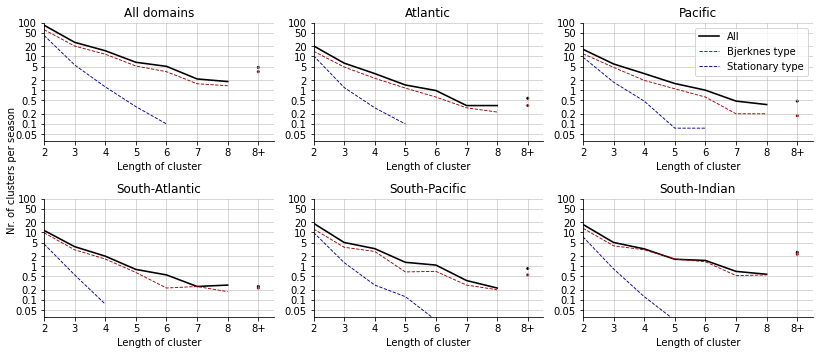

In [17]:

'''
plt.figure()
f, axs = plt.subplots(2, 3, sharey=True)
plt.subplots_adjust(hspace=0.45)
axs[0,0].bar(range(1,maxLength+1,1),lenAll[0:maxLength],log=True,color="dodgerblue")
axs[0,0].set_title("All")
strAll = "{:2.2f}".format(avAll)
axs[0,0].text(0.95, 0.95, strAll,
        verticalalignment='top', horizontalalignment='right',
        transform=axs[0,0].transAxes,
        color='dodgerblue', fontsize=8)
axs[0,1].bar(range(1,maxLength+1,1),lenAtlantic[0:maxLength],log=True,color="dodgerblue")
axs[0,1].set_title("Atlantic")
strAtl = "{:2.2f}".format(avAtlantic)
axs[0,1].text(0.95, 0.95, strAtl,
        verticalalignment='top', horizontalalignment='right',
        transform=axs[0,1].transAxes,
        color='dodgerblue', fontsize=8)
axs[0,2].bar(range(1,maxLength+1,1),lenPacific[0:maxLength],log=True,color="dodgerblue")
axs[0,2].set_title("Pacific")
strPac = "{:2.2f}".format(avPacific)
axs[0,2].text(0.95, 0.95, strPac,
        verticalalignment='top', horizontalalignment='right',
        transform=axs[0,2].transAxes,
        color='dodgerblue', fontsize=8)
axs[1,0].bar(range(1,maxLength+1,1),lenSAtlantic[0:maxLength],log=True,color="dodgerblue")
axs[1,0].set_title("South Atlantic")
strSAtl = "{:2.2f}".format(avSAtlantic)
axs[1,0].text(0.95, 0.95, strSAtl,
        verticalalignment='top', horizontalalignment='right',
        transform=axs[1,0].transAxes,
        color='dodgerblue', fontsize=8)
axs[1,1].bar(range(1,maxLength+1,1),lenSPacific[0:maxLength],log=True,color="dodgerblue")
axs[1,1].set_title("South Pacific")
strSPac = "{:2.2f}".format(avSPacific)
axs[1,1].text(0.95, 0.95, strSPac,
        verticalalignment='top', horizontalalignment='right',
        transform=axs[1,1].transAxes,
        color='dodgerblue', fontsize=8)
axs[1,2].bar(range(1,maxLength+1,1),lenSIndian[0:maxLength],log=True,color="dodgerblue")
axs[1,2].set_title("South Indian")
strSInd = "{:2.2f}".format(avSIndian)
axs[1,2].text(0.95, 0.95, strSInd,
        verticalalignment='top', horizontalalignment='right',
        transform=axs[1,2].transAxes,
        color='dodgerblue', fontsize=8)
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Length of cluster")
plt.ylabel("Count")
plt.savefig("ClustersLength_Areas_"+ Options["whichClusters"] + ".pdf")


def discrete_matshow(data):
    # get discrete colormap
    cmap = plt.get_cmap('RdBu', np.nanmax(data) - np.nanmin(data) + 1)
    # set limits .5 outside true range
    mat = plt.matshow(data, cmap=cmap, vmin=np.min(data) - 0.5, 
                      vmax=np.max(data) + 0.5)
    # tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(np.nanmin(data), np.nanmax(data) + 1))

# generate data
data = np.log10(arrayLengths)
data[np.isinf(data)] = np.nan
plt.figure()
a = np.random.randint(1, 9, size=(10, 10))
discrete_matshow(data)
plt.savefig("Testing.png")
'''

#OLD 
'''
lenAll = lenAtlantic + lenPacific + lenSAtlantic + lenSPacific + lenSIndian
arrayLengths = np.zeros((6,14))
arrayLengths[0,::] = lenAll[1:(maxLength+1)]
arrayLengths[1,::] = lenAtlantic[1:(maxLength+1)]
arrayLengths[2,::] = lenPacific[1:(maxLength+1)]
arrayLengths[3,::] = lenSAtlantic[1:(maxLength+1)]
arrayLengths[4,::] = lenSPacific[1:(maxLength+1)]
arrayLengths[5,::] = lenSIndian[1:(maxLength+1)]

fig = plt.figure(figsize=(12,2.67))
ax = plt.subplot(1, 1, 1)
data = np.log10(arrayLengths)
data[np.isinf(data)] = np.nan
plt.rcParams['font.sans-serif'] = ['Verdana'] #,'Arial','Verdana','Helvetica']
#["black",'xkcd:baby puke green','firebrick','darkblue','xkcd:rich purple','xkcd:pumpkin']
ax.set_prop_cycle(color=["black",'xkcd:deep red','darkblue','xkcd:pumpkin','xkcd:sky blue','xkcd:grass green'],
linewidth=[1.6,0.9,0.9,0.9,0.9,0.9],linestyle=['-','--','--','-','-','-'])
ax.plot(np.arange(2,maxLength+1,1),np.transpose(data))
ax.set_xticks(np.arange(2,21,1))
yvals = [1,2,5,10,20,50,100,200,500,1000,2000,5000,10000,20000,50000,100000]
yvals_log10 = np.log10(yvals)
ax.set_yticks(yvals_log10) #np.arange(0, 5)
ax.set_yticklabels(yvals) #10.0**np.arange(0, 5)
ax.set_xlabel("Length of cluster")
ax.set_xlim(2,14)
ax.set_ylim(-.2,np.log10(5000))
ax.grid(linewidth = 0.5)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

plt.legend(labels=["All","North Atlantic","North Pacific","South Atlantic","South Pacific","South Indian"])
plt.tight_layout()
plt.savefig("ClustersLength_Areas_lines_" + Options["whichClusters"] + ".pdf")
'''

########################################################################
# New (per area)
########################################################################
xticks_labels = list(np.arange(2,maxLength,1))
xticks_labels = [str(x) for x in xticks_labels]
xticks_labels.extend(['8+'])

lenAll = lenAtlantic + lenPacific + lenSAtlantic + lenSPacific + lenSIndian
arrayLengths = np.zeros((3,maxLength-1))
arrayLengths[0,::] = lenAll[1:(maxLength+1)]
arrayLengths[1,::] = lenAll_length[1:(maxLength+1)]
arrayLengths[2,::] = lenAll_nolength[1:(maxLength+1)]

fig = plt.figure(figsize=(12,5.33))

#All domains
ax = plt.subplot(2, 3, 1)
data = np.log10(arrayLengths/40) #Per season
data[np.isinf(data)] = np.nan
plt.rcParams['font.sans-serif'] = ['Verdana'] #,'Arial','Verdana','Helvetica']
#["black",'xkcd:baby puke green','firebrick','darkblue','xkcd:rich purple','xkcd:pumpkin']
ax.set_prop_cycle(color=["black",'xkcd:deep red','darkblue'],
linewidth=[1.6,0.9,0.9],linestyle=['-','--','--'])
#ax.plot(np.arange(2,maxLength+1,1),np.transpose(data))
ax.plot(np.arange(2,maxLength,1),np.transpose(data[:,:-1]))
ax.scatter(np.repeat(maxLength,3),data[:,-1],s=4,color=["black",'xkcd:deep red','darkblue'])
ax.set_xticks(np.arange(2,maxLength+1,1))
ax.set_xticklabels(xticks_labels)
yvals = [0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]
yvals_log10 = np.log10(yvals)
ax.set_yticks(yvals_log10) #np.arange(0, 5)
ax.set_yticklabels(yvals) #10.0**np.arange(0, 5)
ax.set_xlabel("Length of cluster")
ax.set_xlim(2,maxLength + .5)
ax.set_ylim(-1.5,np.log10(100))
ax.grid(linewidth = 0.5)
ax.set_title("All domains")

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

#Atlantic
arrayLengths = np.zeros((3,maxLength-1))
arrayLengths[0,::] = lenAtlantic[1:(maxLength+1)]
arrayLengths[1,::] = lenAtlantic_length[1:(maxLength+1)]
arrayLengths[2,::] = lenAtlantic_nolength[1:(maxLength+1)]
ax = plt.subplot(2, 3, 2)
data = np.log10(arrayLengths/40) #Per season
data[np.isinf(data)] = np.nan
plt.rcParams['font.sans-serif'] = ['Verdana'] #,'Arial','Verdana','Helvetica']
#["black",'xkcd:baby puke green','firebrick','darkblue','xkcd:rich purple','xkcd:pumpkin']
ax.set_prop_cycle(color=["black",'xkcd:deep red','darkblue'],
linewidth=[1.6,0.9,0.9],linestyle=['-','--','--'])
ax.plot(np.arange(2,maxLength,1),np.transpose(data[:,:-1]))
ax.scatter(np.repeat(maxLength,3),data[:,-1],s=4,color=["black",'xkcd:deep red','darkblue'])
ax.set_xticks(np.arange(2,maxLength+1,1))
ax.set_xticklabels(xticks_labels)
yvals = [0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]
yvals_log10 = np.log10(yvals)
ax.set_yticks(yvals_log10) #np.arange(0, 5)
ax.set_yticklabels(yvals) #10.0**np.arange(0, 5)
ax.set_xlabel("Length of cluster")
ax.set_xlim(2,maxLength + .5)
ax.set_ylim(-1.5,np.log10(100))
ax.grid(linewidth = 0.5)
ax.set_title("Atlantic")

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

#Pacific
arrayLengths = np.zeros((3,maxLength-1))
arrayLengths[0,::] = lenPacific[1:(maxLength+1)]
arrayLengths[1,::] = lenPacific_length[1:(maxLength+1)]
arrayLengths[2,::] = lenPacific_nolength[1:(maxLength+1)]
ax = plt.subplot(2, 3, 3)
data = np.log10(arrayLengths/40) #Per season
data[np.isinf(data)] = np.nan
plt.rcParams['font.sans-serif'] = ['Verdana'] #,'Arial','Verdana','Helvetica']
#["black",'xkcd:baby puke green','firebrick','darkblue','xkcd:rich purple','xkcd:pumpkin']
ax.set_prop_cycle(color=["black",'xkcd:deep red','darkblue'],
linewidth=[1.6,0.9,0.9],linestyle=['-','--','--'])
ax.plot(np.arange(2,maxLength,1),np.transpose(data[:,:-1]))
ax.scatter(np.repeat(maxLength,3),data[:,-1],s=4,color=["black",'xkcd:deep red','darkblue'])
ax.set_xticks(np.arange(2,maxLength+1,1))
ax.set_xticklabels(xticks_labels)

yvals = [0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]
yvals_log10 = np.log10(yvals)
ax.set_yticks(yvals_log10) #np.arange(0, 5)
ax.set_yticklabels(yvals) #10.0**np.arange(0, 5)
ax.set_xlabel("Length of cluster")
ax.set_xlim(2,maxLength + .5)
ax.set_ylim(-1.5,np.log10(100))
ax.grid(linewidth = 0.5)
ax.set_title("Pacific")

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

plt.legend(labels=["All","Bjerknes type","Stationary type"])

#South-Atlantic
arrayLengths = np.zeros((3,maxLength-1))
arrayLengths[0,::] = lenSAtlantic[1:(maxLength+1)]
arrayLengths[1,::] = lenSAtlantic_length[1:(maxLength+1)]
arrayLengths[2,::] = lenSAtlantic_nolength[1:(maxLength+1)]
ax = plt.subplot(2, 3, 4)
data = np.log10(arrayLengths/40) #Per season
data[np.isinf(data)] = np.nan
plt.rcParams['font.sans-serif'] = ['Verdana'] #,'Arial','Verdana','Helvetica']
#["black",'xkcd:baby puke green','firebrick','darkblue','xkcd:rich purple','xkcd:pumpkin']
ax.set_prop_cycle(color=["black",'xkcd:deep red','darkblue'],
linewidth=[1.6,0.9,0.9],linestyle=['-','--','--'])
ax.plot(np.arange(2,maxLength,1),np.transpose(data[:,:-1]))
ax.scatter(np.repeat(maxLength,3),data[:,-1],s=4,color=["black",'xkcd:deep red','darkblue'])
ax.set_xticks(np.arange(2,maxLength+1,1))
ax.set_xticklabels(xticks_labels)
yvals = [0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]
yvals_log10 = np.log10(yvals)
ax.set_yticks(yvals_log10) #np.arange(0, 5)
ax.set_yticklabels(yvals) #10.0**np.arange(0, 5)
ax.set_xlabel("Length of cluster")
ax.set_xlim(2,maxLength + .5)
ax.set_ylim(-1.5,np.log10(100))
ax.grid(linewidth = 0.5)
ax.set_title("South-Atlantic")

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

#South-Pacific
arrayLengths = np.zeros((3,maxLength-1))
arrayLengths[0,::] = lenSPacific[1:(maxLength+1)]
arrayLengths[1,::] = lenSPacific_length[1:(maxLength+1)]
arrayLengths[2,::] = lenSPacific_nolength[1:(maxLength+1)]
ax = plt.subplot(2, 3, 5)
data = np.log10(arrayLengths/40) #Per season
data[np.isinf(data)] = np.nan
plt.rcParams['font.sans-serif'] = ['Verdana'] #,'Arial','Verdana','Helvetica']
#["black",'xkcd:baby puke green','firebrick','darkblue','xkcd:rich purple','xkcd:pumpkin']
ax.set_prop_cycle(color=["black",'xkcd:deep red','darkblue'],
linewidth=[1.6,0.9,0.9],linestyle=['-','--','--'])
ax.plot(np.arange(2,maxLength,1),np.transpose(data[:,:-1]))
ax.scatter(np.repeat(maxLength,3),data[:,-1],s=4,color=["black",'xkcd:deep red','darkblue'])
ax.set_xticks(np.arange(2,maxLength+1,1))
ax.set_xticklabels(xticks_labels)
yvals = [0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]
yvals_log10 = np.log10(yvals)
ax.set_yticks(yvals_log10) #np.arange(0, 5)
ax.set_yticklabels(yvals) #10.0**np.arange(0, 5)
ax.set_xlabel("Length of cluster")
ax.set_xlim(2,maxLength + .5)
ax.set_ylim(-1.5,np.log10(100))
ax.grid(linewidth = 0.5)
ax.set_title("South-Pacific")

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

#South-Indian
arrayLengths = np.zeros((3,maxLength-1))
arrayLengths[0,::] = lenSIndian[1:(maxLength+1)]
arrayLengths[1,::] = lenSIndian_length[1:(maxLength+1)]
arrayLengths[2,::] = lenSIndian_nolength[1:(maxLength+1)]
ax = plt.subplot(2, 3, 6)
data = np.log10(arrayLengths/40) #Per season
data[np.isinf(data)] = np.nan
plt.rcParams['font.sans-serif'] = ['Verdana'] #,'Arial','Verdana','Helvetica']
#["black",'xkcd:baby puke green','firebrick','darkblue','xkcd:rich purple','xkcd:pumpkin']
ax.set_prop_cycle(color=["black",'xkcd:deep red','darkblue'],
linewidth=[1.6,0.9,0.9],linestyle=['-','--','--'])
ax.plot(np.arange(2,maxLength,1),np.transpose(data[:,:-1]))
ax.scatter(np.repeat(maxLength,3),data[:,-1],s=4,color=["black",'xkcd:deep red','darkblue'])
ax.set_xticks(np.arange(2,maxLength+1,1))
ax.set_xticklabels(xticks_labels)
yvals = [0.05,0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1000]
yvals_log10 = np.log10(yvals)
ax.set_yticks(yvals_log10) #np.arange(0, 5)
ax.set_yticklabels(yvals) #10.0**np.arange(0, 5)
ax.set_xlabel("Length of cluster")
ax.set_xlim(2,maxLength + .5)
ax.set_ylim(-1.5,np.log10(100))
ax.grid(linewidth = 0.5)
ax.set_title("South-Indian")

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# BIG subplot for common label
axTot = fig.add_subplot(111,frameon=False)    # The big subplot
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

axTot.set_ylabel("Nr. of clusters per season")

plt.tight_layout()
plt.savefig("ClustersLength_Areas_lines_PerBasin_" + "lnght_" + str(Options["lngthresh"]) +
            "timlnght_" + str(Options["timlngthresh"]) + "_.pdf")


In [ ]:
data[:,-1]

In [23]:
############################################################################

############################################################################
# Determine Histogram of intensity/radius measures of clusters for each basin
############################################################################
#Subselect cyclone families and non-cyclone families
storms_Atlantic_solo = [item for sublist in sorted_clusters_Atlantic for item in sublist if (len(sublist) <= 3)]
storms_Pacific_solo = [item for sublist in sorted_clusters_Pacific for item in sublist if (len(sublist) <= 3)]
storms_sAtlantic_solo = [item for sublist in sorted_clusters_sAtlantic for item in sublist if (len(sublist) <= 3)]
storms_sPacific_solo = [item for sublist in sorted_clusters_sPacific for item in sublist if (len(sublist) <= 3)]
storms_sIndian_solo = [item for sublist in sorted_clusters_sIndian for item in sublist if (len(sublist) <= 3)]

storms_Atlantic_clust = [item for sublist in sorted_clusters_Atlantic for item in sublist if (len(sublist) > 3)]
storms_Pacific_clust = [item for sublist in sorted_clusters_Pacific for item in sublist if (len(sublist) > 3)]
storms_sAtlantic_clust = [item for sublist in sorted_clusters_sAtlantic for item in sublist if (len(sublist) > 3)]
storms_sPacific_clust = [item for sublist in sorted_clusters_sPacific for item in sublist if (len(sublist) > 3)]
storms_sIndian_clust = [item for sublist in sorted_clusters_sIndian for item in sublist if (len(sublist) > 3)]

storms_Atlantic = [item for sublist in sorted_clusters_Atlantic for item in sublist]
length_Atlantic = [len(sublist) for sublist in sorted_clusters_Atlantic for item in sublist]
storms_Pacific = [item for sublist in sorted_clusters_Pacific for item in sublist]
length_Pacific = [len(sublist) for sublist in sorted_clusters_Pacific for item in sublist]
storms_sAtlantic = [item for sublist in sorted_clusters_sAtlantic for item in sublist]
length_sAtlantic = [len(sublist) for sublist in sorted_clusters_sAtlantic for item in sublist]
storms_sPacific = [item for sublist in sorted_clusters_sPacific for item in sublist]
length_sPacific = [len(sublist) for sublist in sorted_clusters_sPacific for item in sublist]
storms_sIndian = [item for sublist in sorted_clusters_sIndian for item in sublist]
length_sIndian = [len(sublist) for sublist in sorted_clusters_sIndian for item in sublist]

#Define results arrays
pres_Atlantic = np.zeros(len(storms_Atlantic))
lapl_Atlantic = np.zeros(len(storms_Atlantic))
pres_Pacific = np.zeros(len(storms_Pacific))
lapl_Pacific = np.zeros(len(storms_Pacific))
pres_sAtlantic = np.zeros(len(storms_sAtlantic))
lapl_sAtlantic = np.zeros(len(storms_sAtlantic))
pres_sPacific = np.zeros(len(storms_sPacific))
lapl_sPacific = np.zeros(len(storms_sPacific))
pres_sIndian = np.zeros(len(storms_sIndian))
lapl_sIndian = np.zeros(len(storms_sIndian))
month_Atlantic = np.zeros(len(storms_Atlantic))
month_Pacific = np.zeros(len(storms_Pacific))
month_sAtlantic = np.zeros(len(storms_sAtlantic))
month_sPacific = np.zeros(len(storms_sPacific))
month_sIndian = np.zeros(len(storms_sIndian))
year_Atlantic = np.zeros(len(storms_Atlantic))
year_Pacific = np.zeros(len(storms_Pacific))
year_sAtlantic = np.zeros(len(storms_sAtlantic))
year_sPacific = np.zeros(len(storms_sPacific))
year_sIndian = np.zeros(len(storms_sIndian))
radi_Atlantic = np.zeros(len(storms_Atlantic))
radi_Pacific = np.zeros(len(storms_Pacific))
radi_sAtlantic = np.zeros(len(storms_sAtlantic))
radi_sPacific = np.zeros(len(storms_sPacific))
radi_sIndian = np.zeros(len(storms_sIndian))


pres_Atlantic_clust = np.zeros(len(storms_Atlantic_clust))
lapl_Atlantic_clust = np.zeros(len(storms_Atlantic_clust))
pres_Pacific_clust = np.zeros(len(storms_Pacific_clust))
lapl_Pacific_clust = np.zeros(len(storms_Pacific_clust))
pres_sAtlantic_clust = np.zeros(len(storms_sAtlantic_clust))
lapl_sAtlantic_clust = np.zeros(len(storms_sAtlantic_clust))
pres_sPacific_clust = np.zeros(len(storms_sPacific_clust))
lapl_sPacific_clust = np.zeros(len(storms_sPacific_clust))
pres_sIndian_clust = np.zeros(len(storms_sIndian_clust))
lapl_sIndian_clust = np.zeros(len(storms_sIndian_clust))

pres_Atlantic_solo = np.zeros(len(storms_Atlantic_solo))
lapl_Atlantic_solo = np.zeros(len(storms_Atlantic_solo))
pres_Pacific_solo = np.zeros(len(storms_Pacific_solo))
lapl_Pacific_solo = np.zeros(len(storms_Pacific_solo))
pres_sAtlantic_solo = np.zeros(len(storms_sAtlantic_solo))
lapl_sAtlantic_solo = np.zeros(len(storms_sAtlantic_solo))
pres_sPacific_solo = np.zeros(len(storms_sPacific_solo))
lapl_sPacific_solo = np.zeros(len(storms_sPacific_solo))
pres_sIndian_solo = np.zeros(len(storms_sIndian_solo))
lapl_sIndian_solo = np.zeros(len(storms_sIndian_solo))

radi_Atlantic_clust = np.zeros(len(storms_Atlantic_clust))
radi_Pacific_clust = np.zeros(len(storms_Pacific_clust))
radi_sAtlantic_clust = np.zeros(len(storms_sAtlantic_clust))
radi_sPacific_clust = np.zeros(len(storms_sPacific_clust))
radi_sIndian_clust = np.zeros(len(storms_sIndian_clust))

radi_Atlantic_solo = np.zeros(len(storms_Atlantic_solo))
radi_Pacific_solo = np.zeros(len(storms_Pacific_solo))
radi_sAtlantic_solo = np.zeros(len(storms_sAtlantic_solo))
radi_sPacific_solo = np.zeros(len(storms_sPacific_solo))
radi_sIndian_solo = np.zeros(len(storms_sIndian_solo))

month_Atlantic_clust = np.zeros(len(storms_Atlantic_clust))
month_Pacific_clust = np.zeros(len(storms_Pacific_clust))
month_sAtlantic_clust = np.zeros(len(storms_sAtlantic_clust))
month_sPacific_clust = np.zeros(len(storms_sPacific_clust))
month_sIndian_clust = np.zeros(len(storms_sIndian_clust))

month_Atlantic_solo = np.zeros(len(storms_Atlantic_solo))
month_Pacific_solo = np.zeros(len(storms_Pacific_solo))
month_sAtlantic_solo = np.zeros(len(storms_sAtlantic_solo))
month_sPacific_solo = np.zeros(len(storms_sPacific_solo))
month_sIndian_solo = np.zeros(len(storms_sIndian_solo))

year_Atlantic_clust = np.zeros(len(storms_Atlantic_clust))
year_Pacific_clust = np.zeros(len(storms_Pacific_clust))
year_sAtlantic_clust = np.zeros(len(storms_sAtlantic_clust))
year_sPacific_clust = np.zeros(len(storms_sPacific_clust))
year_sIndian_clust = np.zeros(len(storms_sIndian_clust))

year_Atlantic_solo = np.zeros(len(storms_Atlantic_solo))
year_Pacific_solo = np.zeros(len(storms_Pacific_solo))
year_sAtlantic_solo = np.zeros(len(storms_sAtlantic_solo))
year_sPacific_solo = np.zeros(len(storms_sPacific_solo))
year_sIndian_solo = np.zeros(len(storms_sIndian_solo))

#Intensification
int_Atlantic_clust = []
int_Pacific_clust = []
int_sAtlantic_clust = []
int_sPacific_clust = []
int_sIndian_clust = []

int_Atlantic_solo = []
int_Pacific_solo = []
int_sAtlantic_solo = []
int_sPacific_solo = []
int_sIndian_solo = []

for strm in range(len(storms_Atlantic)):
	pres_Atlantic[strm] = np.nanmin(str_pres[ids_storms[storms_Atlantic[strm]]])
	lapl_Atlantic[strm] = np.nanmax(str_lapl[ids_storms[storms_Atlantic[strm]]])
	radi_Atlantic[strm] = np.nanmean(str_radi[ids_storms[storms_Atlantic[strm]]])
	month_Atlantic[strm] = stats.mode(str_month[ids_storms[storms_Atlantic[strm]]])[0]
	year_Atlantic[strm] = stats.mode(str_year[ids_storms[storms_Atlantic[strm]]])[0]
	
	pres_temp = str_pres[ids_storms[storms_Atlantic[strm]]][1:] - str_pres[ids_storms[storms_Atlantic[strm]]][:-1]
	
	int_Atlantic_clust.append(pres_temp)

for strm in range(len(storms_Atlantic_clust)):
	pres_Atlantic_clust[strm] = np.nanmin(str_pres[ids_storms[storms_Atlantic_clust[strm]]])
	lapl_Atlantic_clust[strm] = np.nanmax(str_lapl[ids_storms[storms_Atlantic_clust[strm]]])
	radi_Atlantic_clust[strm] = np.nanmean(str_radi[ids_storms[storms_Atlantic_clust[strm]]])
	month_Atlantic_clust[strm] = stats.mode(str_month[ids_storms[storms_Atlantic_clust[strm]]])[0]
	year_Atlantic_clust[strm] = stats.mode(str_year[ids_storms[storms_Atlantic_clust[strm]]])[0]

for strm in range(len(storms_Atlantic_solo)):
	pres_Atlantic_solo[strm] = np.nanmin(str_pres[ids_storms[storms_Atlantic_solo[strm]]])
	lapl_Atlantic_solo[strm] = np.nanmax(str_lapl[ids_storms[storms_Atlantic_solo[strm]]])
	radi_Atlantic_solo[strm] = np.nanmean(str_radi[ids_storms[storms_Atlantic_solo[strm]]])
	month_Atlantic_solo[strm] = stats.mode(str_month[ids_storms[storms_Atlantic_solo[strm]]])[0]
	year_Atlantic_solo[strm] = stats.mode(str_year[ids_storms[storms_Atlantic_solo[strm]]])[0]

for strm in range(len(storms_Pacific)):
	pres_Pacific[strm] = np.nanmin(str_pres[ids_storms[storms_Pacific[strm]]])
	lapl_Pacific[strm] = np.nanmax(str_lapl[ids_storms[storms_Pacific[strm]]])
	radi_Pacific[strm] = np.nanmean(str_radi[ids_storms[storms_Pacific[strm]]])
	month_Pacific[strm] = stats.mode(str_month[ids_storms[storms_Pacific[strm]]])[0]
	year_Pacific[strm] = stats.mode(str_year[ids_storms[storms_Pacific[strm]]])[0]

for strm in range(len(storms_Pacific_clust)):
	pres_Pacific_clust[strm] = np.nanmin(str_pres[ids_storms[storms_Pacific_clust[strm]]])
	lapl_Pacific_clust[strm] = np.nanmax(str_lapl[ids_storms[storms_Pacific_clust[strm]]])
	radi_Pacific_clust[strm] = np.nanmean(str_radi[ids_storms[storms_Pacific_clust[strm]]])
	month_Pacific_clust[strm] = stats.mode(str_month[ids_storms[storms_Pacific_clust[strm]]])[0]
	year_Pacific_clust[strm] = stats.mode(str_year[ids_storms[storms_Pacific_clust[strm]]])[0]

for strm in range(len(storms_Pacific_solo)):
	pres_Pacific_solo[strm] = np.nanmin(str_pres[ids_storms[storms_Pacific_solo[strm]]])
	lapl_Pacific_solo[strm] = np.nanmax(str_lapl[ids_storms[storms_Pacific_solo[strm]]])
	radi_Pacific_solo[strm] = np.nanmean(str_radi[ids_storms[storms_Pacific_solo[strm]]])
	month_Pacific_solo[strm] = stats.mode(str_month[ids_storms[storms_Pacific_solo[strm]]])[0]
	year_Pacific_solo[strm] = stats.mode(str_year[ids_storms[storms_Pacific_solo[strm]]])[0]

for strm in range(len(storms_sAtlantic)):
	pres_sAtlantic[strm] = np.nanmin(str_pres[ids_storms[storms_sAtlantic[strm]]])
	lapl_sAtlantic[strm] = np.nanmax(str_lapl[ids_storms[storms_sAtlantic[strm]]])
	radi_sAtlantic[strm] = np.nanmean(str_radi[ids_storms[storms_sAtlantic[strm]]])
	month_sAtlantic[strm] = stats.mode(str_month[ids_storms[storms_sAtlantic[strm]]])[0]
	year_sAtlantic[strm] = stats.mode(str_year[ids_storms[storms_sAtlantic[strm]]])[0]

for strm in range(len(storms_sAtlantic_clust)):
	pres_sAtlantic_clust[strm] = np.nanmin(str_pres[ids_storms[storms_sAtlantic_clust[strm]]])
	lapl_sAtlantic_clust[strm] = np.nanmax(str_lapl[ids_storms[storms_sAtlantic_clust[strm]]])
	radi_sAtlantic_clust[strm] = np.nanmean(str_radi[ids_storms[storms_sAtlantic_clust[strm]]])
	month_sAtlantic_clust[strm] = stats.mode(str_month[ids_storms[storms_sAtlantic_clust[strm]]])[0]
	year_sAtlantic_clust[strm] = stats.mode(str_year[ids_storms[storms_sAtlantic_clust[strm]]])[0]

for strm in range(len(storms_sAtlantic_solo)):
	pres_sAtlantic_solo[strm] = np.nanmin(str_pres[ids_storms[storms_sAtlantic_solo[strm]]])
	lapl_sAtlantic_solo[strm] = np.nanmax(str_lapl[ids_storms[storms_sAtlantic_solo[strm]]])
	radi_sAtlantic_solo[strm] = np.nanmean(str_radi[ids_storms[storms_sAtlantic_solo[strm]]])
	month_sAtlantic_solo[strm] = stats.mode(str_month[ids_storms[storms_sAtlantic_solo[strm]]])[0]
	year_sAtlantic_solo[strm] = stats.mode(str_year[ids_storms[storms_sAtlantic_solo[strm]]])[0]

for strm in range(len(storms_sPacific)):
	pres_sPacific[strm] = np.nanmin(str_pres[ids_storms[storms_sPacific[strm]]])
	lapl_sPacific[strm] = np.nanmax(str_lapl[ids_storms[storms_sPacific[strm]]])
	radi_sPacific[strm] = np.nanmean(str_radi[ids_storms[storms_sPacific[strm]]])
	month_sPacific[strm] = stats.mode(str_month[ids_storms[storms_sPacific[strm]]])[0]
	year_sPacific[strm] = stats.mode(str_year[ids_storms[storms_sPacific[strm]]])[0]

for strm in range(len(storms_sPacific_clust)):
	pres_sPacific_clust[strm] = np.nanmin(str_pres[ids_storms[storms_sPacific_clust[strm]]])
	lapl_sPacific_clust[strm] = np.nanmax(str_lapl[ids_storms[storms_sPacific_clust[strm]]])
	radi_sPacific_clust[strm] = np.nanmean(str_radi[ids_storms[storms_sPacific_clust[strm]]])
	month_sPacific_clust[strm] = stats.mode(str_month[ids_storms[storms_sPacific_clust[strm]]])[0]
	year_sPacific_clust[strm] = stats.mode(str_year[ids_storms[storms_sPacific_clust[strm]]])[0]

for strm in range(len(storms_sPacific_solo)):
	pres_sPacific_solo[strm] = np.nanmin(str_pres[ids_storms[storms_sPacific_solo[strm]]])
	lapl_sPacific_solo[strm] = np.nanmax(str_lapl[ids_storms[storms_sPacific_solo[strm]]])
	radi_sPacific_solo[strm] = np.nanmean(str_radi[ids_storms[storms_sPacific_solo[strm]]])
	month_sPacific_solo[strm] = stats.mode(str_month[ids_storms[storms_sPacific_solo[strm]]])[0]
	year_sPacific_solo[strm] = stats.mode(str_year[ids_storms[storms_sPacific_solo[strm]]])[0]

for strm in range(len(storms_sIndian)):
	pres_sIndian[strm] = np.nanmin(str_pres[ids_storms[storms_sIndian[strm]]])
	lapl_sIndian[strm] = np.nanmax(str_lapl[ids_storms[storms_sIndian[strm]]])
	radi_sIndian[strm] = np.nanmean(str_radi[ids_storms[storms_sIndian[strm]]])
	month_sIndian[strm] = stats.mode(str_month[ids_storms[storms_sIndian[strm]]])[0]
	year_sIndian[strm] = stats.mode(str_year[ids_storms[storms_sIndian[strm]]])[0]

for strm in range(len(storms_sIndian_clust)):
	pres_sIndian_clust[strm] = np.nanmin(str_pres[ids_storms[storms_sIndian_clust[strm]]])
	lapl_sIndian_clust[strm] = np.nanmax(str_lapl[ids_storms[storms_sIndian_clust[strm]]])
	radi_sIndian_clust[strm] = np.nanmean(str_radi[ids_storms[storms_sIndian_clust[strm]]])
	month_sIndian_clust[strm] = stats.mode(str_month[ids_storms[storms_sIndian_clust[strm]]])[0]
	year_sIndian_clust[strm] = stats.mode(str_year[ids_storms[storms_sIndian_clust[strm]]])[0]

for strm in range(len(storms_sIndian_solo)):
	pres_sIndian_solo[strm] = np.nanmin(str_pres[ids_storms[storms_sIndian_solo[strm]]])
	lapl_sIndian_solo[strm] = np.nanmax(str_lapl[ids_storms[storms_sIndian_solo[strm]]])
	radi_sIndian_solo[strm] = np.nanmean(str_radi[ids_storms[storms_sIndian_solo[strm]]])
	month_sIndian_solo[strm] = stats.mode(str_month[ids_storms[storms_sIndian_solo[strm]]])[0]
	year_sIndian_solo[strm] = stats.mode(str_year[ids_storms[storms_sIndian_solo[strm]]])[0]

pres_All = np.hstack((pres_Atlantic,pres_Pacific,pres_sAtlantic,pres_sPacific,pres_sIndian))
length_All = np.hstack((length_Atlantic,length_Pacific,length_sAtlantic,length_sPacific,length_sIndian))
pres_All_clust = np.hstack((pres_Atlantic_clust,pres_Pacific_clust,pres_sAtlantic_clust,pres_sPacific_clust,pres_sIndian_clust))
pres_All_solo = np.hstack((pres_Atlantic_solo,pres_Pacific_solo,pres_sAtlantic_solo,pres_sPacific_solo,pres_sIndian_solo))

lapl_All = np.hstack((lapl_Atlantic,lapl_Pacific,lapl_sAtlantic,lapl_sPacific,lapl_sIndian))
lapl_All_clust = np.hstack((lapl_Atlantic_clust,lapl_Pacific_clust,lapl_sAtlantic_clust,lapl_sPacific_clust,lapl_sIndian_clust))
lapl_All_solo = np.hstack((lapl_Atlantic_solo,lapl_Pacific_solo,lapl_sAtlantic_solo,lapl_sPacific_solo,lapl_sIndian_solo))

radi_All_clust = np.hstack((radi_Atlantic_clust,radi_Pacific_clust,radi_sAtlantic_clust,radi_sPacific_clust,radi_sIndian_clust))
radi_All_solo = np.hstack((radi_Atlantic_solo,radi_Pacific_solo,radi_sAtlantic_solo,radi_sPacific_solo,radi_sIndian_solo))

month_All = np.hstack(((month_Atlantic+6)%12,(month_Pacific+6)%12,month_sAtlantic,month_sPacific,month_sIndian))
month_All_clust = np.hstack((month_Atlantic_clust,month_Pacific_clust,month_sAtlantic_clust,month_sPacific_clust,month_sIndian_clust))
month_All_solo = np.hstack((month_Atlantic_solo,month_Pacific_solo,month_sAtlantic_solo,month_sPacific_solo,month_sIndian_solo))

year_All_clust = np.hstack((year_Atlantic_clust,year_Pacific_clust,year_sAtlantic_clust,year_sPacific_clust,year_sIndian_clust))
year_All_solo = np.hstack((year_Atlantic_solo,year_Pacific_solo,year_sAtlantic_solo,year_sPacific_solo,year_sIndian_solo))


#################
# PDF with min. pressure, only strongest cyclone per family
#################
laplstep = .5
laplBins_mid = np.arange(2.0,9.1,laplstep)
laplBins = np.arange(1.75,9.26,laplstep)

pdfAll = np.zeros((10,len(laplBins_mid)))
pdfAtlantic = np.zeros((10,len(laplBins_mid)))
pdfPacific = np.zeros((10,len(laplBins_mid)))
pdfsAtlantic = np.zeros((10,len(laplBins_mid)))
pdfsPacific = np.zeros((10,len(laplBins_mid)))
pdfsIndian = np.zeros((10,len(laplBins_mid)))

quantsAll = np.zeros((10,3))
quantsAtlantic = np.zeros((10,3))
quantsPacific = np.zeros((10,3))
quantsSAtlantic = np.zeros((10,3))
quantsSPacific = np.zeros((10,3))
quantsSIndian = np.zeros((10,3))

quantsAll_Expect = np.zeros((10,3))
quantsAtlantic_Expect = np.zeros((10,3))
quantsPacific_Expect = np.zeros((10,3))
quantsSAtlantic_Expect = np.zeros((10,3))
quantsSPacific_Expect = np.zeros((10,3))
quantsSIndian_Expect = np.zeros((10,3))

'''
for l in range(10):
	if(l < 9):
		laplTempAtlantic = [np.nanmax(lapl_Atlantic[np.array([np.where(np.array(storms_Atlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Atlantic if len(sublist) == l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific[np.array([np.where(np.array(storms_Pacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Pacific if len(sublist) == l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic[np.array([np.where(np.array(storms_sAtlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sAtlantic if len(sublist) == l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific[np.array([np.where(np.array(storms_sPacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sPacific if len(sublist) == l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian[np.array([np.where(np.array(storms_sIndian) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sIndian if len(sublist) == l + 1]

	else:
		laplTempAtlantic = [np.nanmax(lapl_Atlantic[np.array([np.where(np.array(storms_Atlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Atlantic if len(sublist) >= l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific[np.array([np.where(np.array(storms_Pacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Pacific if len(sublist) >= l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic[np.array([np.where(np.array(storms_sAtlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sAtlantic if len(sublist) >= l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific[np.array([np.where(np.array(storms_sPacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sPacific if len(sublist) >= l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian[np.array([np.where(np.array(storms_sIndian) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sIndian if len(sublist) >= l + 1]
	laplTempAll = np.hstack((laplTempAtlantic,laplTempPacific,laplTempsAtlantic,laplTempsPacific,laplTempsIndian))
	pdfAll[l,::] = np.histogram(laplTempAll,bins=laplBins,normed=True)[0]*laplstep
	pdfAtlantic[l,::] = np.histogram(laplTempAtlantic,bins=laplBins,normed=True)[0]*laplstep
	pdfPacific[l,::] = np.histogram(laplTempPacific,bins=laplBins,normed=True)[0]*laplstep
	pdfsAtlantic[l,::] = np.histogram(laplTempsAtlantic,bins=laplBins,normed=True)[0]*laplstep
	pdfsPacific[l,::] = np.histogram(laplTempsPacific,bins=laplBins,normed=True)[0]*laplstep
	pdfsIndian[l,::] = np.histogram(laplTempsIndian,bins=laplBins,normed=True)[0]*laplstep
	quantsAll[l,::] = np.quantile(laplTempAll,[0.1,0.5,0.9])	
	quantsAtlantic[l,::] =  np.quantile(laplTempAtlantic,[0.1,0.5,0.9])
	quantsPacific[l,::] = np.quantile(laplTempPacific,[0.1,0.5,0.9])
	quantsSAtlantic[l,::] = np.quantile(laplTempsAtlantic,[0.1,0.5,0.9])
	quantsSPacific[l,::] = np.quantile(laplTempsPacific,[0.1,0.5,0.9])
	quantsSIndian[l,::] = np.quantile(laplTempsIndian,[0.1,0.5,0.9])


	TempAll = np.zeros(10000)
	TempAtlantic = np.zeros(10000)
	TempPacific = np.zeros(10000)
	TempsAtlantic = np.zeros(10000)
	TempsPacific = np.zeros(10000)
	TempsIndian = np.zeros(10000)

	for i in range(10000):
		TempAll[i] =np.nanmax(random.sample(list(lapl_All),l+1))
		TempAtlantic[i] =np.nanmax(random.sample(list(lapl_Atlantic),l+1))
		TempPacific[i] =np.nanmax(random.sample(list(lapl_Pacific),l+1))
		TempsAtlantic[i] =np.nanmax(random.sample(list(lapl_sAtlantic),l+1))
		TempsPacific[i] =np.nanmax(random.sample(list(lapl_sPacific),l+1))
		TempsIndian[i] =np.nanmax(random.sample(list(lapl_sIndian),l+1))

	quantsAll_Expect[l,::] = np.quantile(TempAll,[0.1,0.5,0.9])	
	quantsAtlantic_Expect[l,::] =  np.quantile(TempAtlantic,[0.1,0.5,0.9])
	quantsPacific_Expect[l,::] = np.quantile(TempPacific,[0.1,0.5,0.9])
	quantsSAtlantic_Expect[l,::] = np.quantile(TempsAtlantic,[0.1,0.5,0.9])
	quantsSPacific_Expect[l,::] = np.quantile(TempsPacific,[0.1,0.5,0.9])
	quantsSIndian_Expect[l,::] = np.quantile(TempsIndian,[0.1,0.5,0.9])





#laplBins = np.arange(920,1025.1,2.5)
plt.figure()
f, axs = plt.subplots(2, 3, sharey=False)
f.set_figheight(4.0)
f.set_figwidth(10.0)
plt.subplots_adjust(hspace=0.4,wspace=.25)
im = axs[0,0].contourf(laplBins_mid,range(1,11),pdfAll,cmap="RdBu_r")
axs[0,0].plot(quantsAll[:,1],range(1,11),color="k",linewidth=1.5)
axs[0,0].plot(quantsAll_Expect[:,1],range(1,11),color="blue",linewidth=1.5)
axs[0,0].plot(quantsAll[:,0],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
axs[0,0].plot(quantsAll[:,2],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
axs[0,0].set_title("All")

axs[0,1].contourf(laplBins_mid,range(1,11),pdfAtlantic,cmap="RdBu_r")
axs[0,1].set_title("Atlantic")
axs[0,1].plot(quantsAtlantic[:,1],range(1,11),color="k",linewidth=1.5)
axs[0,1].plot(quantsAtlantic_Expect[:,1],range(1,11),color="blue",linewidth=1.5)
axs[0,1].plot(quantsAtlantic[:,0],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
axs[0,1].plot(quantsAtlantic[:,2],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
strAtl = "{:2.2f}".format(np.nanmean(lapl_Atlantic_solo))
strAtlclust = "{:2.2f}".format(np.nanmean(lapl_Atlantic_clust))

axs[0,2].contourf(laplBins_mid,range(1,11),pdfPacific,cmap="RdBu_r")
axs[0,2].set_title("Pacific")
axs[0,2].plot(quantsPacific[:,1],range(1,11),color="k",linewidth=1.5)
axs[0,2].plot(quantsPacific_Expect[:,1],range(1,11),color="blue",linewidth=1.5)
axs[0,2].plot(quantsPacific[:,0],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
axs[0,2].plot(quantsPacific[:,2],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
strPac = "{:2.2f}".format(np.nanmean(lapl_Pacific_solo))
strPacclust = "{:2.2f}".format(np.nanmean(lapl_Pacific_clust))

axs[1,0].contourf(laplBins_mid,range(1,11),pdfsAtlantic,cmap="RdBu_r")
axs[1,0].set_title("South Atlantic")
axs[1,0].plot(quantsSAtlantic[:,1],range(1,11),color="k",linewidth=1.5)
axs[1,0].plot(quantsSAtlantic_Expect[:,1],range(1,11),color="blue",linewidth=1.5)
axs[1,0].plot(quantsSAtlantic[:,0],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
axs[1,0].plot(quantsSAtlantic[:,2],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
strSAtl = "{:2.2f}".format(np.nanmean(lapl_sAtlantic_solo))
strSAtlclust = "{:2.2f}".format(np.nanmean(lapl_sAtlantic_clust))

axs[1,1].contourf(laplBins_mid,range(1,11),pdfsPacific,cmap="RdBu_r")
axs[1,1].set_title("South Pacific")
axs[1,1].plot(quantsSPacific[:,1],range(1,11),color="k",linewidth=1.5)
axs[1,1].plot(quantsSPacific_Expect[:,1],range(1,11),color="blue",linewidth=1.5)
axs[1,1].plot(quantsSPacific[:,0],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
axs[1,1].plot(quantsSPacific[:,2],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
strSPac = "{:2.2f}".format(np.nanmean(lapl_sPacific_solo))
strSPacclust = "{:2.2f}".format(np.nanmean(lapl_sPacific_clust))

axs[1,2].contourf(laplBins_mid,range(1,11),pdfsIndian,cmap="RdBu_r")
axs[1,2].set_title("South Indian")
axs[1,2].plot(quantsSIndian[:,1],range(1,11),color="k",linewidth=1.5)
axs[1,2].plot(quantsSIndian_Expect[:,1],range(1,11),color="blue",linewidth=1.5)
axs[1,2].plot(quantsSIndian[:,0],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
axs[1,2].plot(quantsSIndian[:,2],range(1,11),color="k",linewidth=1.5,linestyle="dashed")
strSInd = "{:2.2f}".format(np.nanmean(lapl_sIndian_solo))
strSIndclust = "{:2.2f}".format(np.nanmean(lapl_sIndian_clust))

# Add color bar
f.subplots_adjust(right=0.875)
cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
f.colorbar(im, cax=cbar_ax)

# Add xlabel and ylabel
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Maximum Laplacian of storm")
plt.ylabel("Count")

plt.savefig("MaxLaplPdfAreas" + reschar + "_StrongestCyclones_"+ Options["whichClusters"] + ".pdf")

'''
### BOXPLOTS ####
# each plot returns a dictionary, use plt.setp()
# function to assign the color code
# for all properties of the box plot of particular group
# use the below function to set color for particular group,
# by iterating over all properties of the box plot
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
         
    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label)
    plt.legend(bbox_to_anchor=(1.1, 0.75))
 


### BOXPLOTS ####
boxplotsAll = []
boxplotsAtlantic = []
boxplotsPacific = []
boxplotsSAtlantic = []
boxplotsSPacific = []
boxplotsSIndian = []

quantsAll_Expect = np.zeros((10,3))
quantsAtlantic_Expect = np.zeros((10,3))
quantsPacific_Expect = np.zeros((10,3))
quantsSAtlantic_Expect = np.zeros((10,3))
quantsSPacific_Expect = np.zeros((10,3))
quantsSIndian_Expect = np.zeros((10,3))

maxstorms = 10
# the list named ticks, summarizes or groups
ticks = ['Solo', '2', '3','4','5','6','7','8','9','10+']

if(Options["whichClusters"] == "nolength"):
    maxstorms = 8
    # the list named ticks, summarizes or groups
    ticks = ['Solo', '2', '3','4','5','6','7','8+','','']


for l in range(maxstorms):
	if(l < maxstorms - 1):
		laplTempAtlantic = [np.nanmax(lapl_Atlantic[np.array([np.where(np.array(storms_Atlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Atlantic if len(sublist) == l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific[np.array([np.where(np.array(storms_Pacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Pacific if len(sublist) == l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic[np.array([np.where(np.array(storms_sAtlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sAtlantic if len(sublist) == l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific[np.array([np.where(np.array(storms_sPacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sPacific if len(sublist) == l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian[np.array([np.where(np.array(storms_sIndian) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sIndian if len(sublist) == l + 1]

	else:
		laplTempAtlantic = [np.nanmax(lapl_Atlantic[np.array([np.where(np.array(storms_Atlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Atlantic if len(sublist) >= l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific[np.array([np.where(np.array(storms_Pacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Pacific if len(sublist) >= l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic[np.array([np.where(np.array(storms_sAtlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sAtlantic if len(sublist) >= l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific[np.array([np.where(np.array(storms_sPacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sPacific if len(sublist) >= l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian[np.array([np.where(np.array(storms_sIndian) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sIndian if len(sublist) >= l + 1]
	laplTempAll = np.hstack((laplTempAtlantic,laplTempPacific,laplTempsAtlantic,laplTempsPacific,laplTempsIndian))
	boxplotsAll.append(laplTempAll)
	boxplotsAtlantic.append(laplTempAtlantic)
	boxplotsPacific.append(laplTempPacific)
	boxplotsSAtlantic.append(laplTempsAtlantic)
	boxplotsSPacific.append(laplTempsPacific)
	boxplotsSIndian.append(laplTempsIndian)
	
	
	TempAll = np.zeros(10000)
	TempAtlantic = np.zeros(10000)
	TempPacific = np.zeros(10000)
	TempsAtlantic = np.zeros(10000)
	TempsPacific = np.zeros(10000)
	TempsIndian = np.zeros(10000)

	for i in range(10000):
		TempAll[i] =np.nanmax(random.sample(list(lapl_All),l+1))
		TempAtlantic[i] =np.nanmax(random.sample(list(lapl_Atlantic),l+1))
		TempPacific[i] =np.nanmax(random.sample(list(lapl_Pacific),l+1))
		TempsAtlantic[i] =np.nanmax(random.sample(list(lapl_sAtlantic),l+1))
		TempsPacific[i] =np.nanmax(random.sample(list(lapl_sPacific),l+1))
		TempsIndian[i] =np.nanmax(random.sample(list(lapl_sIndian),l+1))

	quantsAll_Expect[l,::] = np.quantile(TempAll,[0.1,0.5,0.9])	
	quantsAtlantic_Expect[l,::] =  np.quantile(TempAtlantic,[0.1,0.5,0.9])
	quantsPacific_Expect[l,::] = np.quantile(TempPacific,[0.1,0.5,0.9])
	quantsSAtlantic_Expect[l,::] = np.quantile(TempsAtlantic,[0.1,0.5,0.9])
	quantsSPacific_Expect[l,::] = np.quantile(TempsPacific,[0.1,0.5,0.9])
	quantsSIndian_Expect[l,::] = np.quantile(TempsIndian,[0.1,0.5,0.9])

if(Options["whichClusters"] == "nolength"):
	for l in range(8,10):
		boxplotsAll.append([])
		boxplotsAtlantic.append([])
		boxplotsPacific.append([])
		boxplotsSAtlantic.append([])
		boxplotsSPacific.append([])
		boxplotsSIndian.append([])
	
		quantsAll_Expect[l,::] = np.nan
		quantsAtlantic_Expect[l,::] =  np.nan
		quantsPacific_Expect[l,::] = np.nan
		quantsSAtlantic_Expect[l,::] = np.nan
		quantsSPacific_Expect[l,::] = np.nan
		quantsSIndian_Expect[l,::] = np.nan
	



SyntaxError: invalid syntax (<ipython-input-23-926ed472de6b>, line 578)

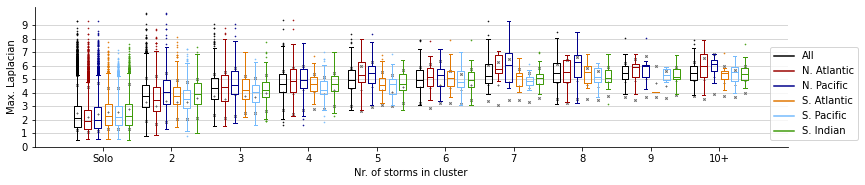

In [24]:


### BOX PLOTS
fig = plt.figure(figsize=(12,2.67))
ax = plt.subplot(1, 1, 1)
bxplotAll = plt.boxplot(boxplotsAll, positions=np.array(np.arange(len(boxplotsAll)))*2.0-0.75, widths=0.2, flierprops=dict(markeredgecolor='black',markersize=0.6))
bxplotAtl = plt.boxplot(boxplotsAtlantic, positions=np.array(np.arange(len(boxplotsAll)))*2.0-0.45, widths=0.2, flierprops=dict(markeredgecolor='#9a0200',markersize=0.6))
bxplotPac = plt.boxplot(boxplotsPacific, positions=np.array(np.arange(len(boxplotsAll)))*2.0-0.15, widths=0.2,flierprops=dict(markeredgecolor='darkblue',markersize=0.6))
bxplotSAtl = plt.boxplot(boxplotsSAtlantic, positions=np.array(np.arange(len(boxplotsAll)))*2.0+0.15, widths=0.2,flierprops=dict(markeredgecolor='#e17701',markersize=0.6))
bxplotSPac = plt.boxplot(boxplotsSPacific, positions=np.array(np.arange(len(boxplotsAll)))*2.0+0.45, widths=0.2,flierprops=dict(markeredgecolor='#75bbfd',markersize=0.6))
bxplotSIndi = plt.boxplot(boxplotsSIndian, positions=np.array(np.arange(len(boxplotsAll)))*2.0+0.75, widths=0.2,flierprops=dict(markeredgecolor='#3f9b0b',markersize=0.6))

# setting colors for each groups
# =["black",'xkcd:deep red','darkblue','xkcd:pumpkin','xkcd:sky blue','xkcd:grass green'],
define_box_properties(bxplotAll, 'black', 'All')
define_box_properties(bxplotAtl, '#9a0200', 'N. Atlantic')
define_box_properties(bxplotPac, 'darkblue', 'N. Pacific')
define_box_properties(bxplotSAtl, '#e17701', 'S. Atlantic') #e17701
define_box_properties(bxplotSPac, '#75bbfd', 'S. Pacific')
define_box_properties(bxplotSIndi, '#3f9b0b', 'S. Indian')

# Add results from random sampling
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.75,quantsAll_Expect[:,0],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.75,quantsAll_Expect[:,1],marker='+',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.75,quantsAll_Expect[:,2],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
#NH
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.45,quantsAtlantic_Expect[:,0],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.45,quantsAtlantic_Expect[:,1],marker='+',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.45,quantsAtlantic_Expect[:,2],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.15,quantsPacific_Expect[:,0],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.15,quantsPacific_Expect[:,1],marker='+',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0-0.15,quantsPacific_Expect[:,2],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
#SH
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.15,quantsSAtlantic_Expect[:,0],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.15,quantsSAtlantic_Expect[:,1],marker='+',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.15,quantsSAtlantic_Expect[:,2],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.45,quantsSPacific_Expect[:,0],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.45,quantsSPacific_Expect[:,1],marker='+',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.45,quantsSPacific_Expect[:,2],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.75,quantsSIndian_Expect[:,0],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.75,quantsSIndian_Expect[:,1],marker='+',color="dimgrey",s=6,linewidth=1,zorder=2)
plt.scatter(np.array(np.arange(len(boxplotsAll)))*2.0+0.75,quantsSIndian_Expect[:,2],marker='x',color="dimgrey",s=6,linewidth=1,zorder=2)

# set the x label values
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
ax.set_yticks(np.arange(0,10)) #np.arange(0, 5)

#X -Y labels
plt.ylabel("Max. Laplacian")
plt.xlabel("Nr. of storms in cluster")
 
# set the limit for x axis
plt.xlim(-2, len(ticks)*2)

# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False)

# Add gridlines
ax.grid(linewidth=0.5,axis='y',zorder=0)

plt.tight_layout()
plt.savefig("Boxplots_"+ Options["whichClusters"] + ".pdf")

In [28]:
############
# PDF with min. pressure, only strongest cyclone per family
#################
laplstep = .5
laplBins_mid = np.arange(2.0,9.1,laplstep)
laplBins = np.arange(1.75,9.26,laplstep)

pdfAll = np.zeros((maxLength,len(laplBins_mid)))
pdfAtlantic = np.zeros((maxLength,len(laplBins_mid)))
pdfPacific = np.zeros((maxLength,len(laplBins_mid)))
pdfsAtlantic = np.zeros((maxLength,len(laplBins_mid)))
pdfsPacific = np.zeros((maxLength,len(laplBins_mid)))
pdfsIndian = np.zeros((maxLength,len(laplBins_mid)))

quantsAll = np.zeros((maxLength,3))
quantsAtlantic = np.zeros((maxLength,3))
quantsPacific = np.zeros((maxLength,3))
quantsSAtlantic = np.zeros((maxLength,3))
quantsSPacific = np.zeros((maxLength,3))
quantsSIndian = np.zeros((maxLength,3))

quantsAll_Expect = np.zeros((maxLength,3))
quantsAtlantic_Expect = np.zeros((maxLength,3))
quantsPacific_Expect = np.zeros((maxLength,3))
quantsSAtlantic_Expect = np.zeros((maxLength,3))
quantsSPacific_Expect = np.zeros((maxLength,3))
quantsSIndian_Expect = np.zeros((maxLength,3))


for l in range(9):
	if(l < 8):
		laplTempAtlantic = [np.nanmax(lapl_Atlantic[np.array([np.where(np.array(storms_Atlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Atlantic if len(sublist) == l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific[np.array([np.where(np.array(storms_Pacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Pacific if len(sublist) == l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic[np.array([np.where(np.array(storms_sAtlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sAtlantic if len(sublist) == l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific[np.array([np.where(np.array(storms_sPacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sPacific if len(sublist) == l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian[np.array([np.where(np.array(storms_sIndian) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sIndian if len(sublist) == l + 1]

	else:
		laplTempAtlantic = [np.nanmax(lapl_Atlantic[np.array([np.where(np.array(storms_Atlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Atlantic if len(sublist) >= l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific[np.array([np.where(np.array(storms_Pacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_Pacific if len(sublist) >= l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic[np.array([np.where(np.array(storms_sAtlantic) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sAtlantic if len(sublist) >= l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific[np.array([np.where(np.array(storms_sPacific) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sPacific if len(sublist) >= l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian[np.array([np.where(np.array(storms_sIndian) == item)[0] for item in sublist])]) for sublist in sorted_clusters_sIndian if len(sublist) >= l + 1]
	laplTempAll = np.hstack((laplTempAtlantic,laplTempPacific,laplTempsAtlantic,laplTempsPacific,laplTempsIndian))
    
	pdfAll[l,::] = np.histogram(laplTempAll,bins=laplBins,normed=True)[0]*laplstep
	pdfAtlantic[l,::] = np.histogram(laplTempAtlantic,bins=laplBins,normed=True)[0]*laplstep
	pdfPacific[l,::] = np.histogram(laplTempPacific,bins=laplBins,normed=True)[0]*laplstep
	pdfsAtlantic[l,::] = np.histogram(laplTempsAtlantic,bins=laplBins,normed=True)[0]*laplstep
	pdfsPacific[l,::] = np.histogram(laplTempsPacific,bins=laplBins,normed=True)[0]*laplstep
	pdfsIndian[l,::] = np.histogram(laplTempsIndian,bins=laplBins,normed=True)[0]*laplstep
    
	quantsAll[l,::] = np.nanquantile(laplTempAll,[0.1,0.5,0.9])	
	quantsAtlantic[l,::] =  np.nanquantile(laplTempAtlantic,[0.1,0.5,0.9])
	quantsPacific[l,::] = np.nanquantile(laplTempPacific,[0.1,0.5,0.9])
	quantsSAtlantic[l,::] = np.nanquantile(laplTempsAtlantic,[0.1,0.5,0.9])
	quantsSPacific[l,::] = np.nanquantile(laplTempsPacific,[0.1,0.5,0.9])
	quantsSIndian[l,::] = np.nanquantile(laplTempsIndian,[0.1,0.5,0.9])


	TempAll = np.zeros(10000)
	TempAtlantic = np.zeros(10000)
	TempPacific = np.zeros(10000)
	TempsAtlantic = np.zeros(10000)
	TempsPacific = np.zeros(10000)
	TempsIndian = np.zeros(10000)

	for i in range(10000):
		TempAll[i] =np.nanmax(random.sample(list(lapl_All),l+1))
		TempAtlantic[i] =np.nanmax(random.sample(list(lapl_Atlantic),l+1))
		TempPacific[i] =np.nanmax(random.sample(list(lapl_Pacific),l+1))
		TempsAtlantic[i] =np.nanmax(random.sample(list(lapl_sAtlantic),l+1))
		TempsPacific[i] =np.nanmax(random.sample(list(lapl_sPacific),l+1))
		TempsIndian[i] =np.nanmax(random.sample(list(lapl_sIndian),l+1))

	quantsAll_Expect[l,::] = np.nanquantile(TempAll,[0.1,0.5,0.9])	
	quantsAtlantic_Expect[l,::] =  np.nanquantile(TempAtlantic,[0.1,0.5,0.9])
	quantsPacific_Expect[l,::] = np.nanquantile(TempPacific,[0.1,0.5,0.9])
	quantsSAtlantic_Expect[l,::] = np.nanquantile(TempsAtlantic,[0.1,0.5,0.9])
	quantsSPacific_Expect[l,::] = np.nanquantile(TempsPacific,[0.1,0.5,0.9])
	quantsSIndian_Expect[l,::] = np.nanquantile(TempsIndian,[0.1,0.5,0.9])

/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:48

In [33]:
%matplotlib inline

#laplBins = np.arange(920,1025.1,2.5)
plt.figure()
f, axs = plt.subplots(2, 3, sharey=False)
f.set_figheight(4.0)
f.set_figwidth(10.0)
plt.subplots_adjust(hspace=0.4,wspace=.25)
#im = axs[0,0].contourf(laplBins_mid,range(1,11),pdfAll,cmap="RdBu_r")
axs[0,0].plot(quantsAll[:,1],range(1,maxLength+1),color="k",linewidth=1.5)
axs[0,0].plot(quantsAll_Expect[:,1],range(1,maxLength+1),color="mediumblue",linewidth=1.5)
axs[0,0].plot(quantsAll[:,0],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[0,0].plot(quantsAll[:,2],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[0,0].set_yticks([1,2,3,4,5,6,7,8,9])
axs[0,0].set_yticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[0,0].set_title("All")

#axs[0,1].contourf(laplBins_mid,range(1,11),pdfAtlantic,cmap="RdBu_r")
axs[0,1].set_title("Atlantic")
axs[0,1].plot(quantsAtlantic[:,1],range(1,maxLength+1),color="k",linewidth=1.5)
axs[0,1].plot(quantsAtlantic_Expect[:,1],range(1,maxLength+1),color="mediumblue",linewidth=1.5)
axs[0,1].plot(quantsAtlantic[:,0],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[0,1].plot(quantsAtlantic[:,2],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[0,1].set_yticks([1,2,3,4,5,6,7,8,9])
axs[0,1].set_yticklabels(["s","2","","4","","6","","8","8+"],minor=False))

#axs[0,2].contourf(laplBins_mid,range(1,11),pdfPacific,cmap="RdBu_r")
axs[0,2].set_title("Pacific")
axs[0,2].plot(quantsPacific[:,1],range(1,maxLength+1),color="k",linewidth=1.5)
axs[0,2].plot(quantsPacific_Expect[:,1],range(1,maxLength+1),color="mediumblue",linewidth=1.5)
axs[0,2].plot(quantsPacific[:,0],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[0,2].plot(quantsPacific[:,2],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[0,2].set_yticks([1,2,3,4,5,6,7,8,9])
axs[0,2].set_yticklabels(["s","2","","4","","6","","8","8+"],minor=False)

#axs[1,0].contourf(laplBins_mid,range(1,11),pdfsAtlantic,cmap="RdBu_r")
axs[1,0].set_title("South Atlantic")
axs[1,0].plot(quantsSAtlantic[:,1],range(1,maxLength+1),color="k",linewidth=1.5)
axs[1,0].plot(quantsSAtlantic_Expect[:,1],range(1,maxLength+1),color="mediumblue",linewidth=1.5)
axs[1,0].plot(quantsSAtlantic[:,0],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[1,0].plot(quantsSAtlantic[:,2],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[1,0].set_yticks([1,2,3,4,5,6,7,8,9])
axs[1,0].set_yticklabels(["s","2","","4","","6","","8","8+"],minor=False)

#axs[1,1].contourf(laplBins_mid,range(1,11),pdfsPacific,cmap="RdBu_r")
axs[1,1].set_title("South Pacific")
axs[1,1].plot(quantsSPacific[:,1],range(1,maxLength+1),color="k",linewidth=1.5)
axs[1,1].plot(quantsSPacific_Expect[:,1],range(1,maxLength+1),color="mediumblue",linewidth=1.5)
axs[1,1].plot(quantsSPacific[:,0],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[1,1].plot(quantsSPacific[:,2],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[1,1].set_yticks([1,2,3,4,5,6,7,8,9])
axs[1,1].set_yticklabels(["s","2","","4","","6","","8","8+"],minor=False)

#axs[1,2].contourf(laplBins_mid,range(1,11),pdfsIndian,cmap="RdBu_r")
axs[1,2].set_title("South Indian")
axs[1,2].plot(quantsSIndian[:,1],range(1,maxLength+1),color="k",linewidth=1.5)
axs[1,2].plot(quantsSIndian_Expect[:,1],range(1,11),color="mediumblue",linewidth=1.5)
axs[1,2].plot(quantsSIndian[:,0],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[1,2].plot(quantsSIndian[:,2],range(1,maxLength+1),color="k",linewidth=1.5,linestyle="dashed")
axs[1,2].set_yticks([1,2,3,4,5,6,7,8,9])
axs[1,2].set_yticklabels(["s","2","","4","","6","","8","8+"],minor=False)

# Add color bar
#f.subplots_adjust(right=0.875)
#cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
#f.colorbar(im, cax=cbar_ax)

# Add xlabel and ylabel
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Maximum Laplacian of strongest storm")
plt.ylabel("Nr. of cyclones per cluster")
plt.savefig("MaxLaplPdfAreas" + reschar + "_StrongestCyclones_"+ str(Options["whichClusters"]) +
            "_lngthresh_" + str(Options["lngthresh"]) + "_timlngthresh_" + str(Options["timlngthresh"]) +
            "_nopdf.pdf")

SyntaxError: invalid syntax (<ipython-input-33-913b240a6f4c>, line 25)

<Figure size 432x288 with 0 Axes>

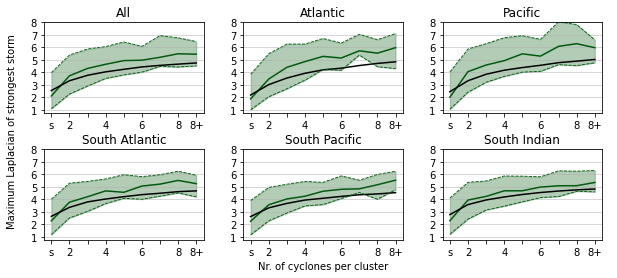

In [35]:
%matplotlib inline

#laplBins = np.arange(920,1025.1,2.5)
plt.figure()
f, axs = plt.subplots(2, 3, sharey=False)
f.set_figheight(4.0)
f.set_figwidth(10.0)
plt.subplots_adjust(hspace=0.4,wspace=.25)
#im = axs[0,0].contourf(laplBins_mid,range(1,11),pdfAll,cmap="RdBu_r")
axs[0,0].plot(range(1,maxLength+1),quantsAll[:,1],color="xkcd:deep green",linewidth=1.5)
axs[0,0].fill_between(range(1,maxLength+1),quantsAll[:,0],quantsAll[:,2],color='xkcd:deep green',alpha=0.3)
axs[0,0].plot(range(1,maxLength+1),quantsAll_Expect[:,1],color="black",linewidth=1.5)
axs[0,0].plot(range(1,maxLength+1),quantsAll[:,0],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[0,0].plot(range(1,maxLength+1),quantsAll[:,2],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[0,0].set_xticks([1,2,3,4,5,6,7,8,9])
axs[0,0].set_yticks([1,2,3,4,5,6,7,8])
axs[0,0].set_ylim(0.75,8.0)
axs[0,0].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[0,0].set_title("All")
axs[0,0].grid(linewidth=0.5,axis='y',zorder=0)

#axs[0,1].contourf(laplBins_mid,range(1,11),pdfAtlantic,cmap="RdBu_r")
axs[0,1].set_title("Atlantic")
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic[:,1],color="xkcd:deep green",linewidth=1.5)
axs[0,1].fill_between(range(1,maxLength+1),quantsAtlantic[:,0],quantsAtlantic[:,2],color='xkcd:deep green',alpha=0.3)
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_Expect[:,1],color="black",linewidth=1.5)
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic[:,0],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic[:,2],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[0,1].set_xticks([1,2,3,4,5,6,7,8,9])
axs[0,1].set_yticks([1,2,3,4,5,6,7,8])
axs[0,1].set_ylim(0.75,8.0)
axs[0,1].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[0,1].grid(linewidth=0.5,axis='y',zorder=0)

#axs[0,2].contourf(laplBins_mid,range(1,11),pdfPacific,cmap="RdBu_r")
axs[0,2].set_title("Pacific")
axs[0,2].plot(range(1,maxLength+1),quantsPacific[:,1],color="xkcd:deep green",linewidth=1.5)
axs[0,2].fill_between(range(1,maxLength+1),quantsPacific[:,0],quantsPacific[:,2],color='xkcd:deep green',alpha=0.3)
axs[0,2].plot(range(1,maxLength+1),quantsPacific_Expect[:,1],color="black",linewidth=1.5)
axs[0,2].plot(range(1,maxLength+1),quantsPacific[:,0],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[0,2].plot(range(1,maxLength+1),quantsPacific[:,2],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[0,2].set_xticks([1,2,3,4,5,6,7,8,9])
axs[0,2].set_yticks([1,2,3,4,5,6,7,8])
axs[0,2].set_ylim(0.75,8.0)
axs[0,2].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[0,2].grid(linewidth=0.5,axis='y',zorder=0)

#axs[1,0].contourf(laplBins_mid,range(1,11),pdfsAtlantic,cmap="RdBu_r")
axs[1,0].set_title("South Atlantic")
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic[:,1],color="xkcd:deep green",linewidth=1.5)
axs[1,0].fill_between(range(1,maxLength+1),quantsSAtlantic[:,0],quantsSAtlantic[:,2],color='xkcd:deep green',alpha=0.3)
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_Expect[:,1],color="black",linewidth=1.5)
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic[:,0],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic[:,2],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[1,0].set_xticks([1,2,3,4,5,6,7,8,9])
axs[1,0].set_yticks([1,2,3,4,5,6,7,8])
axs[1,0].set_ylim(0.75,8.0)
axs[1,0].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[1,0].grid(linewidth=0.5,axis='y',zorder=0)

#axs[1,1].contourf(laplBins_mid,range(1,11),pdfsPacific,cmap="RdBu_r")
axs[1,1].set_title("South Pacific")
axs[1,1].plot(range(1,maxLength+1),quantsSPacific[:,1],color="xkcd:deep green",linewidth=1.5)
axs[1,1].fill_between(range(1,maxLength+1),quantsSPacific[:,0],quantsSPacific[:,2],color='xkcd:deep green',alpha=0.3)
axs[1,1].plot(range(1,maxLength+1),quantsSPacific_Expect[:,1],color="black",linewidth=1.5)
axs[1,1].plot(range(1,maxLength+1),quantsSPacific[:,0],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[1,1].plot(range(1,maxLength+1),quantsSPacific[:,2],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[1,1].set_yticks([1,2,3,4,5,6,7,8])
axs[1,1].set_xticks([1,2,3,4,5,6,7,8,9])
axs[1,1].set_ylim(0.75,8.0)
axs[1,1].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[1,1].grid(linewidth=0.5,axis='y',zorder=0)

#axs[1,2].contourf(laplBins_mid,range(1,11),pdfsIndian,cmap="RdBu_r")
axs[1,2].set_title("South Indian")
axs[1,2].plot(range(1,maxLength+1),quantsSIndian[:,1],color="xkcd:deep green",linewidth=1.5)
axs[1,2].fill_between(range(1,maxLength+1),quantsSIndian[:,0],quantsSIndian[:,2],color='xkcd:deep green',alpha=0.3)
axs[1,2].plot(range(1,maxLength+1),quantsSIndian_Expect[:,1],color="black",linewidth=1.5)
axs[1,2].plot(range(1,maxLength+1),quantsSIndian[:,0],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[1,2].plot(range(1,maxLength+1),quantsSIndian[:,2],color="xkcd:deep green",linewidth=0.85,linestyle="dashed")
axs[1,2].set_xticks([1,2,3,4,5,6,7,8,9])
axs[1,2].set_yticks([1,2,3,4,5,6,7,8])
axs[1,2].set_ylim(0.75,8.0)
axs[1,2].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[1,2].grid(linewidth=0.5,axis='y',zorder=0)

# Add color bar
#f.subplots_adjust(right=0.875)
#cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
#f.colorbar(im, cax=cbar_ax)

# Add xlabel and ylabel
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Maximum Laplacian of strongest storm")
plt.xlabel("Nr. of cyclones per cluster")
plt.savefig("MaxLaplPdfAreas" + reschar + "_StrongestCyclones_"+ str(Options["whichClusters"]) +
            "_lngthresh_" + str(Options["lngthresh"]) + "_timlngthresh_" + str(Options["timlngthresh"]) +
            "_nopdf.pdf")

In [ ]:
quantsAll[:,1]


In [36]:
########################################################################################
# Determine Histogram of intensity/radius measures of clusters for each basin for subtypes
############################################################################
#Subselect cyclone families and non-cyclone families
storms_Atlantic_length = [item for sublist in sorted_clusters_length_Atlantic for item in sublist]
storms_Pacific_length = [item for sublist in sorted_clusters_length_Pacific for item in sublist]
storms_sAtlantic_length = [item for sublist in sorted_clusters_length_sAtlantic for item in sublist]
storms_sPacific_length = [item for sublist in sorted_clusters_length_sPacific for item in sublist]
storms_sIndian_length = [item for sublist in sorted_clusters_length_sIndian for item in sublist]

#Define results arrays
pres_Atlantic_length = np.zeros(len(storms_Atlantic_length))
lapl_Atlantic_length = np.zeros(len(storms_Atlantic_length))
pres_Pacific_length = np.zeros(len(storms_Pacific_length))
lapl_Pacific_length = np.zeros(len(storms_Pacific_length))
pres_sAtlantic_length = np.zeros(len(storms_sAtlantic_length))
lapl_sAtlantic_length = np.zeros(len(storms_sAtlantic_length))
pres_sPacific_length = np.zeros(len(storms_sPacific_length))
lapl_sPacific_length = np.zeros(len(storms_sPacific_length))
pres_sIndian_length = np.zeros(len(storms_sIndian_length))
lapl_sIndian_length = np.zeros(len(storms_sIndian_length))
month_Atlantic_length = np.zeros(len(storms_Atlantic_length))
month_Pacific_length = np.zeros(len(storms_Pacific_length))
month_sAtlantic_length = np.zeros(len(storms_sAtlantic_length))
month_sPacific_length = np.zeros(len(storms_sPacific_length))
month_sIndian_length = np.zeros(len(storms_sIndian_length))
radi_Atlantic_length = np.zeros(len(storms_Atlantic_length))
radi_Pacific_length = np.zeros(len(storms_Pacific_length))
radi_sAtlantic_length = np.zeros(len(storms_sAtlantic_length))
radi_sPacific_length = np.zeros(len(storms_sPacific_length))
radi_sIndian_length = np.zeros(len(storms_sIndian_length))

for strm in range(len(storms_Atlantic_length)):
	pres_Atlantic_length[strm] = np.nanmin(str_pres[ids_storms[storms_Atlantic_length[strm]]])
	lapl_Atlantic_length[strm] = np.nanmax(str_lapl[ids_storms[storms_Atlantic_length[strm]]])
	radi_Atlantic_length[strm] = np.nanmean(str_radi[ids_storms[storms_Atlantic_length[strm]]])
	month_Atlantic_length[strm] = stats.mode(str_month[ids_storms[storms_Atlantic_length[strm]]])[0]

for strm in range(len(storms_Pacific_length)):
	pres_Pacific_length[strm] = np.nanmin(str_pres[ids_storms[storms_Pacific_length[strm]]])
	lapl_Pacific_length[strm] = np.nanmax(str_lapl[ids_storms[storms_Pacific_length[strm]]])
	radi_Pacific_length[strm] = np.nanmean(str_radi[ids_storms[storms_Pacific_length[strm]]])
	month_Pacific_length[strm] = stats.mode(str_month[ids_storms[storms_Pacific_length[strm]]])[0]

for strm in range(len(storms_sAtlantic_length)):
	pres_sAtlantic_length[strm] = np.nanmin(str_pres[ids_storms[storms_sAtlantic_length[strm]]])
	lapl_sAtlantic_length[strm] = np.nanmax(str_lapl[ids_storms[storms_sAtlantic_length[strm]]])
	radi_sAtlantic_length[strm] = np.nanmean(str_radi[ids_storms[storms_sAtlantic_length[strm]]])
	month_sAtlantic_length[strm] = stats.mode(str_month[ids_storms[storms_sAtlantic_length[strm]]])[0]

for strm in range(len(storms_sPacific_length)):
	pres_sPacific_length[strm] = np.nanmin(str_pres[ids_storms[storms_sPacific_length[strm]]])
	lapl_sPacific_length[strm] = np.nanmax(str_lapl[ids_storms[storms_sPacific_length[strm]]])
	radi_sPacific_length[strm] = np.nanmean(str_radi[ids_storms[storms_sPacific_length[strm]]])
	month_sPacific_length[strm] = stats.mode(str_month[ids_storms[storms_sPacific_length[strm]]])[0]

for strm in range(len(storms_sIndian_length)):
	pres_sIndian_length[strm] = np.nanmin(str_pres[ids_storms[storms_sIndian_length[strm]]])
	lapl_sIndian_length[strm] = np.nanmax(str_lapl[ids_storms[storms_sIndian_length[strm]]])
	radi_sIndian_length[strm] = np.nanmean(str_radi[ids_storms[storms_sIndian_length[strm]]])
	month_sIndian_length[strm] = stats.mode(str_month[ids_storms[storms_sIndian_length[strm]]])[0]

pres_All_length = np.hstack((pres_Atlantic_length,pres_Pacific_length,pres_sAtlantic_length,
                             pres_sPacific_length,pres_sIndian_length))
lapl_All_length = np.hstack((lapl_Atlantic_length,lapl_Pacific_length,lapl_sAtlantic_length,
                             lapl_sPacific_length,lapl_sIndian_length))

########################################################################################
# Determine Histogram of intensity/radius measures of clusters for each basin for subtypes
############################################################################
#Subselect cyclone families and non-cyclone families
storms_Atlantic_nolength = [item for sublist in sorted_clusters_nolength_Atlantic for item in sublist]
storms_Pacific_nolength = [item for sublist in sorted_clusters_nolength_Pacific for item in sublist]
storms_sAtlantic_nolength = [item for sublist in sorted_clusters_nolength_sAtlantic for item in sublist]
storms_sPacific_nolength = [item for sublist in sorted_clusters_nolength_sPacific for item in sublist]
storms_sIndian_nolength = [item for sublist in sorted_clusters_nolength_sIndian for item in sublist]

#Define results arrays
pres_Atlantic_nolength = np.zeros(len(storms_Atlantic_nolength))
lapl_Atlantic_nolength = np.zeros(len(storms_Atlantic_nolength))
pres_Pacific_nolength = np.zeros(len(storms_Pacific_nolength))
lapl_Pacific_nolength = np.zeros(len(storms_Pacific_nolength))
pres_sAtlantic_nolength = np.zeros(len(storms_sAtlantic_nolength))
lapl_sAtlantic_nolength = np.zeros(len(storms_sAtlantic_nolength))
pres_sPacific_nolength = np.zeros(len(storms_sPacific_nolength))
lapl_sPacific_nolength = np.zeros(len(storms_sPacific_nolength))
pres_sIndian_nolength = np.zeros(len(storms_sIndian_nolength))
lapl_sIndian_nolength = np.zeros(len(storms_sIndian_nolength))
month_Atlantic_nolength = np.zeros(len(storms_Atlantic_nolength))
month_Pacific_nolength = np.zeros(len(storms_Pacific_nolength))
month_sAtlantic_nolength = np.zeros(len(storms_sAtlantic_nolength))
month_sPacific_nolength = np.zeros(len(storms_sPacific_nolength))
month_sIndian_nolength = np.zeros(len(storms_sIndian_nolength))
radi_Atlantic_nolength = np.zeros(len(storms_Atlantic_nolength))
radi_Pacific_nolength = np.zeros(len(storms_Pacific_nolength))
radi_sAtlantic_nolength = np.zeros(len(storms_sAtlantic_nolength))
radi_sPacific_nolength = np.zeros(len(storms_sPacific_nolength))
radi_sIndian_nolength = np.zeros(len(storms_sIndian_nolength))

for strm in range(len(storms_Atlantic_nolength)):
	pres_Atlantic_nolength[strm] = np.nanmin(str_pres[ids_storms[storms_Atlantic_nolength[strm]]])
	lapl_Atlantic_nolength[strm] = np.nanmax(str_lapl[ids_storms[storms_Atlantic_nolength[strm]]])
	radi_Atlantic_nolength[strm] = np.nanmean(str_radi[ids_storms[storms_Atlantic_nolength[strm]]])
	month_Atlantic_nolength[strm] = stats.mode(str_month[ids_storms[storms_Atlantic_nolength[strm]]])[0]

for strm in range(len(storms_Pacific_nolength)):
	pres_Pacific_nolength[strm] = np.nanmin(str_pres[ids_storms[storms_Pacific_nolength[strm]]])
	lapl_Pacific_nolength[strm] = np.nanmax(str_lapl[ids_storms[storms_Pacific_nolength[strm]]])
	radi_Pacific_nolength[strm] = np.nanmean(str_radi[ids_storms[storms_Pacific_nolength[strm]]])
	month_Pacific_nolength[strm] = stats.mode(str_month[ids_storms[storms_Pacific_nolength[strm]]])[0]

for strm in range(len(storms_sAtlantic_nolength)):
	pres_sAtlantic_nolength[strm] = np.nanmin(str_pres[ids_storms[storms_sAtlantic_nolength[strm]]])
	lapl_sAtlantic_nolength[strm] = np.nanmax(str_lapl[ids_storms[storms_sAtlantic_nolength[strm]]])
	radi_sAtlantic_nolength[strm] = np.nanmean(str_radi[ids_storms[storms_sAtlantic_nolength[strm]]])
	month_sAtlantic_nolength[strm] = stats.mode(str_month[ids_storms[storms_sAtlantic_nolength[strm]]])[0]

for strm in range(len(storms_sPacific_nolength)):
	pres_sPacific_nolength[strm] = np.nanmin(str_pres[ids_storms[storms_sPacific_nolength[strm]]])
	lapl_sPacific_nolength[strm] = np.nanmax(str_lapl[ids_storms[storms_sPacific_nolength[strm]]])
	radi_sPacific_nolength[strm] = np.nanmean(str_radi[ids_storms[storms_sPacific_nolength[strm]]])
	month_sPacific_nolength[strm] = stats.mode(str_month[ids_storms[storms_sPacific_nolength[strm]]])[0]

for strm in range(len(storms_sIndian_nolength)):
	pres_sIndian_nolength[strm] = np.nanmin(str_pres[ids_storms[storms_sIndian_nolength[strm]]])
	lapl_sIndian_nolength[strm] = np.nanmax(str_lapl[ids_storms[storms_sIndian_nolength[strm]]])
	radi_sIndian_nolength[strm] = np.nanmean(str_radi[ids_storms[storms_sIndian_nolength[strm]]])
	month_sIndian_nolength[strm] = stats.mode(str_month[ids_storms[storms_sIndian_nolength[strm]]])[0]

pres_All_nolength = np.hstack((pres_Atlantic_nolength,pres_Pacific_nolength,pres_sAtlantic_nolength,
                             pres_sPacific_nolength,pres_sIndian_nolength))
lapl_All_nolength = np.hstack((lapl_Atlantic_nolength,lapl_Pacific_nolength,lapl_sAtlantic_nolength,
                             lapl_sPacific_nolength,lapl_sIndian_nolength))

In [38]:
#Quantiles Bjerknes type
quantsAll_length = np.zeros((maxLength,3))
quantsAtlantic_length = np.zeros((maxLength,3))
quantsPacific_length = np.zeros((maxLength,3))
quantsSAtlantic_length = np.zeros((maxLength,3))
quantsSPacific_length = np.zeros((maxLength,3))
quantsSIndian_length = np.zeros((maxLength,3))

for l in range(maxLength):
	if(l < (maxLength -1)):
		laplTempAtlantic = [np.nanmax(lapl_Atlantic_length[np.array([np.where(np.array(storms_Atlantic_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_Atlantic if len(sublist) == l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific_length[np.array([np.where(np.array(storms_Pacific_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_Pacific if len(sublist) == l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic_length[np.array([np.where(np.array(storms_sAtlantic_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_sAtlantic if len(sublist) == l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific_length[np.array([np.where(np.array(storms_sPacific_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_sPacific if len(sublist) == l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian_length[np.array([np.where(np.array(storms_sIndian_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_sIndian if len(sublist) == l + 1]

	else:
		laplTempAtlantic = [np.nanmax(lapl_Atlantic_length[np.array([np.where(np.array(storms_Atlantic_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_Atlantic if len(sublist) >= l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific_length[np.array([np.where(np.array(storms_Pacific_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_Pacific if len(sublist) >= l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic_length[np.array([np.where(np.array(storms_sAtlantic_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_sAtlantic if len(sublist) >= l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific_length[np.array([np.where(np.array(storms_sPacific_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_sPacific if len(sublist) >= l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian_length[np.array([np.where(np.array(storms_sIndian_length) == item)[0] for item in sublist])]) for sublist in sorted_clusters_length_sIndian if len(sublist) >= l + 1]
	laplTempAll = np.hstack((laplTempAtlantic,laplTempPacific,laplTempsAtlantic,
                                    laplTempsPacific,laplTempsIndian))

	quantsAll_length[l,::] = np.nanquantile(laplTempAll,[0.1,0.5,0.9])	
	quantsAtlantic_length[l,::] =  np.nanquantile(laplTempAtlantic,[0.1,0.5,0.9])
	quantsPacific_length[l,::] = np.nanquantile(laplTempPacific,[0.1,0.5,0.9])
	quantsSAtlantic_length[l,::] = np.nanquantile(laplTempsAtlantic,[0.1,0.5,0.9])
	quantsSPacific_length[l,::] = np.nanquantile(laplTempsPacific,[0.1,0.5,0.9])
	quantsSIndian_length[l,::] = np.nanquantile(laplTempsIndian,[0.1,0.5,0.9])
    
    
# Quantiles Stationary types
quantsAll_nolength = np.zeros((maxLength,3))
quantsAtlantic_nolength = np.zeros((maxLength,3))
quantsPacific_nolength = np.zeros((maxLength,3))
quantsSAtlantic_nolength = np.zeros((maxLength,3))
quantsSPacific_nolength = np.zeros((maxLength,3))
quantsSIndian_nolength = np.zeros((maxLength,3))

for l in range(maxLength):
	if(l < (maxLength-1)):
		laplTempAtlantic = [np.nanmax(lapl_Atlantic_nolength[np.array([np.where(np.array(storms_Atlantic_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_Atlantic if len(sublist) == l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific_nolength[np.array([np.where(np.array(storms_Pacific_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_Pacific if len(sublist) == l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic_nolength[np.array([np.where(np.array(storms_sAtlantic_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_sAtlantic if len(sublist) == l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific_nolength[np.array([np.where(np.array(storms_sPacific_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_sPacific if len(sublist) == l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian_nolength[np.array([np.where(np.array(storms_sIndian_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_sIndian if len(sublist) == l + 1]

	else:
		laplTempAtlantic = [np.nanmax(lapl_Atlantic_nolength[np.array([np.where(np.array(storms_Atlantic_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_Atlantic if len(sublist) >= l + 1]
		laplTempPacific = [np.nanmax(lapl_Pacific_nolength[np.array([np.where(np.array(storms_Pacific_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_Pacific if len(sublist) >= l + 1]
		laplTempsAtlantic = [np.nanmax(lapl_sAtlantic_nolength[np.array([np.where(np.array(storms_sAtlantic_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_sAtlantic if len(sublist) >= l + 1]
		laplTempsPacific = [np.nanmax(lapl_sPacific_nolength[np.array([np.where(np.array(storms_sPacific_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_sPacific if len(sublist) >= l + 1]
		laplTempsIndian = [np.nanmax(lapl_sIndian_nolength[np.array([np.where(np.array(storms_sIndian_nolength) == item)[0] for item in sublist])]) for sublist in sorted_clusters_nolength_sIndian if len(sublist) >= l + 1]
	laplTempAll = np.hstack((laplTempAtlantic,laplTempPacific,laplTempsAtlantic,
                                    laplTempsPacific,laplTempsIndian))
    
	quantsAll_nolength[l,::] = np.nanquantile(laplTempAll,[0.1,0.5,0.9])	
	quantsAtlantic_nolength[l,::] =  np.nanquantile(laplTempAtlantic,[0.1,0.5,0.9])
	quantsPacific_nolength[l,::] = np.nanquantile(laplTempPacific,[0.1,0.5,0.9])
	quantsSAtlantic_nolength[l,::] = np.nanquantile(laplTempsAtlantic,[0.1,0.5,0.9])
	quantsSPacific_nolength[l,::] = np.nanquantile(laplTempsPacific,[0.1,0.5,0.9])
	quantsSIndian_nolength[l,::] = np.nanquantile(laplTempsIndian,[0.1,0.5,0.9])
    

<Figure size 432x288 with 0 Axes>

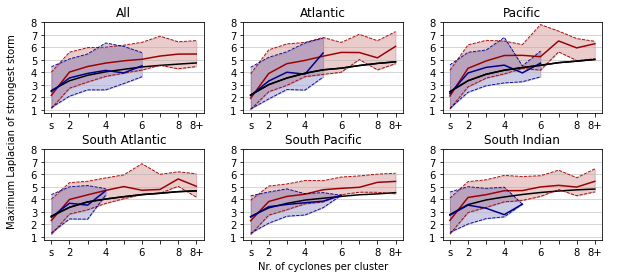

In [43]:

#laplBins = np.arange(920,1025.1,2.5)
plt.figure()
f, axs = plt.subplots(2, 3, sharey=False)
f.set_figheight(4.0)
f.set_figwidth(10.0)
plt.subplots_adjust(hspace=0.4,wspace=.25)
#im = axs[0,0].contourf(laplBins_mid,range(1,11),pdfAll,cmap="RdBu_r")
axs[0,0].plot(range(1,maxLength+1),quantsAll_length[:,1],color="xkcd:deep red",linewidth=1.5)
axs[0,0].fill_between(range(1,maxLength+1),quantsAll_length[:,0],quantsAll_length[:,2],color='xkcd:deep red',alpha=0.2)
axs[0,0].plot(range(1,maxLength+1),quantsAll_Expect[:,1],color="black",linewidth=1.5)
axs[0,0].plot(range(1,maxLength+1),quantsAll_length[:,0],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")
axs[0,0].plot(range(1,maxLength+1),quantsAll_length[:,2],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")

axs[0,0].plot(range(1,maxLength+1),quantsAll_nolength[:,1],color="darkblue",linewidth=1.5)
axs[0,0].fill_between(range(1,maxLength+1),quantsAll_nolength[:,0],quantsAll_nolength[:,2],color="darkblue",alpha=0.2)
axs[0,0].plot(range(1,maxLength+1),quantsAll_nolength[:,0],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[0,0].plot(range(1,maxLength+1),quantsAll_nolength[:,2],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[0,0].set_xticks([1,2,3,4,5,6,7,8,9])
axs[0,0].set_yticks([1,2,3,4,5,6,7,8])
axs[0,0].set_ylim(0.75,8.0)
axs[0,0].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[0,0].set_title("All")
axs[0,0].grid(linewidth=0.5,axis='y',zorder=0)

#axs[0,1].contourf(laplBins_mid,range(1,11),pdfAtlantic,cmap="RdBu_r")
axs[0,1].set_title("Atlantic")
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_length[:,1],color="xkcd:deep red",linewidth=1.5)
axs[0,1].fill_between(range(1,maxLength+1),quantsAtlantic_length[:,0],quantsAtlantic_length[:,2],color='xkcd:deep red',alpha=0.2)
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_Expect[:,1],color="black",linewidth=1.5)
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_length[:,0],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_length[:,2],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")

axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_nolength[:,1],color="darkblue",linewidth=1.5)
axs[0,1].fill_between(range(1,maxLength+1),quantsAtlantic_nolength[:,0],quantsAtlantic_nolength[:,2],color='darkblue',alpha=0.2)
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_Expect[:,1],color="black",linewidth=1.5)
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_nolength[:,0],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[0,1].plot(range(1,maxLength+1),quantsAtlantic_nolength[:,2],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[0,1].set_xticks([1,2,3,4,5,6,7,8,9])
axs[0,1].set_yticks([1,2,3,4,5,6,7,8])
axs[0,1].set_ylim(0.75,8.0)
axs[0,1].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[0,1].grid(linewidth=0.5,axis='y',zorder=0)

#axs[0,2].contourf(laplBins_mid,range(1,11),pdfPacific,cmap="RdBu_r")
axs[0,2].set_title("Pacific")
axs[0,2].plot(range(1,maxLength+1),quantsPacific_length[:,1],color="xkcd:deep red",linewidth=1.5)
axs[0,2].fill_between(range(1,maxLength+1),quantsPacific_length[:,0],quantsPacific_length[:,2],color='xkcd:deep red',alpha=0.2)
axs[0,2].plot(range(1,maxLength+1),quantsPacific_Expect[:,1],color="black",linewidth=1.5)
axs[0,2].plot(range(1,maxLength+1),quantsPacific_length[:,0],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")
axs[0,2].plot(range(1,maxLength+1),quantsPacific_length[:,2],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")

axs[0,2].plot(range(1,maxLength+1),quantsPacific_nolength[:,1],color="darkblue",linewidth=1.5)
axs[0,2].fill_between(range(1,maxLength+1),quantsPacific_nolength[:,0],quantsPacific_nolength[:,2],color="darkblue",alpha=0.2)
axs[0,2].plot(range(1,maxLength+1),quantsPacific_Expect[:,1],color="black",linewidth=1.5)
axs[0,2].plot(range(1,maxLength+1),quantsPacific_nolength[:,0],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[0,2].plot(range(1,maxLength+1),quantsPacific_nolength[:,2],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[0,2].set_xticks([1,2,3,4,5,6,7,8,9])
axs[0,2].set_yticks([1,2,3,4,5,6,7,8])
axs[0,2].set_ylim(0.75,8.0)
axs[0,2].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[0,2].grid(linewidth=0.5,axis='y',zorder=0)

#axs[1,0].contourf(laplBins_mid,range(1,11),pdfsAtlantic,cmap="RdBu_r")
axs[1,0].set_title("South Atlantic")
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_length[:,1],color="xkcd:deep red",linewidth=1.5)
axs[1,0].fill_between(range(1,maxLength+1),quantsSAtlantic_length[:,0],quantsSAtlantic_length[:,2],color='xkcd:deep red',alpha=0.2)
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_Expect[:,1],color="black",linewidth=1.5)
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_length[:,0],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_length[:,2],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")

axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_nolength[:,1],color="darkblue",linewidth=1.5)
axs[1,0].fill_between(range(1,maxLength+1),quantsSAtlantic_nolength[:,0],quantsSAtlantic_nolength[:,2],color='darkblue',alpha=0.2)
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_Expect[:,1],color="black",linewidth=1.5)
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_nolength[:,0],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[1,0].plot(range(1,maxLength+1),quantsSAtlantic_nolength[:,2],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[1,0].set_xticks([1,2,3,4,5,6,7,8,9])
axs[1,0].set_yticks([1,2,3,4,5,6,7,8])
axs[1,0].set_ylim(0.75,8.0)
axs[1,0].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[1,0].grid(linewidth=0.5,axis='y',zorder=0)

#axs[1,1].contourf(laplBins_mid,range(1,11),pdfsPacific,cmap="RdBu_r")
axs[1,1].set_title("South Pacific")
axs[1,1].plot(range(1,maxLength+1),quantsSPacific_length[:,1],color="xkcd:deep red",linewidth=1.5)
axs[1,1].fill_between(range(1,maxLength+1),quantsSPacific_length[:,0],quantsSPacific_length[:,2],color='xkcd:deep red',alpha=0.2)
axs[1,1].plot(range(1,maxLength+1),quantsSPacific_Expect[:,1],color="black",linewidth=1.5)
axs[1,1].plot(range(1,maxLength+1),quantsSPacific_length[:,0],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")
axs[1,1].plot(range(1,maxLength+1),quantsSPacific_length[:,2],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")

axs[1,1].plot(range(1,maxLength+1),quantsSPacific_nolength[:,1],color="darkblue",linewidth=1.5)
axs[1,1].fill_between(range(1,maxLength+1),quantsSPacific_nolength[:,0],quantsSPacific_nolength[:,2],color="darkblue",alpha=0.2)
axs[1,1].plot(range(1,maxLength+1),quantsSPacific_nolength[:,0],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[1,1].plot(range(1,maxLength+1),quantsSPacific_nolength[:,2],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[1,1].set_yticks([1,2,3,4,5,6,7,8])
axs[1,1].set_xticks([1,2,3,4,5,6,7,8,9])
axs[1,1].set_ylim(0.75,8.0)
axs[1,1].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[1,1].grid(linewidth=0.5,axis='y',zorder=0)

#axs[1,2].contourf(laplBins_mid,range(1,11),pdfsIndian,cmap="RdBu_r")
axs[1,2].set_title("South Indian")
axs[1,2].plot(range(1,maxLength+1),quantsSIndian_length[:,1],color="xkcd:deep red",linewidth=1.5)
axs[1,2].fill_between(range(1,maxLength+1),quantsSIndian_length[:,0],quantsSIndian_length[:,2],color='xkcd:deep red',alpha=0.2)
axs[1,2].plot(range(1,maxLength+1),quantsSIndian_Expect[:,1],color="black",linewidth=1.5)
axs[1,2].plot(range(1,maxLength+1),quantsSIndian_length[:,0],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")
axs[1,2].plot(range(1,maxLength+1),quantsSIndian_length[:,2],color="xkcd:deep red",linewidth=0.85,linestyle="dashed")

axs[1,2].plot(range(1,maxLength+1),quantsSIndian_nolength[:,1],color="darkblue",linewidth=1.5)
axs[1,2].fill_between(range(1,maxLength+1),quantsSIndian_nolength[:,0],quantsSIndian_nolength[:,2],color="darkblue",alpha=0.2)
axs[1,2].plot(range(1,maxLength+1),quantsSIndian_nolength[:,0],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[1,2].plot(range(1,maxLength+1),quantsSIndian_nolength[:,2],color="darkblue",linewidth=0.85,linestyle="dashed")
axs[1,2].set_xticks([1,2,3,4,5,6,7,8,9])
axs[1,2].set_yticks([1,2,3,4,5,6,7,8])
axs[1,2].set_ylim(0.75,8.0)
axs[1,2].set_xticklabels(["s","2","","4","","6","","8","8+"],minor=False)
axs[1,2].grid(linewidth=0.5,axis='y',zorder=0)

# Add color bar
#f.subplots_adjust(right=0.875)
#cbar_ax = f.add_axes([0.9, 0.15, 0.02, 0.7])
#f.colorbar(im, cax=cbar_ax)

# Add xlabel and ylabel
f.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Maximum Laplacian of strongest storm")
plt.xlabel("Nr. of cyclones per cluster")
plt.savefig("MaxLaplPdfAreas" + reschar + "_StrongestCyclones_Subtypes_nopdf_length" + str(Options["lngthresh"]) + "_timlength_" + str(Options["timlngthresh"]) + ".pdf")



In [ ]:
#Options["lngthresh"]

In [63]:
# strength of storms
lapl_storms = np.zeros(nrstorms)
for strm in range(nrstorms):
    lapl_storms[strm] = np.nanmax(str_lapl[ids_storms[strm+1]])


(array([[4.4666e+04, 3.6777e+04, 2.0232e+04, 1.0150e+04, 4.0920e+03,
         1.3910e+03, 3.4700e+02, 9.8000e+01, 1.6000e+01, 4.0000e+00],
        [3.7200e+02, 1.2820e+03, 1.2850e+03, 8.1900e+02, 3.4200e+02,
         1.2700e+02, 4.1000e+01, 1.2000e+01, 4.0000e+00, 1.0000e+00],
        [3.8200e+02, 1.9780e+03, 2.8140e+03, 2.1980e+03, 1.1830e+03,
         3.9300e+02, 1.2800e+02, 1.9000e+01, 5.0000e+00, 0.0000e+00],
        [3.2000e+01, 4.8700e+02, 1.0840e+03, 9.7100e+02, 6.0400e+02,
         2.3600e+02, 6.4000e+01, 1.6000e+01, 5.0000e+00, 0.0000e+00],
        [4.0000e+00, 1.0600e+02, 3.5700e+02, 4.5500e+02, 2.9200e+02,
         1.0500e+02, 3.2000e+01, 9.0000e+00, 2.0000e+00, 1.0000e+00],
        [0.0000e+00, 2.7000e+01, 1.5800e+02, 2.0600e+02, 1.5700e+02,
         7.4000e+01, 1.7000e+01, 3.0000e+00, 3.0000e+00, 3.0000e+00],
        [0.0000e+00, 6.0000e+00, 5.6000e+01, 9.8000e+01, 7.0000e+01,
         3.4000e+01, 5.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.0000

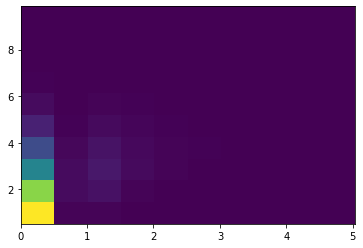

In [19]:
plt.hist2d(drStorms,lapl_storms)

In [7]:
test = list(zip(drStorms,lapl_storms))


In [10]:
testing  = zip(*(iter(range(10)),) * 3)


[((0.0, 3.881), (0.0, 2.753), (0.0, 4.962)),
 ((1.4657067165762638, 3.29), (1.0516438207557215, 2.337), (0.0, 2.674)),
 ((0.8961349169927081, 3.157), (0.0, 4.174), (0.0, 1.349)),
 ((0.0, 1.622), (0.0, 2.393), (0.0, 2.181)),
 ((0.0, 4.204), (0.0, 1.649), (0.0, 2.6)),
 ((0.0, 1.031), (1.3436839535274985, 5.608), (0.27345888985818373, 2.523)),
 ((0.4182578317373979, 1.381), (0.0, 3.037), (0.0, 1.085)),
 ((0.0, 2.03), (0.0, 4.061), (0.0, 1.999)),
 ((0.0, 3.338), (0.9037638332996716, 2.871), (0.0, 2.444)),
 ((0.0, 1.964), (0.0, 1.686), (0.0, 2.059)),
 ((0.8431014856056311, 2.075), (0.0, 0.991), (0.0, 1.59)),
 ((0.0, 1.637), (0.0, 1.923), (0.4364797946699867, 2.882)),
 ((0.22218732234933983, 2.193), (0.0, 1.745), (1.0933556744445057, 3.58)),
 ((0.0, 1.792), (0.6321379959650727, 5.781), (0.0, 1.603)),
 ((0.0, 3.137), (0.0, 1.597), (0.0, 1.319)),
 ((0.0, 1.83), (0.0, 1.031), (0.0, 2.768)),
 ((0.0, 2.394), (0.0, 3.089), (0.0, 1.18)),
 ((0.33779748875414767, 1.317), (0.8026163269643111, 4.225), 

In [26]:
np.nanmax()

0.49961176658978035

In [33]:
np.nansum(drStorms>3)

422

/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/WUR/weije043/virtual_envs/dynpie3_updated/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator


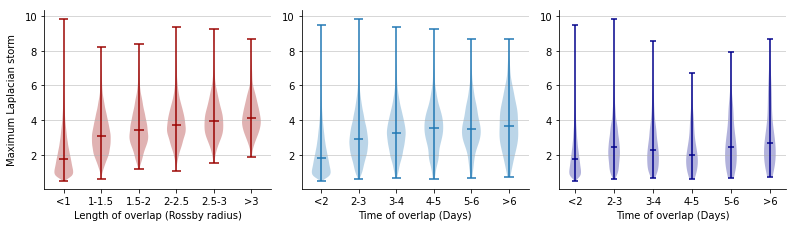

In [56]:
import pandas as pd
#import numpy as np
#from matplotlib import pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [11.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Pandas dataframe
data = [lapl_storms[drStorms < 1.0],lapl_storms[(drStorms >= 1.0) & (drStorms < 1.5)],
        lapl_storms[(drStorms >= 1.5) & (drStorms < 2.0)],
        lapl_storms[(drStorms >= 2.0) & (drStorms < 2.5)],
        lapl_storms[(drStorms >= 2.5) & (drStorms < 3.0)],
         lapl_storms[(drStorms >= 3.0)]]
data2 = [lapl_storms[dtStorms < 1.0],lapl_storms[(dtStorms >= 1.0) & (dtStorms < 1.5)],
        lapl_storms[(dtStorms >= 1.5) & (dtStorms < 2.0)],
        lapl_storms[(dtStorms >= 2.0) & (dtStorms < 2.5)],
        lapl_storms[(dtStorms >= 2.5) & (dtStorms < 3.0)],
         lapl_storms[(dtStorms >= 3.0)]]

data3 = [lapl_storms[(dtStorms < 1.0) & (drStorms < 1.0)],
         lapl_storms[(dtStorms >= 1.0) & (dtStorms < 1.5) & (drStorms < 1.0)],
        lapl_storms[(dtStorms >= 1.5) & (dtStorms < 2.0) & (drStorms < 1.0)],
        lapl_storms[(dtStorms >= 2.0) & (dtStorms < 2.5) & (drStorms < 1.0)],
        lapl_storms[(dtStorms >= 2.5) & (dtStorms < 3.0) & (drStorms < 1.0)],
         lapl_storms[(dtStorms >= 3.0)& (drStorms < 1.0)]]

fig, ax = plt.subplots(1,3)
vio0 = ax[0].violinplot(data,showmedians=True)
ax[0].set_xticklabels(["", "<1","1-1.5","1.5-2","2-2.5","2.5-3",">3"])
ax[0].set_xlabel("Length of overlap (Rossby radius)")
ax[0].grid(linewidth=0.5,axis='y',zorder=0)
ax[1].violinplot(data2,showmedians=True)
ax[1].set_xticklabels(["", "<2","2-3","3-4","4-5","5-6",">6"])
ax[1].set_xlabel("Time of overlap (Days)")
ax[1].grid(linewidth=0.5,axis='y',zorder=0)

vio2 = ax[2].violinplot(data3,widths=.3,showmedians=True)
# Set the color of the violin patches

ax[2].set_xticklabels(["", "<2","2-3","3-4","4-5","5-6",">6"])
ax[2].set_xlabel("Time of overlap (Days)")
ax[2].grid(linewidth=0.5,axis='y',zorder=0)

#Set face colors of violin plots

for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = vio0[partname]
    vp.set_edgecolor("xkcd:deep red")
    vp = vio2[partname]
    vp.set_edgecolor("darkblue") 
#vio0['cmedians'].set_colors("xkcd:deep red")

for pc in vio0['bodies']:
    pc.set_facecolor("xkcd:deep red")
for pc in vio2['bodies']:
    pc.set_facecolor("darkblue")

#Add xlabel and ylabel
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Maximum Laplacian storm")

# Hide the right and top spines
for a in range(3):
    ax[a].spines[['right', 'top']].set_visible(False)

#save Figure
plt.savefig("MaxLaplPdfSubtypes" + reschar + "_StrongestCyclones_" + str(Options["lngthresh"]) + "_timlength_" + str(Options["timlngthresh"]) + ".pdf")


In [135]:
sorted_clusters

#Define result-lists
first_time      = [None] * nrstorms
first_time_conn = [None] * nrstorms

lapl_primary    = []
lapl_secondary  = []
lapl_final = []

lapl_primary_length    = []
lapl_secondary_length  = []
lapl_final_length = []

lapl_primary_nolength    = []
lapl_secondary_nolength  = []
lapl_final_nolength = []


lapl_primary_length_Atlantic    = []
lapl_secondary_length_Atlantic  = []
lapl_final_length_Atlantic = []

lat_primary_Atlantic = []
lat_secondary_Atlantic = []
lat_final_Atlantic = []

# First time step of storms
for strm in range(nrstorms):
    tmp_time = str_dt[ids_storms[strm+1]]
    tmp_conn = str_connected[ids_storms[strm+1]]
    first_time[strm] = tmp_time[0]
    if(np.any(tmp_conn >0)):
        first_time_conn[strm] = tmp_time[tmp_conn>0][0]

first_time_conn = np.array(first_time_conn)

# All clusters
for cluster in sorted_clusters:
    if(len(cluster)>=3):
        print(cluster)
        
        cluster = np.array(cluster)
        
        #Find primary cyclone            
        timsort_cluster = cluster[np.argsort(first_time_conn[cluster-1])]
        print(timsort_cluster)
        #Check 
        lapl_primary.append(lapl_storms[timsort_cluster[0]-1])
        lapl_secondary.extend(lapl_storms[timsort_cluster[1:-1]-1])
        lapl_final.append(lapl_storms[timsort_cluster[-1]-1])

#Length clusters
for cluster in sorted_clusters_length:
    if(len(cluster)>=3):
        print(cluster)
        
        cluster = np.array(cluster)
        
        #Find primary cyclone            
        timsort_cluster = cluster[np.argsort(first_time_conn[cluster-1])]
        print(timsort_cluster)
        #Check 
        lapl_primary_length.append(lapl_storms[timsort_cluster[0]-1])
        lapl_secondary_length.extend(lapl_storms[timsort_cluster[1:-1]-1])
        lapl_final_length.append(lapl_storms[timsort_cluster[-1]-1])
        
        
#Length clusters
for cluster in sorted_clusters_nolength:
    if(len(cluster)>=3):
        print(cluster)
        
        cluster = np.array(cluster)
        
        #Find primary cyclone            
        timsort_cluster = cluster[np.argsort(first_time_conn[cluster-1])]
        print(timsort_cluster)
        #Check 
        lapl_primary_nolength.append(lapl_storms[timsort_cluster[0]-1])
        lapl_secondary_nolength.extend(lapl_storms[timsort_cluster[1:-1]-1])
        lapl_final_nolength.append(lapl_storms[timsort_cluster[-1]-1])


#Length clusters Atlantic
primary_storms_Atlantic   = []
secondary_storms_Atlantic = []
for cluster in sorted_clusters_length_Atlantic:
    if(len(cluster)>=3):
        print(cluster)
        
        cluster = np.array(cluster)
        
        #Find primary cyclone            
        timsort_cluster = cluster[np.argsort(first_time_conn[cluster-1])]
        print(timsort_cluster)
        
        
        #Check 
        lapl_primary_length_Atlantic.append(lapl_storms[timsort_cluster[0]-1])
        lapl_secondary_length_Atlantic.extend(lapl_storms[timsort_cluster[1:-1]-1])
        lapl_final_length_Atlantic.append(lapl_storms[timsort_cluster[-1]-1])
        
        primary_storms_Atlantic.append(timsort_cluster[0]-1)
        secondary_storms_Atlantic.extend(timsort_cluster[1:-1]-1)


[4, 26, 28, 31, 38, 48]
[26 28 31  4 38 48]
[17, 39, 70, 78, 95]
[17 39 78 70 95]
[18, 37, 52, 96, 103]
[ 18  37  52  96 103]
[19, 41, 50]
[19 50 41]
[73, 89, 112]
[ 73  89 112]
[102, 113, 126, 137]
[102 113 126 137]
[209, 217, 259]
[209 217 259]
[232, 241, 246]
[232 241 246]
[235, 251, 258]
[235 251 258]
[236, 238, 260]
[236 238 260]
[280, 295, 316, 323]
[280 295 316 323]
[308, 355, 362, 377]
[308 355 362 377]
[336, 366, 396, 397, 409]
[336 366 396 397 409]
[407, 408, 429, 452, 465]
[408 407 429 452 465]
[414, 433, 464, 482]
[414 433 464 482]
[417, 432, 438, 442, 468, 474]
[417 432 438 442 468 474]
[437, 455, 470, 476, 510, 535]
[437 455 470 476 510 535]
[479, 489, 495]
[479 495 489]
[569, 571, 615]
[571 569 615]
[581, 601, 628, 636]
[581 601 628 636]
[608, 644, 646]
[608 644 646]
[618, 651, 657, 669, 693]
[618 651 669 657 693]
[731, 765, 772, 790, 802]
[731 765 772 790 802]
[747, 767, 776]
[747 767 776]
[780, 822, 838, 842]
[780 822 838 842]
[831, 860, 881, 892, 916, 922]
[831 860 88

[23888 23902 23908]
[23930, 23941, 23999]
[23930 23941 23999]
[23936, 23986, 24009, 24016]
[23936 23986 24009 24016]
[23958, 23971, 23991, 24029]
[23958 23971 23991 24029]
[23964, 24034, 24055, 24066]
[23964 24034 24055 24066]
[24001, 24014, 24037, 24042]
[24001 24014 24037 24042]
[24032, 24035, 24053]
[24032 24035 24053]
[24041, 24049, 24080]
[24041 24049 24080]
[24045, 24057, 24073, 24074, 24094]
[24045 24057 24074 24073 24094]
[24095, 24104, 24124]
[24095 24104 24124]
[24109, 24165, 24178, 24185]
[24109 24165 24178 24185]
[24161, 24223, 24228, 24234, 24242, 24244, 24250]
[24161 24223 24228 24242 24244 24250 24234]
[24183, 24204, 24209, 24215]
[24183 24204 24209 24215]
[24200, 24207, 24214]
[24200 24207 24214]
[24203, 24208, 24227]
[24208 24203 24227]
[24230, 24251, 24287]
[24251 24230 24287]
[24238, 24256, 24261, 24269]
[24238 24256 24261 24269]
[24260, 24274, 24291]
[24260 24274 24291]
[24262, 24272, 24288, 24289, 24314]
[24272 24288 24262 24314 24289]
[24268, 24308, 24313]
[24268 

[46231 46248 46241 46260 46278 46255 46326 46343 46348 46386]
[46233, 46238, 46253, 46281, 46285]
[46233 46238 46253 46281 46285]
[46247, 46267, 46275]
[46267 46275 46247]
[46251, 46280, 46297]
[46251 46280 46297]
[46263, 46286, 46339, 46345, 46351, 46360, 46367, 46398, 46401, 46418, 46431, 46432, 46444]
[46263 46286 46345 46339 46351 46360 46367 46401 46398 46418 46432 46431
 46444]
[46276, 46302, 46314, 46421]
[46276 46302 46314 46421]
[46331, 46336, 46344, 46349, 46369, 46379]
[46331 46336 46344 46369 46379 46349]
[46341, 46366, 46376]
[46341 46366 46376]
[46374, 46410, 46436, 46437, 46474, 46481, 46484, 46533]
[46410 46374 46436 46437 46474 46481 46484 46533]
[46387, 46412, 46453, 46475]
[46412 46387 46453 46475]
[46451, 46459, 46471]
[46451 46459 46471]
[46470, 46510, 46534]
[46470 46510 46534]
[46539, 46586, 46660]
[46539 46586 46660]
[46591, 46618, 46629]
[46591 46618 46629]
[46617, 46632, 46676]
[46632 46617 46676]
[46624, 46628, 46649]
[46628 46624 46649]
[46678, 46697, 46712,

[77212, 77216, 77221, 77232, 77254]
[77212 77221 77232 77216 77254]
[77247, 77251, 77271, 77280]
[77247 77251 77271 77280]
[77282, 77321, 77361, 77372]
[77282 77321 77361 77372]
[77295, 77335, 77343]
[77295 77335 77343]
[77328, 77337, 77348]
[77328 77337 77348]
[77332, 77349, 77358, 77364]
[77332 77349 77358 77364]
[77352, 77362, 77370, 77374, 77420, 77425]
[77370 77352 77362 77374 77420 77425]
[77383, 77396, 77442, 77455, 77466, 77491, 77496]
[77383 77396 77442 77455 77466 77491 77496]
[77397, 77405, 77407, 77435, 77457, 77470, 77482, 77492, 77502, 77514]
[77397 77405 77407 77435 77457 77470 77482 77492 77502 77514]
[77445, 77461, 77486]
[77445 77461 77486]
[77507, 77538, 77542, 77555]
[77538 77542 77507 77555]
[77509, 77543, 77578]
[77509 77543 77578]
[77520, 77521, 77534]
[77520 77521 77534]
[77546, 77559, 77567, 77591, 77593, 77606]
[77546 77559 77567 77591 77593 77606]
[77577, 77583, 77586, 77610, 77622, 77626, 77644, 77650]
[77583 77586 77610 77622 77577 77626 77644 77650]
[77590

[110064 110073 110077 110039 110111]
[110070, 110080, 110094]
[110070 110080 110094]
[110104, 110109, 110115, 110145, 110149, 110151]
[110104 110109 110115 110145 110149 110151]
[110127, 110158, 110168]
[110127 110158 110168]
[110134, 110144, 110171, 110185, 110237, 110238, 110246, 110261, 110262, 110291, 110293, 110299, 110308, 110353, 110355]
[110144 110171 110134 110185 110238 110246 110262 110261 110237 110291
 110293 110299 110308 110355 110353]
[110152, 110155, 110160, 110187, 110196]
[110155 110152 110160 110187 110196]
[110190, 110232, 110233]
[110190 110233 110232]
[110205, 110217, 110282, 110290, 110297]
[110205 110217 110282 110290 110297]
[110236, 110248, 110271, 110296]
[110248 110236 110271 110296]
[110252, 110265, 110268]
[110252 110265 110268]
[110275, 110326, 110343]
[110275 110326 110343]
[110285, 110304, 110321, 110331, 110362, 110364]
[110285 110304 110321 110331 110362 110364]
[110300, 110338, 110346]
[110300 110346 110338]
[110324, 110328, 110340, 110344]
[110328 

[17797 17798 17861]
[17807, 17834, 17839, 17865]
[17807 17834 17839 17865]
[17877, 17927, 17958, 17998]
[17927 17877 17958 17998]
[17893, 17919, 17922, 17944]
[17893 17919 17922 17944]
[17917, 17952, 17960]
[17917 17952 17960]
[18012, 18022, 18041]
[18012 18022 18041]
[18036, 18037, 18050, 18051]
[18036 18037 18050 18051]
[18064, 18075, 18112]
[18064 18112 18075]
[18134, 18159, 18175]
[18134 18159 18175]
[18165, 18211, 18226, 18245]
[18165 18211 18226 18245]
[18173, 18222, 18235, 18255, 18295, 18326]
[18173 18222 18235 18255 18295 18326]
[18261, 18299, 18324]
[18261 18299 18324]
[18272, 18281, 18302, 18306, 18325, 18344, 18351, 18374, 18375, 18392, 18396]
[18281 18272 18302 18306 18325 18351 18344 18374 18375 18392 18396]
[18357, 18385, 18432, 18433]
[18385 18357 18433 18432]
[18380, 18410, 18411]
[18380 18410 18411]
[18421, 18438, 18474]
[18438 18421 18474]
[18453, 18482, 18505, 18551, 18579, 18585, 18592, 18594, 18601, 18619, 18623, 18626, 18629, 18640, 18641, 18647, 18656, 18658, 18

[68697, 68710, 68719, 68720, 68726, 68728, 68730, 68734, 68747, 68759]
[68710 68720 68726 68728 68730 68719 68734 68747 68697 68759]
[68746, 68749, 68766, 68784, 68790, 68799, 68802, 68813, 68842]
[68766 68746 68784 68749 68790 68799 68802 68813 68842]
[68776, 68777, 68827]
[68776 68777 68827]
[68797, 68818, 68835]
[68797 68818 68835]
[68808, 68815, 68830]
[68815 68830 68808]
[68812, 68821, 68856, 68863, 68890]
[68812 68821 68856 68863 68890]
[68858, 68877, 68884, 68917]
[68858 68877 68884 68917]
[68932, 68951, 69018]
[68932 68951 69018]
[68947, 69015, 69024, 69039]
[68947 69015 69024 69039]
[68992, 69011, 69032, 69035]
[68992 69011 69032 69035]
[69036, 69057, 69078, 69081]
[69036 69057 69078 69081]
[69040, 69041, 69059]
[69041 69040 69059]
[69070, 69090, 69093, 69114, 69115, 69125, 69126]
[69070 69093 69114 69115 69090 69125 69126]
[69073, 69091, 69094, 69121, 69132]
[69073 69094 69091 69121 69132]
[69122, 69127, 69161]
[69122 69127 69161]
[69141, 69173, 69180, 69191, 69195, 69200, 69

[112515, 112533, 112550, 112557, 112567]
[112515 112533 112550 112557 112567]
[112519, 112578, 112629]
[112519 112578 112629]
[112613, 112634, 112651, 112663, 112684]
[112613 112634 112651 112663 112684]
[112616, 112661, 112696, 112701]
[112616 112661 112696 112701]
[112620, 112637, 112638, 112653, 112657, 112658, 112678]
[112620 112637 112638 112653 112657 112658 112678]
[112624, 112625, 112636, 112674, 112713]
[112624 112625 112636 112674 112713]
[112627, 112635, 112650]
[112627 112635 112650]
[112671, 112676, 112698, 112727]
[112676 112671 112698 112727]
[112748, 112785, 112789, 112794]
[112748 112789 112794 112785]
[112759, 112774, 112795]
[112759 112774 112795]
[112760, 112761, 112791]
[112760 112761 112791]
[112806, 112811, 112839, 112859, 112870, 112875]
[112806 112811 112839 112859 112870 112875]
[112828, 112844, 112847]
[112828 112844 112847]
[112853, 112854, 112857, 112890]
[112854 112857 112853 112890]
[112860, 112897, 112916, 112935, 112937]
[112860 112897 112916 112935 112

[67340, 67359, 67361]
[67340 67361 67359]
[67353, 67395, 67401]
[67353 67395 67401]
[67504, 67538, 67560, 67611]
[67504 67538 67560 67611]
[67584, 67587, 67623, 67642]
[67584 67587 67623 67642]
[67793, 67800, 67809, 67824]
[67793 67800 67809 67824]
[67855, 67858, 67862, 67956]
[67855 67858 67862 67956]
[68116, 68119, 68130]
[68116 68119 68130]
[68316, 68328, 68346, 68391, 68418]
[68328 68316 68346 68391 68418]
[68428, 68485, 68511]
[68428 68485 68511]
[68513, 68515, 68529]
[68513 68515 68529]
[68620, 68663, 68678, 68736]
[68620 68663 68678 68736]
[68694, 68706, 68714]
[68694 68706 68714]
[68876, 68916, 68940, 68965]
[68876 68916 68940 68965]
[69064, 69077, 69106, 69109]
[69064 69077 69106 69109]
[69202, 69233, 69305]
[69202 69233 69305]
[69319, 69463, 69507]
[69319 69463 69507]
[69372, 69422, 69443, 69468]
[69372 69422 69443 69468]
[69396, 69439, 69488]
[69396 69439 69488]
[69590, 69597, 69603, 69642, 69669]
[69590 69597 69603 69642 69669]
[69668, 69679, 69696]
[69668 69679 69696]
[698

[77770, 77787, 77801, 77812, 77825, 77842, 77843, 77844, 77854, 77862, 77880, 77898]
[77770 77787 77801 77812 77825 77842 77844 77843 77854 77862 77880 77898]
[77915, 77916, 77926, 77936, 77937]
[77915 77916 77926 77936 77937]
[78066, 78074, 78086]
[78066 78074 78086]
[78118, 78129, 78132, 78138, 78156]
[78118 78129 78132 78138 78156]
[78175, 78208, 78215]
[78175 78208 78215]
[80302, 80317, 80365, 80380]
[80302 80317 80365 80380]
[80463, 80470, 80492]
[80463 80470 80492]
[80674, 80682, 80691]
[80674 80682 80691]
[80758, 80780, 80801]
[80758 80780 80801]
[80926, 80928, 80987]
[80926 80928 80987]
[81140, 81148, 81181]
[81140 81148 81181]
[81210, 81211, 81215, 81236, 81241]
[81211 81215 81210 81236 81241]
[81303, 81306, 81311]
[81303 81311 81306]
[81504, 81508, 81523]
[81504 81508 81523]
[81538, 81545, 81558, 81580, 81607]
[81545 81538 81558 81580 81607]
[81671, 81682, 81700]
[81671 81682 81700]
[81731, 81746, 81766, 81773]
[81731 81746 81773 81766]
[83610, 83613, 83650, 83659, 83661, 836

In [117]:
#cluster[timsort_cluster][0]
print(np.nanmean(lapl_primary_length))
print(np.nanmean(lapl_secondary_length))
print(np.nanmean(lapl_final_length_Atlantic))
#lapl_storms[timsort_cluster[1:]-1]

3.358857908847185
3.4155570822162646
3.4960512820512823


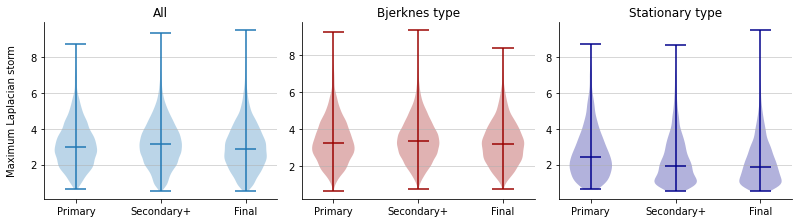

In [131]:
#Strength within a cluster
dataStrength_primary = [lapl_primary,lapl_secondary,lapl_final]
dataStrength_primary_length = [lapl_primary_length,lapl_secondary_length,lapl_final_length]
dataStrength_primary_nolength = [lapl_primary_nolength,lapl_secondary_nolength,lapl_final_nolength]

# Set the figure size
plt.rcParams["figure.figsize"] = [11.50, 3.50]
#plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(1,3)
vio0 = ax[0].violinplot(dataStrength_primary,showmedians=True)
ax[0].set_xticks([1,2,3])
ax[0].set_xticklabels([ "Primary","Secondary+","Final"])
ax[0].set_xlabel("")
ax[0].grid(linewidth=0.5,axis='y',zorder=0)
ax[0].set_title("All")

#vio2 = ax[2].violinplot(data3,widths=.3,showmedians=True)
vio1 = ax[1].violinplot(dataStrength_primary_length,showmedians=True)
ax[1].set_xticks([1,2,3])
ax[1].set_xticklabels(["Primary","Secondary+","Final"])
ax[1].set_xlabel("")
ax[1].grid(linewidth=0.5,axis='y',zorder=0)
ax[1].set_title("Bjerknes type")

vio2 = ax[2].violinplot(dataStrength_primary_nolength,showmedians=True)
ax[2].set_xticks([1,2,3])
ax[2].set_xticklabels([ "Primary","Secondary+","Final"])
ax[2].set_xlabel("")
ax[2].grid(linewidth=0.5,axis='y',zorder=0)
ax[2].set_title("Stationary type")

#Set face colors of violin plots
for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = vio1[partname]
    vp.set_edgecolor("xkcd:deep red")
    vp = vio2[partname]
    vp.set_edgecolor("darkblue") 
#vio0['cmedians'].set_colors("xkcd:deep red")

for pc in vio1['bodies']:
    pc.set_facecolor("xkcd:deep red")
for pc in vio2['bodies']:
    pc.set_facecolor("darkblue")

#Add xlabel and ylabel
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Maximum Laplacian storm")

# Hide the right and top spines
for a in range(3):
    ax[a].spines[['right', 'top']].set_visible(False)

#save Figure
plt.savefig("MaxLaplPdfSubtypes" + reschar + "_WithinCluster_" + str(Options["lngthresh"]) + "_timlength_" + str(Options["timlngthresh"]) + ".pdf")



In [101]:
# strength of storms
lapl_storms = np.zeros(nrstorms)
for strm in range(nrstorms):
    lapl_storms[strm] = np.nanmax(str_lapl[ids_storms[strm+1]])

3.2721871313672923

In [107]:
len(lapl_primary)

5246

In [160]:
# strength of storms
str_lon2 = np.array([(x - 360) if x>180 else x for x in str_lon])
lat_storms = np.zeros(nrstorms)
lon_storms = np.zeros(nrstorms)
lat_storms_conn = np.zeros(nrstorms)
for strm in range(nrstorms):
    lat_storms[strm] = np.nanmean(str_lat[ids_storms[strm+1]])
    lon_storms[strm] = np.nanmean(str_lon2[ids_storms[strm+1]])


In [167]:
np.nanmedian(lon_storms[secondary_storms_Atlantic])

-35.48285714285714

In [144]:
ids_storms[12]

(array([141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158]),)

In [158]:
str_lon2

[-168.3,
 -163.95,
 -160.83,
 -159.11,
 -157.78,
 -155.59,
 -153.2,
 -152.18,
 -154.06,
 -154.22,
 -154.18,
 -154.87,
 -156.36,
 -159.67,
 -145.43,
 -145.47,
 -145.37,
 -145.15,
 -145.51,
 -147.67,
 170.03,
 168.36,
 167.6,
 167.04,
 166.33,
 165.64,
 165.54,
 165.15,
 165.37,
 167.79,
 172.48,
 175.49,
 112.36,
 118.76,
 123.68,
 127.02,
 124.77,
 123.2,
 119.71,
 116.31,
 111.96,
 110.38,
 88.6,
 77.5,
 70.55,
 62.77,
 63.35,
 68.79,
 73.48,
 79.76,
 84.7,
 89.55,
 96.44,
 90.32,
 -85.27999999999997,
 -80.32999999999998,
 -74.38,
 -69.39999999999998,
 -65.47000000000003,
 54.07,
 58.13,
 61.64,
 64.56,
 67.27,
 70.0,
 73.0,
 75.87,
 -21.370000000000005,
 -18.720000000000027,
 -16.04000000000002,
 -12.980000000000018,
 -10.54000000000002,
 -9.04000000000002,
 -7.970000000000027,
 -5.3799999999999955,
 -5.689999999999998,
 -5.829999999999984,
 -6.829999999999984,
 -43.05000000000001,
 -36.50999999999999,
 -31.329999999999984,
 -26.089999999999975,
 -20.19999999999999,
 -14.259999999999